In [1]:
from google.colab import drive

drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
#Import Packages
import pandas as pd
import numpy as np
from scipy.stats import uniform # for training-and-test split
import statsmodels.api as sm # statistical models (including regression)
import statsmodels.formula.api as smf # R-like model specification
import matplotlib.pyplot as plt # 2D plotting
import seaborn as sns # PROVIDES TRELLIS AND SMALL MULTIPLE PLOTTING
from pathlib import Path # for merging dataframes
from sklearn.preprocessing import LabelEncoder #to numberize columns
from sklearn.preprocessing import OneHotEncoder #another way to numberize object columns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
#import required packages
import re
from pprint import pprint
import nltk; nltk.download('stopwords')
import sklearn
import datetime
from datetime import datetime, timedelta
from pandas import DataFrame
import sys
! {sys.executable} -m pip install progress #progress bars
from progress.bar import Bar

pd.set_option("display.max_colwidth", 200)

#gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

#spacy for lemmatization
import sys
! {sys.executable} -m pip install spacy
! {sys.executable} -m pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.2.0/en_core_web_sm-2.2.0.tar.gz
import spacy 


#from spacy_langdetect import LanguageDetector
#nlp = spacy.load('en')
#nlp.add_pipe(LanguageDetector(), name='language_detector', last=True)

# Plotting tools
! {sys.executable} -m pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim  # don't skip this

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

#COMPANY A 

(a_complete.csv 166k rows)

In [3]:
#COMPANY A
#read in data

a_data = pd.read_csv('/content/gdrive/Shared drives/IST 718 Project/a_complete.csv',encoding='ISO-8859-1')
a_data

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (4,9,24,28,39,40,41,52,53,54,62,63,64,65,66,67,68,69,71,75,76,77,79,80,81,83,85,86,87,88,89,91,92) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,assignment_group,number,state,priority,short_description,description,comments_and_work_notes,work_notes,close_notes,location,sys_created_on,closed_at,made_sla,u_initial_response_sla_completed,business_duration,calendar_duration,reassignment_count,sys_mod_count,assigned_to,closed_by,cmdb_ci,contact_type,sys_created_by,due_date,escalation,follow_up,sla_due,sys_tags,u_task_number_flag,sys_class_name,time_worked,sys_updated_on,sys_updated_by,upon_approval,upon_reject,urgency,user_input,u_vendor_ticket_number,watch_list,...,approval_set,impact,knowledge,u_reason_to_hold,skills,location.country,location.u_location_id,location.state,location.u_region,u_actual_category,u_actual_subcategory,u_cause,u_cause_code,u_qs_fcresolve,u_misrouted,approval_history,business_service,company,correlation_id,correlation_display,delivery_plan,delivery_task,sys_domain,task_effective_number,expected_start,group_list,opened_by,order,parent,route_reason,service_offering,universal_request,service_offering.category,service_offering.subcategory,cmdb_ci.subcategory,cmdb_ci.category,ref_sc_req_item.u_category,ref_sc_task.sc_catalog,ref_sc_req_item.u_subcategory,ref_sc_req_item.u_choice_5
0,0,I-ACM-SD L1-India,INC1499259,Cancelled,P4 - Low,User need to Install Jet stream Viewer,NaN,10-27-2020 13:29:00 - Rajat Kumar (Additional comments)\nIncident is Cancelled and a Request Item RITM0974470 is created.\n\n,NaN,NaN,"UKBLF1 - Belfast - The Clarence West Building, 2 Clarence S",10/27/2020 12:50,10/27/2020 13:29,True,False,2337,2337,1,1,Rajat Kumar,Rajat Kumar,NaN,Chat,integration.USM_chat,NaN,Normal,NaN,UNKNOWN,NaN,NaN,Incident,0,10/27/2020 13:29,706502,Proceed to Next Task,Cancel all future Tasks,2 - Medium,NaN,NaN,NaN,...,NaN,3 - Low,False,NaN,NaN,United Kingdom,GB-GNGBP681-0002/BLDG,County Antrim,Europe(EMEA),Software,Software Breakfix,NaN,NaN,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,I-ACM-SD L1-India,INC1499248,Cancelled,P3 - Minor,Asset Update,Computer Name - USATLL7BBV433\r\n,10-27-2020 12:44:04 - Akshay Tah (Additional comments)\nIncident is Cancelled and a Request Item RITM0974457 is created.\n\n,NaN,NaN,USATL1 - Atlanta - 1360 Peachtree St Suite 500,10/27/2020 12:43,10/27/2020 12:44,True,False,136,136,0,1,NaN,Akshay Tah,NaN,Phone,92003742,NaN,Normal,NaN,UNKNOWN,NaN,NaN,Incident,0,10/27/2020 12:44,92003742,Proceed to Next Task,Cancel all future Tasks,2 - Medium,NaN,NaN,NaN,...,NaN,2 - Medium,False,NaN,NaN,United States,US-GNUSO6J1-1360/BLDG,GA,Southeast(AMER),NaN,NaN,NaN,NaN,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,I-ACM-SD L1-India,INC1499193,Cancelled,P4 - Low,#appstore failure,NaN,10-27-2020 12:17:01 - Akanksha Dubey (Additional comments)\nIncident is Cancelled and a Request Item RITM0974441 is created.\n\n,NaN,NaN,USPOR01 - Portland - 111 SW Columbia,10/27/2020 12:16,10/27/2020 12:17,True,False,488,488,0,1,NaN,Akanksha Dubey,NaN,Phone,92003746,NaN,Normal,NaN,UNKNOWN,NaN,NaN,Incident,0,10/27/2020 12:17,92003746,Proceed to Next Task,Cancel all future Tasks,2 - Medium,NaN,NaN,NaN,...,NaN,3 - Low,False,NaN,NaN,United States,US-GNUSSWC1-0111/BLDG,OR,Pacific(AMER),NaN,NaN,NaN,NaN,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,I-ACM-CTS-India,INC1498224,Cancelled,P4 - Low,need assistance turning on bitlocker,Name:Sanjay Kumar\r\nPhone:566539297\r\nEmail address:Sanjay.Kumar4@aecom.com\r\nthe user called in stating his bitlocker is switched off on his computer and needs to switch it on \r\ntook remote ...,10-27-2020 12:22:04 - Kaveri S (Additional comments)\nIncident is Cancelled and a Request Item RITM0974445 is created.\n\n10-27-2020 12:21:54 - Kaveri S (Work notes)\nmcafee is installed on the c...,10-27-2020 12:21:54 - Kaveri S (Work notes)\nmcafee is installed on the computer\r\nbit locker is not enabled\r\ncreating a request tick

In [16]:

a_data['closed_at'] = pd.to_datetime(a_data.closed_at)
a_data['Date'] = a_data['closed_at'].dt.strftime('%Y-%m-%d')
a_data = a_data.sort_values('Date', ascending=True)


In [24]:
#a_data.reset_index(inplace=True)
a_data[a_data['Date']=='2020-01-01']
a_1 = a_data[8090:92000]
a_1ac = a_1[a_1['u_actual_category']=='access-issue/request']
a_1['business_duration'].mean()

58783.50698367298

In [ ]:
#drop blank columns
a_data = a_data.dropna(how='all', axis=1)
a_data #dropped 11 columns.. now we have 81 columns

,Unnamed: 0,assignment_group,number,state,priority,short_description,description,comments_and_work_notes,work_notes,close_notes,location,sys_created_on,closed_at,made_sla,u_initial_response_sla_completed,business_duration,calendar_duration,reassignment_count,sys_mod_count,assigned_to,closed_by,cmdb_ci,contact_type,sys_created_by,due_date,escalation,sla_due,sys_tags,u_task_number_flag,sys_class_name,time_worked,sys_updated_on,sys_updated_by,upon_approval,upon_reject,urgency,watch_list,work_end,work_notes_list,work_start,...,sys_domain_path,active,comments,closed_by.average_daily_fte,closed_by.city,activity_due,approval,location.city,additional_assignee_list,approval_set,impact,knowledge,u_reason_to_hold,location.country,location.u_location_id,location.state,location.u_region,u_actual_category,u_actual_subcategory,u_cause,u_cause_code,u_qs_fcresolve,u_misrouted,approval_history,business_service,correlation_id,sys_domain,task_effective_number,expected_start,opened_by,order,parent,service_offering,service_offering.category,service_offering.subcategory,cmdb_ci.subcategory,cmdb_ci.category,ref_sc_req_item.u_category,ref_sc_req_item.u_subcategory,ref_sc_req_item.u_choice_5
0,0,I-ACM-SD L1-India,INC1499259,Cancelled,P4 - Low,User need to Install Jet stream Viewer,NaN,10-27-2020 13:29:00 - Rajat Kumar (Additional comments)\nIncident is Cancelled and a Request Item RITM0974470 is created.\n\n,NaN,NaN,"UKBLF1 - Belfast - The Clarence West Building, 2 Clarence S",10/27/2020 12:50,10/27/2020 13:29,True,False,2337,2337,1,1,Rajat Kumar,Rajat Kumar,NaN,Chat,integration.USM_chat,NaN,Normal,UNKNOWN,NaN,NaN,Incident,0,10/27/2020 13:29,706502,Proceed to Next Task,Cancel all future Tasks,2 - Medium,NaN,NaN,NaN,10/27/2020 13:29,...,/,False,10-27-2020 13:29:00 - Rajat Kumar (Additional comments)\nIncident is Cancelled and a Request Item RITM0974470 is created.\n\n,NaN,Los Angeles,UNKNOWN,Not Yet Requested,Belfast,NaN,NaN,3 - Low,False,NaN,United Kingdom,GB-GNGBP681-0002/BLDG,County Antrim,Europe(EMEA),Software,Software Breakfix,NaN,NaN,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,I-ACM-SD L1-India,INC1499248,Cancelled,P3 - Minor,Asset Update,Computer Name - USATLL7BBV433\r\n,10-27-2020 12:44:04 - Akshay Tah (Additional comments)\nIncident is Cancelled and a Request Item RITM0974457 is created.\n\n,NaN,NaN,USATL1 - Atlanta - 1360 Peachtree St Suite 500,10/27/2020 12:43,10/27/2020 12:44,True,False,136,136,0,1,NaN,Akshay Tah,NaN,Phone,92003742,NaN,Normal,UNKNOWN,NaN,NaN,Incident,0,10/27/2020 12:44,92003742,Proceed to Next Task,Cancel all future Tasks,2 - Medium,NaN,NaN,NaN,NaN,...,/,False,10-27-2020 12:44:04 - Akshay Tah (Additional comments)\nIncident is Cancelled and a Request Item RITM0974457 is created.\n\n,NaN,Los Angeles,UNKNOWN,Not Yet Requested,Atlanta,NaN,NaN,2 - Medium,False,NaN,United States,US-GNUSO6J1-1360/BLDG,GA,Southeast(AMER),NaN,NaN,NaN,NaN,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,I-ACM-SD L1-India,INC1499193,Cancelled,P4 - Low,#appstore failure,NaN,10-27-2020 12:17:01 - Akanksha Dubey (Additional comments)\nIncident is Cancelled and a Request Item RITM0974441 is created.\n\n,NaN,NaN,USPOR01 - Portland - 111 SW Columbia,10/27/2020 12:16,10/27/2020 12:17,True,False,488,488,0,1,NaN,Akanksha Dubey,NaN,Phone,92003746,NaN,Normal,UNKNOWN,NaN,NaN,Incident,0,10/27/2020 12:17,92003746,Proceed to Next Task,Cancel all future Tasks,2 - Medium,NaN,NaN,NaN,NaN,...,/,False,10-27-2020 12:17:01 - Akanksha Dubey (Additional comments)\nIncident is Cancelled and a Request Item RITM0974441 is created.\n\n,NaN,Los Angeles,UNKNOWN,Not Yet Requested,Portland,NaN,NaN,3 - Low,False,NaN,United States,US-GNUSSWC1-0111/BLDG,OR,Pacific(AMER),NaN,NaN,NaN,NaN,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,I-ACM-CTS-India,INC1498224,Cancelled,P4 - Low,need assistance turning on bitlocker,Name:Sanjay Kumar\r\nPhone:566539297\r\nEmail address:Sanjay.Ku

In [ ]:
#drop any columns that have na values in 100 rows
#a_data = a_data.dropna(thresh=len(a_data) - 10000, axis=1)
#a_data

#drop any columns that have na values in 100 rows
#first split into tasks and incidents so no useful columns are removed
a_data_inc = a_data[:107215]
a_data_tas = a_data[107215:]

#remove columns with NaN in at least 100000 and 10000 rows
a_data_inc = a_data_inc.dropna(thresh=len(a_data_inc) - 100000, axis=1) #due to inc size this one is larger
a_data_tas = a_data_tas.dropna(thresh=len(a_data_tas) - 10000, axis=1)

print(a_data_inc.info()) #reduce to 55 columns
print(a_data_tas.info()) #reduce to 37 columns


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107215 entries, 0 to 107214
Data columns (total 56 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   Unnamed: 0                        107215 non-null  int64  
 1   assignment_group                  107215 non-null  object 
 2   number                            107215 non-null  object 
 3   state                             107215 non-null  object 
 4   priority                          107213 non-null  object 
 5   short_description                 107199 non-null  object 
 6   description                       104255 non-null  object 
 7   comments_and_work_notes           94279 non-null   object 
 8   work_notes                        52448 non-null   object 
 9   close_notes                       99565 non-null   object 
 10  location                          103224 non-null  object 
 11  sys_created_on                    107215 non-null  o

In [ ]:
a_data_inc['closed_by.city'].isna().sum()
a_data_inc = a_data_inc.dropna(axis=0, subset=['closed_by.city'])

In [ ]:
a_data_inc.isnull().sum()

Unnamed: 0                              0
assignment_group                        0
number                                  0
state                                   0
priority                                0
short_description                      13
description                          2836
comments_and_work_notes             12935
work_notes                          54713
close_notes                          5796
location                             3887
sys_created_on                          0
closed_at                               0
made_sla                                0
u_initial_response_sla_completed        0
business_duration                       0
calendar_duration                       0
reassignment_count                      0
sys_mod_count                           0
assigned_to                          2295
closed_by                               0
contact_type                         4048
sys_created_by                          0
escalation                        

In [ ]:
#reassign together
a_data = a_data_inc.append(a_data_tas, ignore_index= True, sort=False) 
a_data = a_data.dropna(axis=0, subset=['location'])
a_data #55 columns

,Unnamed: 0,assignment_group,number,state,priority,short_description,description,comments_and_work_notes,work_notes,close_notes,location,sys_created_on,closed_at,made_sla,u_initial_response_sla_completed,business_duration,calendar_duration,reassignment_count,sys_mod_count,assigned_to,closed_by,contact_type,sys_created_by,escalation,sla_due,u_task_number_flag,sys_class_name,time_worked,sys_updated_on,sys_updated_by,upon_approval,upon_reject,urgency,work_start,opened_at,sys_domain_path,active,comments,closed_by.average_daily_fte,closed_by.city,activity_due,approval,location.city,impact,knowledge,u_reason_to_hold,location.country,location.u_location_id,location.state,location.u_region,u_actual_category,u_actual_subcategory,u_cause,u_cause_code,u_qs_fcresolve,u_misrouted,due_date,sys_domain,task_effective_number
0,0,I-ACM-SD L1-India,INC1499259,Cancelled,P4 - Low,User need to Install Jet stream Viewer,NaN,10-27-2020 13:29:00 - Rajat Kumar (Additional comments)\nIncident is Cancelled and a Request Item RITM0974470 is created.\n\n,NaN,NaN,"UKBLF1 - Belfast - The Clarence West Building, 2 Clarence S",10/27/2020 12:50,10/27/2020 13:29,True,False,2337,2337,1,1,Rajat Kumar,Rajat Kumar,Chat,integration.USM_chat,Normal,UNKNOWN,NaN,Incident,0,10/27/2020 13:29,706502,Proceed to Next Task,Cancel all future Tasks,2 - Medium,10/27/2020 13:29,10/27/2020 12:50,/,False,10-27-2020 13:29:00 - Rajat Kumar (Additional comments)\nIncident is Cancelled and a Request Item RITM0974470 is created.\n\n,NaN,Los Angeles,UNKNOWN,Not Yet Requested,Belfast,3 - Low,False,NaN,United Kingdom,GB-GNGBP681-0002/BLDG,County Antrim,Europe(EMEA),Software,Software Breakfix,NaN,NaN,False,False,NaN,NaN,NaN
1,1,I-ACM-SD L1-India,INC1499248,Cancelled,P3 - Minor,Asset Update,Computer Name - USATLL7BBV433\r\n,10-27-2020 12:44:04 - Akshay Tah (Additional comments)\nIncident is Cancelled and a Request Item RITM0974457 is created.\n\n,NaN,NaN,USATL1 - Atlanta - 1360 Peachtree St Suite 500,10/27/2020 12:43,10/27/2020 12:44,True,False,136,136,0,1,NaN,Akshay Tah,Phone,92003742,Normal,UNKNOWN,NaN,Incident,0,10/27/2020 12:44,92003742,Proceed to Next Task,Cancel all future Tasks,2 - Medium,NaN,10/27/2020 12:41,/,False,10-27-2020 12:44:04 - Akshay Tah (Additional comments)\nIncident is Cancelled and a Request Item RITM0974457 is created.\n\n,NaN,Los Angeles,UNKNOWN,Not Yet Requested,Atlanta,2 - Medium,False,NaN,United States,US-GNUSO6J1-1360/BLDG,GA,Southeast(AMER),NaN,NaN,NaN,NaN,False,False,NaN,NaN,NaN
2,2,I-ACM-SD L1-India,INC1499193,Cancelled,P4 - Low,#appstore failure,NaN,10-27-2020 12:17:01 - Akanksha Dubey (Additional comments)\nIncident is Cancelled and a Request Item RITM0974441 is created.\n\n,NaN,NaN,USPOR01 - Portland - 111 SW Columbia,10/27/2020 12:16,10/27/2020 12:17,True,False,488,488,0,1,NaN,Akanksha Dubey,Phone,92003746,Normal,UNKNOWN,NaN,Incident,0,10/27/2020 12:17,92003746,Proceed to Next Task,Cancel all future Tasks,2 - Medium,NaN,10/27/2020 12:08,/,False,10-27-2020 12:17:01 - Akanksha Dubey (Additional comments)\nIncident is Cancelled and a Request Item RITM0974441 is created.\n\n,NaN,Los Angeles,UNKNOWN,Not Yet Requested,Portland,3 - Low,False,NaN,United States,US-GNUSSWC1-0111/BLDG,OR,Pacific(AMER),NaN,NaN,NaN,NaN,False,False,NaN,NaN,NaN
3,3,I-ACM-CTS-India,INC1498224,Cancelled,P4 - Low,need assistance turning on bitlocker,Name:Sanjay Kumar\r\nPhone:566539297\r\nEmail address:Sanjay.Kumar4@aecom.com\r\nthe user called in stating his bitlocker is switched off on his computer and needs to switch it on \r\ntook remote ...,10-27-2020 12:22:04 - Kaveri S (Additional comments)\nIncident is Cancelled and a Request Item RITM0974445 is created.\n\n10-27-2020 12:21:54 - Kaveri S (Work notes)\nmcafee is installed on the c...,10-27-2020 12:21:54 - Kaveri S (Work notes)\nmcafee is installed on the computer\r\nbit locker is not enabled\r\ncreating a request ticket to remove mcafee\r\n\r\nKB0033325\n\n10-27-2020 12:20:37 ...,NaN,"SARYD1 - RIYADH - Tawuniya Towers, South Tower, M

In [ ]:
keep = [c for c
        in list(a_data)
        if len(a_data[c].unique())>1]

keep

['Unnamed: 0',
 'assignment_group',
 'number',
 'state',
 'priority',
 'short_description',
 'description',
 'comments_and_work_notes',
 'work_notes',
 'close_notes',
 'location',
 'sys_created_on',
 'closed_at',
 'u_initial_response_sla_completed',
 'business_duration',
 'calendar_duration',
 'reassignment_count',
 'sys_mod_count',
 'assigned_to',
 'closed_by',
 'contact_type',
 'sys_created_by',
 'sla_due',
 'u_task_number_flag',
 'sys_class_name',
 'sys_updated_on',
 'sys_updated_by',
 'urgency',
 'work_start',
 'opened_at',
 'active',
 'comments',
 'closed_by.average_daily_fte',
 'closed_by.city',
 'activity_due',
 'approval',
 'location.city',
 'impact',
 'knowledge',
 'u_reason_to_hold',
 'location.country',
 'location.u_location_id',
 'location.state',
 'location.u_region',
 'u_actual_category',
 'u_actual_subcategory',
 'u_cause',
 'u_cause_code',
 'u_qs_fcresolve',
 'u_misrouted',
 'due_date',
 'sys_domain',
 'task_effective_number']

In [ ]:
a_data = a_data[keep]

In [ ]:
#Clean some of the string data
a_data['short_description'] = a_data['short_description'].str.lower()
a_data['description'] = a_data['description'].str.lower()
a_data['close_notes'] = a_data['close_notes'].str.lower()
a_data['urgency'] = a_data['urgency'].str.extract(r'(^\d)')
a_data['priority'] = a_data['priority'].str.extract(r'(^[P]\d)')
a_data['location'] = a_data['location'].str.lower()
a_data['closed_by'] = a_data['closed_by'].str.extract(r'(^\d)')
a_data['sys_created_by'] = a_data['sys_created_by'].str.extract(r'(^\d)')
a_data['sys_updated_by'] = a_data['sys_updated_by'].str.extract(r'(^\d)')
a_data['closed_by.city'] = a_data['closed_by.city'].str.lower()
a_data['u_actual_category'] = a_data['u_actual_category'].str.lower()
a_data['u_actual_subcategory'] = a_data['u_actual_subcategory'].str.lower()
a_data['u_cause'] = a_data['u_cause'].str.lower()
a_data['comments'] = a_data['comments'].str.lower()
a_data['location.u_region'] = a_data['location.u_region'].str.lower()
a_data['location.city'] = a_data['location.city'].str.lower()
a_data['location.country'] = a_data['location.country'].str.lower()
a_data['location.state'] = a_data['location.state'].str.lower()
a_data['location.country'] = a_data['location.country'].str.lower()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [ ]:
# convert to datetimeformat

a_data['sys_created_on'] = pd.to_datetime(a_data['sys_created_on']) #, format='%m/%d/%Y %H:%M')
a_data['closed_at'] = pd.to_datetime(a_data['closed_at']) #, format='%m/%d/%Y %H:%M')
a_data['sys_updated_on'] = pd.to_datetime(a_data['sys_updated_on']) #,format='%m/%d/%Y %H:%M')
a_data['opened_at'] = pd.to_datetime(a_data['opened_at']) #, format='%m/%d/%Y %H:%M')
a_data['due_date'] = pd.to_datetime(a_data['due_date']) #, format='%m/%d/%Y %H:%M')

#a_data['u_time_last_workgroup_first_se'] = pd.to_datetime(a_data['u_time_last_workgroup_first_se'],format='%m/%d/%Y %H:%M') 	
#a_data['u_last_transfer_time'] = pd.to_datetime(a_data['u_last_transfer_time'],format='%m/%d/%Y %H:%M')
#a_data['u_time_resolved'] = pd.to_datetime(a_data['u_time_resolved'],format='%m/%d/%Y %H:%M')
#a_data['u_last_assignment_time'] = pd.to_datetime(a_data['u_last_assignment_time'],format='%m/%d/%Y %H:%M')
#a_data['Resolved'] = pd.to_datetime(a_data['Resolved'], format="%m/%d/%Y, %H:%M:%S")     #Resolved column should not be missing... may have to have data re-run
#a_data['sla_due'] = pd.to_datetime(a_data['sla_due'], format='%m/%d/%Y %H:%M')
#a_data['activity_due'] = pd.to_datetime(a_data['activity_due'], format='%m/%d/%Y %H:%M')      #needs to be cleaned from "UNKNOWN" strings before can convert to datetime

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [ ]:
#DURATION 
TicketDuration = (a_data['closed_at'] - a_data['opened_at'])
a_data['TicketDuration'] = TicketDuration


#convert durations
CalendarDuration = []
for n in a_data['calendar_duration']:
  try:
    x = int(n)
  except ValueError:
    x = 0
  
  a = str(timedelta(seconds = x))
  CalendarDuration.append(a)
a_data['CalendarDuration'] = CalendarDuration

BusinessDuration = []
for n in a_data['business_duration']:
  try:
    x = int(n)
  except ValueError:
    x = 0
  
  a = str(timedelta(seconds = x))
  BusinessDuration.append(a)
a_data['BusinessDuration'] = BusinessDuration


#then rename old columns for eda
a_data.rename(columns={'calendar_duration': 'cal_dur_num', 'business_duration':'bus_dur_num'}, inplace=True)
a_data #56 columns

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

,Unnamed: 0,assignment_group,number,state,priority,short_description,description,comments_and_work_notes,work_notes,close_notes,location,sys_created_on,closed_at,u_initial_response_sla_completed,bus_dur_num,cal_dur_num,reassignment_count,sys_mod_count,assigned_to,closed_by,contact_type,sys_created_by,sla_due,u_task_number_flag,sys_class_name,sys_updated_on,sys_updated_by,urgency,work_start,opened_at,active,comments,closed_by.average_daily_fte,closed_by.city,activity_due,approval,location.city,impact,knowledge,u_reason_to_hold,location.country,location.u_location_id,location.state,location.u_region,u_actual_category,u_actual_subcategory,u_cause,u_cause_code,u_qs_fcresolve,u_misrouted,due_date,sys_domain,task_effective_number,TicketDuration,CalendarDuration,BusinessDuration
0,0,I-ACM-SD L1-India,INC1499259,Cancelled,P4,user need to install jet stream viewer,NaN,10-27-2020 13:29:00 - Rajat Kumar (Additional comments)\nIncident is Cancelled and a Request Item RITM0974470 is created.\n\n,NaN,NaN,"ukblf1 - belfast - the clarence west building, 2 clarence s",2020-10-27 12:50:00,2020-10-27 13:29:00,False,2337,2337,1,1,Rajat Kumar,NaN,Chat,NaN,UNKNOWN,NaN,Incident,2020-10-27 13:29:00,7,2,10/27/2020 13:29,2020-10-27 12:50:00,False,10-27-2020 13:29:00 - rajat kumar (additional comments)\nincident is cancelled and a request item ritm0974470 is created.\n\n,NaN,los angeles,UNKNOWN,Not Yet Requested,belfast,3 - Low,False,NaN,united kingdom,GB-GNGBP681-0002/BLDG,county antrim,europe(emea),software,software breakfix,NaN,NaN,False,False,NaT,NaN,NaN,0 days 00:39:00,0:38:57,0:38:57
1,1,I-ACM-SD L1-India,INC1499248,Cancelled,P3,asset update,computer name - usatll7bbv433\r\n,10-27-2020 12:44:04 - Akshay Tah (Additional comments)\nIncident is Cancelled and a Request Item RITM0974457 is created.\n\n,NaN,NaN,usatl1 - atlanta - 1360 peachtree st suite 500,2020-10-27 12:43:00,2020-10-27 12:44:00,False,136,136,0,1,NaN,NaN,Phone,9,UNKNOWN,NaN,Incident,2020-10-27 12:44:00,9,2,NaN,2020-10-27 12:41:00,False,10-27-2020 12:44:04 - akshay tah (additional comments)\nincident is cancelled and a request item ritm0974457 is created.\n\n,NaN,los angeles,UNKNOWN,Not Yet Requested,atlanta,2 - Medium,False,NaN,united states,US-GNUSO6J1-1360/BLDG,ga,southeast(amer),NaN,NaN,NaN,NaN,False,False,NaT,NaN,NaN,0 days 00:03:00,0:02:16,0:02:16
2,2,I-ACM-SD L1-India,INC1499193,Cancelled,P4,#appstore failure,NaN,10-27-2020 12:17:01 - Akanksha Dubey (Additional comments)\nIncident is Cancelled and a Request Item RITM0974441 is created.\n\n,NaN,NaN,uspor01 - portland - 111 sw columbia,2020-10-27 12:16:00,2020-10-27 12:17:00,False,488,488,0,1,NaN,NaN,Phone,9,UNKNOWN,NaN,Incident,2020-10-27 12:17:00,9,2,NaN,2020-10-27 12:08:00,False,10-27-2020 12:17:01 - akanksha dubey (additional comments)\nincident is cancelled and a request item ritm0974441 is created.\n\n,NaN,los angeles,UNKNOWN,Not Yet Requested,portland,3 - Low,False,NaN,united states,US-GNUSSWC1-0111/BLDG,or,pacific(amer),NaN,NaN,NaN,NaN,False,False,NaT,NaN,NaN,0 days 00:09:00,0:08:08,0:08:08
3,3,I-ACM-CTS-India,INC1498224,Cancelled,P4,need assistance turning on bitlocker,name:sanjay kumar\r\nphone:566539297\r\nemail address:sanjay.kumar4@aecom.com\r\nthe user called in stating his bitlocker is switched off on his computer and needs to switch it on \r\ntook remote ...,10-27-2020 12:22:04 - Kaveri S (Additional comments)\nIncident is Cancelled and a Request Item RITM0974445 is created.\n\n10-27-2020 12:21:54 - Kaveri S (Work notes)\nmcafee is installed on the c...,10-27-2020 12:21:54 - Kaveri S (Work notes)\nmcafee is installed on the computer\r\nbit locker is not enabled\r\ncreating a request ticket to remove mcafee\r\n\r\nKB0033325\n\n10-27-2020 12:20:37 ...,NaN,"saryd1 - riyadh - tawuniya towers, south tower, mezzanine",2020-10-27 00:29:00,2020-10-27 12:22:00,False,1324,42739,1,12,Kaveri S,NaN,Phone,9,UNKNOWN,NaN,Incident,2020-10-27 12:22:00,9,2,10/27/2020 0:33,2020-10-27 00:29:00,False,10-27-2020 12:22:04 - kaveri s (addit

In [ ]:
a_data["short_description"].str.split(expand=True).stack().value_counts()

to                 48259
-                  30234
request            27141
a                  25059
service            19132
                   ...  
-ganesh.kalkar1        1
symnbuucoden2          1
transferred/571        1
rsest-                 1
9174                   1
Length: 57994, dtype: int64

In [ ]:
#a_data["description"].str.split(expand=True).stack().value_counts() #this takes about 2 minutes to run and not sure of value.. consider dropping

In [ ]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [ ]:
#convert to string
a_data['short_description'] = a_data['short_description'].astype(str)
#a_data['description'] = a_data['description'].astype(str)

#convert to list
a_data['short_description'] = a_data['short_description'].values.tolist()
#a_data['description'] = a_data['description'].values.tolist()

#remove emails
a_data['short_description'] = [re.sub('\S*@\S*\s?', '', sent) for sent in a_data['short_description']]
#a_data['description'] = [re.sub('\S*@\S*\s?', '', sent) for sent in a_data['description']]

#remove new line characters
a_data['short_description'] = [re.sub('\s+', ' ', sent) for sent in a_data['short_description']]
#a_data['description'] = [re.sub('\s+', ' ', sent) for sent in a_data['description']]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

In [ ]:
# Remove distracting single quotes
a_data['short_description'] = [re.sub("\'", "", sent) for sent in a_data['short_description']]
a_data['short_description'] = [re.sub("\(\)", "", sent) for sent in a_data['short_description']]
#a_data['description'] = [re.sub("\'", "", sent) for sent in a_data['description']]
#a_data['description'] = [re.sub("\(\)", "", sent) for sent in a_data['description']]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
#a_data["comments"].str.split(expand=True).stack().value_counts()   #this is crashing the script consider dropping

In [ ]:
a_data["close_notes"].str.split(expand=True).stack().value_counts()

the                116813
user                88197
to                  87378
resolved            38445
and                 37877
                    ...  
queues                  1
-0867962577             1
suraiya                 1
(hardwired              1
laptop........;         1
Length: 56562, dtype: int64

In [ ]:
#convert to string
#a_data['comments'] = a_data['comments'].astype(str)
a_data['close_notes'] = a_data['close_notes'].astype(str)
#convert to list
#a_data['comments'] = a_data['comments'].values.tolist()
a_data['close_notes'] = a_data['close_notes'].values.tolist()
#remove emails
#a_data['comments'] = [re.sub('\S*@\S*\s?', '', sent) for sent in a_data['comments']]
a_data['close_notes'] = [re.sub('\S*@\S*\s?', '', sent) for sent in a_data['close_notes']]
#remove new line characters
#a_data['comments'] = [re.sub('\s+', ' ', sent) for sent in a_data['comments']]
a_data['close_notes'] = [re.sub('\s+', ' ', sent) for sent in a_data['close_notes']]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [ ]:
# Remove distracting single quotes
#a_data['comments'] = [re.sub("\'", "", sent) for sent in a_data['comments']]
#a_data['comments'] = [re.sub("\(\)", "", sent) for sent in a_data['comments']]
a_data['close_notes'] = [re.sub("\'", "", sent) for sent in a_data['close_notes']]
a_data['close_notes'] = [re.sub("\(\)", "", sent) for sent in a_data['close_notes']]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
#get unique locations
a_data["location"]
# List = DF.model.unique() # look for unique values:
uniqueLoc = a_data["location"].unique()
print(uniqueLoc)

['ukblf1 - belfast - the clarence west building, 2 clarence s'
 'usatl1 - atlanta - 1360 peachtree st suite 500'
 'uspor01 - portland - 111 sw columbia'
 'saryd1 - riyadh - tawuniya towers, south tower, mezzanine '
 'auper1 - perth - 181 adelaide terrace'
 'usnyc8 - new york city - 2315 broadway'
 'cacgy01 - calgary - 240-6025 11 street se'
 'usach1 - anchorage - 700 g street'
 "ukcam1 - cambridge - 36 storey's way"
 'ussdg1 - san diego - 401 west a street'
 'iedub1 - cork - douglas business centre'
 'ustpa1 - tampa - 7650 west courtney campbell causeway'
 'usral3 - raleigh - 701 corporate center drive'
 'ukwrt1 - warrington - birchwoos park'
 'ukmcr2 - manchester - aecom bridgewater house, 60 whitworth st'
 'eumad1 - madrid -' 'chshe1 - shenzhen - 14/f southern securities'
 'chsha1 - shanghai - 9-12/f corporate avenue' 'hkhgk1 - shatin, n.t. -'
 'uscgb1 - coral gables - 800 douglas entrance'
 'caskn1 - saskatoon - 2100 8th street'
 'uschg1 - chicago - 303 e wacker dr'
 'usden06 - denv

In [ ]:
#convert to list
locations = list(set(a_data['location']))
print(locations)

In [ ]:
#normalize locations
a_data["location"] = a_data["location"].replace("ukblf1 - belfast - the clarence west building, 2 clarence s", "belfast")
a_data["location"] = a_data["location"].replace("usatl1 - atlanta - 1360 peachtree st suite 500", "atlanta 1360 ptree")
a_data["location"] = a_data["location"].replace("uspor01 - portland - 111 sw columbia", "portland")
a_data["location"] = a_data["location"].replace("saryd1 - riyadh - tawuniya towers, south tower, mezzanine ", "riyadh, SA")
a_data["location"] = a_data["location"].replace("auper1 - perth - 181 adelaide terrace", "perth")
a_data["location"] = a_data["location"].replace("usnyc8 - new york city - 2315 broadway", "new york city broadway")
a_data["location"] = a_data["location"].replace("cacgy01 - calgary - 240-6025 11 street se, Texas", "calgary")
a_data["location"] = a_data["location"].replace("usach1 - anchorage - 700 g street", "anchorage")
a_data["location"] = a_data["location"].replace("ukcam1 - cambridge - 36 storey's way", "cambridge")
a_data["location"] = a_data["location"].replace("ussdg1 - san diego - 401 west a street", "san diego")
a_data["location"] = a_data["location"].replace("iedub1 - cork - douglas business centre", "cork")
a_data["location"] = a_data["location"].replace("ustpa1 - tampa - 7650 west courtney campbell causeway", "tampa")
a_data["location"] = a_data["location"].replace("usral3 - raleigh - 701 corporate center drive", "raleigh")
a_data["location"] = a_data["location"].replace("ukwrt1 - warrington - birchwoos park", "warrington")
a_data["location"] = a_data["location"].replace("ukmcr2 - manchester - aecom bridgewater house, 60 whitworth st", "manchester bridgewater")
a_data["location"] = a_data["location"].replace("eumad1 - madrid -","madrid") 
a_data["location"] = a_data["location"].replace("chshe1 - shenzhen - 14/f southern securities", "shenzhen")
a_data["location"] = a_data["location"].replace("chsha1 - shanghai - 9-12/f corporate avenue","shanghai") 
a_data["location"] = a_data["location"].replace("hkhgk1 - shatin, n.t. -", "shatin")
a_data["location"] = a_data["location"].replace("uscgb1 - coral gables - 800 douglas entrance", "coral gables")
a_data["location"] = a_data["location"].replace("caskn1 - saskatoon - 2100 8th street", "saskatoon")
a_data["location"] = a_data["location"].replace("uschg1 - chicago - 303 e wacker dr", "chicago")
a_data["location"] = a_data["location"].replace("usden06 - denver - 7595 technology way", "denver")
a_data["location"] = a_data["location"].replace("uswes1 - manchester - 1155 elm street", "manchester elm")
a_data["location"] = a_data["location"].replace("usgrr01 - grand rapids - 3950 sparks drive se", "grand rapids")
a_data["location"] = a_data["location"].replace("usarl1 - arlington - 3101 wilson blvd", "arlington")
a_data["location"] = a_data["location"].replace("usind2 - indianapolis - 2450 s. tibbs ave", "indianapolis")
a_data["location"] = a_data["location"].replace("ukbdf1 - bedford - aecom house harpur centre, horne lane, b", "bedford")
a_data["location"] = a_data["location"].replace("usnyc4 - new york city - 100 park avenue","new york city") 
a_data["location"] = a_data["location"].replace("other - - ", "other")
a_data["location"] = a_data["location"].replace("plwaw01 - warsaw - ambassador office building", "warsaw")
a_data["location"] = a_data["location"].replace("caedm1 - edmonton - 18817 stony plain rd nw","edmonton") 
a_data["location"] = a_data["location"].replace("aubrs1 - brisbane -", "brisbane")
a_data["location"] = a_data["location"].replace("aubne1 - fortitude valley - 540 wickham st","fortitude valley") 
a_data["location"] = a_data["location"].replace("auade1 - adelaide -", "adelaide")
a_data["location"] = a_data["location"].replace("usora1 - orange - 999 town and country road", "orange")
a_data["location"] = a_data["location"].replace("usnyc1 - new york city - 605 third avenue", "new york city 3rd ave")
a_data["location"] = a_data["location"].replace("cawpg1 - winnipeg - 99 commerce dr", "winnipeg")
a_data["location"] = a_data["location"].replace("usrnk1 - roanoke - 10 s. jefferson st., sw","roanoke") 
a_data["location"] = a_data["location"].replace("ukche1 - chesterfield -", "chesterfield")
a_data["location"] = a_data["location"].replace("usclb2 - columbus - 277 west nationwide boulevard", "columbus")
a_data["location"] = a_data["location"].replace("ussfo05 - san francisco - 710 north mcdonnell road","san francisco") 
a_data["location"] = a_data["location"].replace("euitl1 - milan -", "milan")
a_data["location"] = a_data["location"].replace("iedbl1 - dublin - 24 lower hatch street, dublin 2, ireland", "dublin")
a_data["location"] = a_data["location"].replace("inggn3 - gurgaon - dlf cyber city, dlf phase ii3rd floor, t", "gurgaon cyber city")
a_data["location"] = a_data["location"].replace("inggn07 - gurgaon - sp infocity, plot # 243, 2nd floor, towe", "gurgaon info city")
a_data["location"] = a_data["location"].replace("inccu1 - kolkata - aecom india pvt ltd, 1st floor, tower-c,", "kolkata")
a_data["location"] = a_data["location"].replace("cawby1 - whitby - 300 water st","whitby") 
a_data["location"] = a_data["location"].replace("usaus1 - austin - 400 west 15th st", "austin")
a_data["location"] = a_data["location"].replace("usshf01 - southfield - 27777 franklin road", "southfield")
a_data["location"] = a_data["location"].replace("usnol1 - new orleans - 1515 poydras street", "new orleans")
a_data["location"] = a_data["location"].replace("ushnl1 - honolulu - 1001 bishop street", "honolulu")
a_data["location"] = a_data["location"].replace("uklon1 - london - 71 high holborn", "london")
a_data["location"] = a_data["location"].replace("uswak1 - wakefield - 701 edgewater drive", "wakefield")
a_data["location"] = a_data["location"].replace("usaus2 - austin - 9400 amberglen blvd", "austin")
a_data["location"] = a_data["location"].replace("sgsgp2 - singapore - the concourse", "singapore")
a_data["location"] = a_data["location"].replace("ussjo1 - san jose - 2025 gateway place", "san jose")
a_data["location"] = a_data["location"].replace("usnyc2 - new york city - 125 broad street", "new york city broad street")
a_data["location"] = a_data["location"].replace("usdal1 - dallas - 13355 noel road", "dallas")
a_data["location"] = a_data["location"].replace("uswpb1 - west palm beach - 2090 palm beach lakes blvd", "west palm beach")
a_data["location"] = a_data["location"].replace("ukdby1 - chesterfield - aecom, royal court, basil cl, chesterfie", "chesterfield")
a_data["location"] = a_data["location"].replace("usvab1 - glen allen - 4840 cox road", "glen allen")
a_data["location"] = a_data["location"].replace("useng1 - greenwood village - 6200 south", "greenwood village")
a_data["location"] = a_data["location"].replace("usral1 - morrisville - 1600 perimeter pa", "morrisville")
a_data["location"] = a_data["location"].replace("usphx02 - phoenix - 7720 north 16th street", "phoenix")
a_data["location"] = a_data["location"].replace("cacgy3 - calgary - 48 quarry park blvd se", "calgary")
a_data["location"] = a_data["location"].replace("brsap1 - sao paulo - rua tenente negrã£o, 140", "sao paulo")
a_data["location"] = a_data["location"].replace("usger1 - germantown - 12420 milestone ce", "germantown")
a_data["location"] = a_data["location"].replace("usroa1 - roanoke - 10 s jefferson st", "roanoke")
a_data["location"] = a_data["location"].replace("uscsk1 - conshohocken - 625 west ridge oike", "conshohocken")
a_data["location"] = a_data["location"].replace("uksta1 - st albans - aecom house, 63-77 victoria street, st a", "st albans")
a_data["location"] = a_data["location"].replace("usclv1 - cleveland - 1300 east 9th street", "cleveland")
a_data["location"] = a_data["location"].replace("uspsw2 - piscataway - 30 knightsbridge road", "piscataway")
a_data["location"] = a_data["location"].replace("ukglg1 - glasgow - 120-136 bothwell street, glasgow, g4 0jy", "glasgow")
a_data["location"] = a_data["location"].replace("usnyc3 - new york city - one penn plaza", "new york city 1 pen")
a_data["location"] = a_data["location"].replace("usnek1 - piscataway - 30 knightsbridge r", "piscataway")
a_data["location"] = a_data["location"].replace("usdal2 - farmers branch - 4100 alpha", "farmers branch")
a_data["location"] = a_data["location"].replace("uslax5 - los angeles - 1999 avenue of th", "los angeles")
a_data["location"] = a_data["location"].replace("ukexe1 - exeter - belvedere house, woodwater park, pynes h", "exeter")
a_data["location"] = a_data["location"].replace("ukbmg1 - birmingham -","birmingham") 
a_data["location"] = a_data["location"].replace("uscnc02 - cincinnati - 525 vine street", "cincinnati")
a_data["location"] = a_data["location"].replace("usbct1 - boca raton - 7800 congress avenue", "boca raton")
a_data["location"] = a_data["location"].replace("uswil1 - philadelphia - 1700 market st", "philadelphia")
a_data["location"] = a_data["location"].replace("usclv01 - cleveland - 1300 e 9th st", "cleveland")
a_data["location"] = a_data["location"].replace("uspct1 - princeton - 510 carnegie center", "princeton")
a_data["location"] = a_data["location"].replace("ustol1 - toledo - 420 madison avenue","toledo") 
a_data["location"] = a_data["location"].replace("ukchl1 - chelmsford -", "chelmsford")
a_data["location"] = a_data["location"].replace("usstp1 - tallahassee - 1625 summit lake","tallahassee") 
a_data["location"] = a_data["location"].replace("sariy1 - riyadh -", "riyadh")
a_data["location"] = a_data["location"].replace("usla3 - los angeles - 1999 avenue of the stars", "los angeles")
a_data["location"] = a_data["location"].replace("uslvl1 - louisville - 500 west jefferson street", "louisville")
a_data["location"] = a_data["location"].replace("ukman1 - manchester - 1 new york street","manchester") 
a_data["location"] = a_data["location"].replace("baman01 - manama - euro tower", "manchester 1 ny")
a_data["location"] = a_data["location"].replace("usscr2 - sacramento - 2020 l st", "sacramento")
a_data["location"] = a_data["location"].replace("usorl2 - orlando - 4974 orl tower road", "orlando")
a_data["location"] = a_data["location"].replace("usorg1 - oregon - 4001 cesar point rd", "oregon")
a_data["location"] = a_data["location"].replace("usdlh1 - duluth - 11 east superior st", "duluth")
a_data["location"] = a_data["location"].replace("p0633 - coral gables - 100 almeria ave.", "coral gables")
a_data["location"] = a_data["location"].replace("usphx1 - phoenix - 2325 east camelback road", "phoenix")
a_data["location"] = a_data["location"].replace("uklon6 - london - aldgate tower, 2 leman st", "london")
a_data["location"] = a_data["location"].replace("ushnv01 - hunt valley - 4 north park drive", "hunt valley")
a_data["location"] = a_data["location"].replace("usmia1 - tampa - 7650 w courtney campbel", "tampa")
a_data["location"] = a_data["location"].replace("usnwr1 - newark - 4501 ogletown road", "newark")
a_data["location"] = a_data["location"].replace("uswdc4 - arlington - 3101 wilson blvd", "arlington")
a_data["location"] = a_data["location"].replace("phmnl1 - taguig city - 3rd avenue corner 31st street", "taguig city")
a_data["location"] = a_data["location"].replace("usprv1 - providence - 10 orms street", "providence")
a_data["location"] = a_data["location"].replace("uslax02 - los angeles - 300 s grand ave", "los angeles - grand ave")
a_data["location"] = a_data["location"].replace("inmaa2 - chennai - asv ramanas tower, third floor , old no. 37 & 38 , new no. 52", "chennai")
a_data["location"] = a_data["location"].replace("usclf2 - clifton - 1255 broad street", "clifton")
a_data["location"] = a_data["location"].replace("ushbg1 - mechanicsburg - 600 bent creek blv,", "mechanicsburg")
a_data["location"] = a_data["location"].replace("ukcro1 - croydon - bedford park", "croydon")
a_data["location"] = a_data["location"].replace("inbng01 - bangalore - no 43 richmond road , opp reliance trend", "bangalore")
a_data["location"] = a_data["location"].replace("usfml1 - fort mill - 3023 hsbc way", "fort mill")
a_data["location"] = a_data["location"].replace("usnyc50 - new york city - one gustave l. levy place", "new york city 1 gustave")
a_data["location"] = a_data["location"].replace("inmbi1 - mumbai - aecom, unit no 2, 8th floor, times squar", "mumbai")
a_data["location"] = a_data["location"].replace("uklds1 - leeds - 2 city walk", "leeds")
a_data["location"] = a_data["location"].replace("usbtr1 - baton rouge - 8555 united plaza blvd", "baton rouge")
a_data["location"] = a_data["location"].replace("usphl1 - philadelphia - 1700 market street", "philadelphia")
a_data["location"] = a_data["location"].replace("ukplh1 - plymouth - plumer house, tailyour road", "plymouth")
a_data["location"] = a_data["location"].replace("ukedi2 - edinburgh - tanfield -", "edinburgh")
a_data["location"] = a_data["location"].replace("esmad1 - madrid - alfonso xii, 62, madrid 28014, spain", "madrid")
a_data["location"] = a_data["location"].replace("aedxb5 - dubai - level 43, ubora tower; business bay, dub", "dubai")
a_data["location"] = a_data["location"].replace("ukbhm2 - birmingham - the colmore building, colmore circus que", "birmingham")
a_data["location"] = a_data["location"].replace("sajed1 - jeddah - 7th flr. bin sulaiman center,p.o. box 15", "jeddah")
a_data["location"] = a_data["location"].replace("zacpt2 - cape town - bellville - waterside place,south gate, tyger waterf", "cape town")
a_data["location"] = a_data["location"].replace("ukalt1 - altrincham - ","altrincham") 
a_data["location"] = a_data["location"].replace("ukbri1 - bristol - the crescent centre", "bristol")
a_data["location"] = a_data["location"].replace("ukwrg1 - warrington - 4th floor, 401 faraday street, birchwood", "warrington")
a_data["location"] = a_data["location"].replace("uklpl1 - liverpool - regus, merchants court, 2-12 lord street", "liverpool")
a_data["location"] = a_data["location"].replace("inggn5 - gurgaon - aecom (urs) 19th floor, tower c, buildin", "gurgaon 19th")
a_data["location"] = a_data["location"].replace("ukswi1 - swindon - tricentre 3, newbridge square, swindon, ", "swindon")
a_data["location"] = a_data["location"].replace("ukliv1 - liverpool -","liverpool") 
a_data["location"] = a_data["location"].replace("aeabd1 - abu dhabi - international tower", "abu dhabi")
a_data["location"] = a_data["location"].replace("zadur1 - durban - ridgeview building, 01 nokwe ave", "durban")
a_data["location"] = a_data["location"].replace("aeauh1 - abu dhabi - level 10, international tower", "abu dhabi")
a_data["location"] = a_data["location"].replace("hksht1 - shatin - 138 shatin rural committee road", "shatin")
a_data["location"] = a_data["location"].replace("aumel1 - melbourne - 727 collins street, tower 2", "melbourne")
a_data["location"] = a_data["location"].replace("sgsin1 - singapore - 300 beach road", "singapore")
a_data["location"] = a_data["location"].replace("usoak01 - oakland - 300 lakeside dr", "oakland")
a_data["location"] = a_data["location"].replace("usslc2 - salt lake city - 756 east winchester street", "salt lake city")
a_data["location"] = a_data["location"].replace("ussf1 - san francisco - 300 california street", "san francisco")
a_data["location"] = a_data["location"].replace("uswsh1 - glen allen - 4840 cox road", "glen allen")
a_data["location"] = a_data["location"].replace("ussea1 - seattle - 1111 3rd avenue", "seattle")
a_data["location"] = a_data["location"].replace("casud1 - sudbury - 1361 paris street", "sudbury")
a_data["location"] = a_data["location"].replace("cabny1 - burnaby - 330-3292 production way", "burnaby")
a_data["location"] = a_data["location"].replace("usgwv01 - greenwood village - 6200 s quebec st", "greenwood village")
a_data["location"] = a_data["location"].replace("catrt4 - thornhill - 105 commerce valley drive w", "thornhill")
a_data["location"] = a_data["location"].replace("uswat1 - waterloo - 501 sycamore st", "waterloo")
a_data["location"] = a_data["location"].replace("cakcn1 - kitchener - 50 sportsworld crossing rd", "kitchener")
a_data["location"] = a_data["location"].replace("uslax1 - los angeles - 7301 world way west", "los angeles - world way")
a_data["location"] = a_data["location"].replace("usoma1 - omaha - 12120 shamrock plaza", "omaha")
a_data["location"] = a_data["location"].replace("usden1 - greenwood village - 6200 south", "greenwood village")
a_data["location"] = a_data["location"].replace("usmia2 - miami - 7650 corporate center drive", "miami")
a_data["location"] = a_data["location"].replace("cobog1 - bogota - carrera 11a #89-10", "bogota")
a_data["location"] = a_data["location"].replace("camtl2 - montreal - 85, sainte-catherine st west", "montreal")
a_data["location"] = a_data["location"].replace("usbuf1 - buffalo - 257 west genesee street", "buffalo")
a_data["location"] = a_data["location"].replace("usalb1 - albuquerque - 201 third st nw", "albuquerque")
a_data["location"] = a_data["location"].replace("usnyc13 - new york city - 325 liberty st.", "new york city")
a_data["location"] = a_data["location"].replace("thbkk4 - bangkok - 53 wireless road", "bangkok")
a_data["location"] = a_data["location"].replace("usbos4 - boston - 396 maverick st.","boston") 
a_data["location"] = a_data["location"].replace("usbir2 - montgomery -", "montgomery")
a_data["location"] = a_data["location"].replace("ustvc1 - traverse city - 10850 traverse highway", "traverse city")
a_data["location"] = a_data["location"].replace("canby1 - north bay - 189 wyld st", "north bay")
a_data["location"] = a_data["location"].replace("uspit1 - pittsburgh - 707 grant street", "pittsburgh")
a_data["location"] = a_data["location"].replace("ukyrk2 - york - aecom, 16 toft green, york yo1 6jt", "york")
a_data["location"] = a_data["location"].replace("cafmk03 - fort mackay - 45km canterra rd", "fort mackay")
a_data["location"] = a_data["location"].replace("usind12 - indianapolis - 2059 s. tibbs ave", "indianapolis")
a_data["location"] = a_data["location"].replace("ukbas1 - basingstoke - midpoint, alencon link, basingstoke, ham", "basingstoke")
a_data["location"] = a_data["location"].replace("ushou2 - houston - 19219 katy freeway", "houston")
a_data["location"] = a_data["location"].replace("usilm1 - wilmington - 201 n. front street", "wilmington - n front")
a_data["location"] = a_data["location"].replace("usgna2 - glen allen - 4840 cox rd","glen allen") 
a_data["location"] = a_data["location"].replace("usdal5 - dallas - 13355 noel road", "dallas")
a_data["location"] = a_data["location"].replace("usksc3 - kansas city - 2380 mcgee st", "kansas city")
a_data["location"] = a_data["location"].replace("usmps3 - minneapolis - 800 lasalle avenue", "minneapolis")
a_data["location"] = a_data["location"].replace("usfrb01 - fredericksburg - 1671 jefferson davis hwy", "fredericksburg")
a_data["location"] = a_data["location"].replace("usksc1 - kansas city - 2380 mcgee st", "kansas city")
a_data["location"] = a_data["location"].replace("nlrtm1 - hague - hnk den haag, oude middenweg 17, 2491 ac", "hague")
a_data["location"] = a_data["location"].replace("arbar01 - buenos aires - suipacha 280 4âº floor, c1008aaf", "buenos aires")
a_data["location"] = a_data["location"].replace("usmwk1 - milwaukee - 1555 n rivercenter drschlitz park", "milwaukee")
a_data["location"] = a_data["location"].replace("ukcrd1 - croydon - aecom, sunley house, 4 bedford park, cro", "croydon")
a_data["location"] = a_data["location"].replace("eudeu1 - kaiserslautern -","kaiserslautern") 
a_data["location"] = a_data["location"].replace("usrkh1 - rocky hill - 500 enterprise drive", "rocky hill")
a_data["location"] = a_data["location"].replace("cawcy1 - white city - 3 north service road", "white city")
a_data["location"] = a_data["location"].replace("usfsn1 - fresno - 1360 e spruce ave","fresno") 
a_data["location"] = a_data["location"].replace("ukayl1 - aylsham -", "aylsham")
a_data["location"] = a_data["location"].replace("iedbl2 - dublin - adelphi plaza, adelphie centre, dun laug", "dublin - adelphi")
a_data["location"] = a_data["location"].replace("ukyrk1 - york - 16 toft green", "york")
a_data["location"] = a_data["location"].replace("ushar2 - conshohocken - 625 west ridge p", "conshohocken")
a_data["location"] = a_data["location"].replace("usatl2 - atlanta - 1360 peachtree st ne", "atlanta")
a_data["location"] = a_data["location"].replace("ukmcr5 - manchester - aecom, 1 new york street, manchester m1 ", "manchester")
a_data["location"] = a_data["location"].replace("uklon06 - london - level 16, aecom, 2 leman street, aldgate", "london")
a_data["location"] = a_data["location"].replace("eubel1 - leuven -","leuven")
a_data["location"] = a_data["location"].replace("uschl1 - chelmsford - 250 apollo drive", "chelmsford")
a_data["location"] = a_data["location"].replace("euswe1 - stockholm -", "stockholm")
a_data["location"] = a_data["location"].replace("qadoh6 - doha - 4th floor, jaidah square, umm ghuwalina,", "doha")
a_data["location"] = a_data["location"].replace("deham1 - hamburg - schweriner str. 8-12 22143 hamburg", "hamburg")
a_data["location"] = a_data["location"].replace("eufra1 - nanterre - ", "nanterre")
a_data["location"] = a_data["location"].replace("ukcdf1 - cardiff - 1 callaghan square, cardiff cf10 5bt", "cardiff")
a_data["location"] = a_data["location"].replace("uknew1 - newcastle-upon-tyne -", "newcastle")
a_data["location"] = a_data["location"].replace("ukedi1 - edinburgh - aecom, donaldson house, 97 haymarket ter", "edinburgh")
a_data["location"] = a_data["location"].replace("caham1 - hamilton - suite 201, 45 goderich rd", "hamilton")
a_data["location"] = a_data["location"].replace("cnshg1 - shanghai - 1717 west nanjing road","shanghai") 
a_data["location"] = a_data["location"].replace("ausdy1 - sydney -", "sydney")
a_data["location"] = a_data["location"].replace("uscam1 - camarillo - 1220 avenida acaso", "camarillo")
a_data["location"] = a_data["location"].replace("usbur1 - burlington - 437 high street", "burlington")
a_data["location"] = a_data["location"].replace("aeala1 - al ain - liwa centre building","al ain") 
a_data["location"] = a_data["location"].replace("aedub1 - dubai - ubora tower", "dubai")
a_data["location"] = a_data["location"].replace("uspit2 - wilmington - 1013 centre rd", "wilmington - centre")
a_data["location"] = a_data["location"].replace("catrt1 - mississauga - 5080 commerce blvd", "mississauga")
a_data["location"] = a_data["location"].replace("usnpl1 - naples - 3050 n. horeshoe drive", "naples")
a_data["location"] = a_data["location"].replace("carch1 - richmond hill - 30 leek crescent", "richmond hill")
a_data["location"] = a_data["location"].replace("catrt08 - mississauga - 83 galaxy drive", "mississauga - galaxy")
a_data["location"] = a_data["location"].replace("uklon4 - london - aecom, saint georges house, 5 st george'", "london")
a_data["location"] = a_data["location"].replace("qadoh16 - doha - doha oasis project site office", "doha")
a_data["location"] = a_data["location"].replace("uschg4 - chicago - 100 south wacker drive", "chicago")
a_data["location"] = a_data["location"].replace("usmsn1 - madison - 1350 deming way", "madison")
a_data["location"] = a_data["location"].replace("usphl2 - philadelphia - 1628 john f. kennedy boulevard", "philadelphia")
a_data["location"] = a_data["location"].replace("uswdc1 - arlington - 3101 wilson blvd", "arlington")
a_data["location"] = a_data["location"].replace("usbdr01 - boulder - 6300 diagonal hwy", "boulder")
a_data["location"] = a_data["location"].replace("inhyd2 - hyderabad - hitech city rd", "hyderabad")
a_data["location"] = a_data["location"].replace("ussfo1 - san francisco - 300 california", "san francisco")
a_data["location"] = a_data["location"].replace("zamid1 - midland - 082 vodacom boulevard", "midland")
a_data["location"] = a_data["location"].replace("mxmex04 - juan salvador agraz 65", "Contadero")
a_data["location"] = a_data["location"].replace("mxmex03 - mexico d.f. - av. ejercito nacional 418, piso 7", "Ciudad de México")
a_data["location"] = a_data["location"].replace("uscha3 - charlotte - 6000 fairview road", "charlotte")
a_data["location"] = a_data["location"].replace("zajnb1 - johannesburg - 145 west street, sandton", "johannesburg")
a_data["location"] = a_data["location"].replace("carch2 - richmond hill - #72-40 vogell road", "richmond hill")
a_data["location"] = a_data["location"].replace("usrkh2 - rocky hill - 500 enterprise drive wing", "rocky hill")
a_data["location"] = a_data["location"].replace("usbal1 - baltimore - 7 saint paul st", "baltimore")
a_data["location"] = a_data["location"].replace("usgrm2 - germantown - 12420 milestone center drive", "germantown")
a_data["location"] = a_data["location"].replace("inpnq1 - pune - sb road","pune") 
a_data["location"] = a_data["location"].replace("deesn1 - essen - am handelshof 1", "essen")
a_data["location"] = a_data["location"].replace("usorl3 - orlando - 150 n orange ave.", "orlando - n orange")
a_data["location"] = a_data["location"].replace("bebru1 - leuven - maria theresiastraat 34a, 3000 leuven", "leuven")
a_data["location"] = a_data["location"].replace("uswmg1 - wilmington - 1013 centre road", "wilmington - centre")
a_data["location"] = a_data["location"].replace("uklon5 - london - aecom, 20 long street, london, e28hq", "london")
a_data["location"] = a_data["location"].replace("uscol1 - columbia - 101 research drive", "columbia")
a_data["location"] = a_data["location"].replace("ukedi4 - edinburgh - 1 tanfield, edinburgh eh3 5da", "edinburgh")
a_data["location"] = a_data["location"].replace("eunld1 - den haag - oude middenweg 17", "den haag")
a_data["location"] = a_data["location"].replace("zacen1 - centurion - 263a west avenue centurion, 0157", "centurion")
a_data["location"] = a_data["location"].replace("jptky1 - tokyo - 8/f kojimachi square plaza", "tokyo")
a_data["location"] = a_data["location"].replace("ausyd1 - sydney - 420 george st","sydney") 
a_data["location"] = a_data["location"].replace("usden01 - denver - 717 17th st", "denver")
a_data["location"] = a_data["location"].replace("usphx5 - phoenix - 426 n. 44 st.","phoenix") 
a_data["location"] = a_data["location"].replace("usphx9 - tempe - 711 e alpha st", "tempe")
a_data["location"] = a_data["location"].replace("caedm06 - edmonton - 251 - 92 ave","edmonton") 
a_data["location"] = a_data["location"].replace("ussea01 - seattle - 1111 3rd ave", "seattle")
a_data["location"] = a_data["location"].replace("usmer1 - meridian - 3320 e. goldstone way", "meridian")
a_data["location"] = a_data["location"].replace("uscsp2 - colorado springs - 2315 briargate parkway", "colorado springs")
a_data["location"] = a_data["location"].replace("usaby2 - latham - 40 british american blvd", "latham")
a_data["location"] = a_data["location"].replace("usbos01 - boston - one federal street","boston")
a_data["location"] = a_data["location"].replace("usbos1 - boston - 66 long wharf", "boston")
a_data["location"] = a_data["location"].replace("nzack1 - auckland -","auckland") 
a_data["location"] = a_data["location"].replace("ielmk1 - limerick - lower mallow street", "limerick")
a_data["location"] = a_data["location"].replace("usmgt1 - morgantown - 150 clay st","morgantown") 
a_data["location"] = a_data["location"].replace("caclk1 - cold lake - highway 55 w", "cold lake")
a_data["location"] = a_data["location"].replace("nadtc1 - englewood - 335 inverness dr south", "englewood")
a_data["location"] = a_data["location"].replace("usnch2 - north charleston - 4016 salt point parkway", "north charleston")
a_data["location"] = a_data["location"].replace("cafmm05 - fort mcmurray - 99999 sw 10 97 1 w4 kearl lake", "fort mcmurray")
a_data["location"] = a_data["location"].replace("uksou1 - southampton - 6th floor, 2 charlotte place southampton", "southampton")
a_data["location"] = a_data["location"].replace("ukabn1 - aberdeen -","aberdeen")
a_data["location"] = a_data["location"].replace("cacgy06 - calgary - 1930 maynard rd se", "calgary")
a_data["location"] = a_data["location"].replace("uspdu1 - paducah - 7900 metropolis lake road", "paducah")
a_data["location"] = a_data["location"].replace("usakr3 - akron - 564 white pond drive", "akron")
a_data["location"] = a_data["location"].replace("catrt7 - mississauga - 5090 commerce blvd", "mississauga")
a_data["location"] = a_data["location"].replace("uknot1 - nottingham regan way -","nottingham")
a_data["location"] = a_data["location"].replace("nadtc3 - austin - 9400 amberglen blvd", "austin")
a_data["location"] = a_data["location"].replace("ukabz2 - aberdeen - 22 centurion court", "aberdeen")
a_data["location"] = a_data["location"].replace("usjvl02 - jacksonville - 4168 southpoint parkway south", "jacksonville")
a_data["location"] = a_data["location"].replace("uktel1 - telford -","telford")
a_data["location"] = a_data["location"].replace("ukply1 - plymouth - plumer house -", "plymouth")
a_data["location"] = a_data["location"].replace("usmvl01 - morrisville - 1600 perimeter park drive", "morrisville")
a_data["location"] = a_data["location"].replace("ukbri2 - bristol - portwall place, portwall lane, bristol b", "bristol")
a_data["location"] = a_data["location"].replace("usstl1 - st. louis - 100 north broadway, 20th floor", "st. louis")
a_data["location"] = a_data["location"].replace("ukchf1 - chelmsford - 27 duke street, saxon house, chelmsford,", "chelmsford")
a_data["location"] = a_data["location"].replace("frevr01 - geodis logistics ile de france", "ile de france")
a_data["location"] = a_data["location"].replace("saryd07 - riyadh - king khaled international airport suppor", "riyadh")
a_data["location"] = a_data["location"].replace("ukcbg1 - cambridge - 36 storeyâ\x92s way", "cambridge")
a_data["location"] = a_data["location"].replace("usnyc98 - 220 36th st.,suite 5a", "brooklyn")
a_data["location"] = a_data["location"].replace("mykul06 - kuala lumpur - level 4 to 7 wisma guocoland, damansara ", "kuala lumpur")
a_data["location"] = a_data["location"].replace("auhun1 - hunter -","hunter") 
a_data["location"] = a_data["location"].replace("nzakl1 - auckland - 8 mahuhu crescent", "auckland")
a_data["location"] = a_data["location"].replace("ussjo3 - san jose - 100 w. san fernando street","san jose")
a_data["location"] = a_data["location"].replace("nzwel1 - wellington -", "wellington")
a_data["location"] = a_data["location"].replace("usanc1 - portland - 111 sw columbia stre", "portland")
a_data["location"] = a_data["location"].replace("usoak1 - san francisco - 300 california", "san francisco")
a_data["location"] = a_data["location"].replace("uscpr1 - casper - 2180 renauna avenue", "casper")
a_data["location"] = a_data["location"].replace("usorf1 - norfolk - 440 monticello avenue", "norfolk")
a_data["location"] = a_data["location"].replace("ushou1 - houston - 5444 westheimer road", "houston")
a_data["location"] = a_data["location"].replace("rumsw1 - moscow - delta plaza business center â\x96 1", "moscow")
a_data["location"] = a_data["location"].replace("usvrb1 - virginia beach - 277 bendix road", "virginia beach")
a_data["location"] = a_data["location"].replace("calon1 - london - 250 york st","london") 
a_data["location"] = a_data["location"].replace("usbrl1 - burlington - 437 high street", "burlington")
a_data["location"] = a_data["location"].replace("p0607 - seattle - 1177 fairview ave", "seattle")
a_data["location"] = a_data["location"].replace("usmps1 - minneapolis - 800 lasalle avenue", "minneapolis")
a_data["location"] = a_data["location"].replace("nadtc2 - phoenix - 3402 university drive", "phoenix")
a_data["location"] = a_data["location"].replace("uspis1 - clifton - 1255 broad street", "clifton")
a_data["location"] = a_data["location"].replace("inggn1 - gurgaon - 9th floor, infinity tower c, dlf cyber c", "gurgaon")
a_data["location"] = a_data["location"].replace("usale1 - arlington - 3101 wilson blvd", "arlington")
a_data["location"] = a_data["location"].replace("robuh1 - voluntari - sos. pipera tunari no. 2/ii, north cente", "voluntari")
a_data["location"] = a_data["location"].replace("usftw03 - fort worth - 801 cherry street", "fort worth")
a_data["location"] = a_data["location"].replace("ussou1 - southfield - 27777 franklin roa", "southfield")
a_data["location"] = a_data["location"].replace("usftl3 - fort lauderdale - 110 east broward blvd", "fort lauderdale")
a_data["location"] = a_data["location"].replace("ttpsp3 - san fernando - oas campsitegolconda roundabout", "san fernando")
a_data["location"] = a_data["location"].replace("czprg1 - na berã¡nce - 57/2, 160 00 praha 6 - dejvice", "na berã¡nce")
a_data["location"] = a_data["location"].replace("usmiax - miami - 5959 blue lagoon drive", "miami - blue lagoon")
a_data["location"] = a_data["location"].replace("ukncl2 - newcastle upon tyne - one trinity gardens, broad chare, newcas", "newcastle upon tyne")
a_data["location"] = a_data["location"].replace("usont1 - ontario - 901 via piemonte", "ontario")
a_data["location"] = a_data["location"].replace("uklds2 - leeds - aecom, 2 city walk, leeds ls11 9ar", "leeds")
a_data["location"] = a_data["location"].replace("chcho1 - chongqing - 35f metropolitan tower", "chongqing")
a_data["location"] = a_data["location"].replace("aeauh8 - abu dhabi - yas east, abu dhabi", "abu dhabi")
a_data["location"] = a_data["location"].replace("auadl1 - adelaide - 91 king william street", "adelaide")
a_data["location"] = a_data["location"].replace("usmof1 - moffett field - 101 at the moffett blvd / nasa parkway", "moffett field")
a_data["location"] = a_data["location"].replace("audar1 - darwin -","darwin") 
a_data["location"] = a_data["location"].replace("cakel1 - kelowna - 3275 lakeshore rd", "kelowna")
a_data["location"] = a_data["location"].replace("usstv1 - stevens point - 200 indiana ave", "stevens point")
a_data["location"] = a_data["location"].replace("rustp3 - saint-petersburg - bobylskaya str., 1, st. petersburg, 1985", "saint-petersburg")
a_data["location"] = a_data["location"].replace("ustlh1 - tallahassee - 1625 summit lake drive", "tallahassee")
a_data["location"] = a_data["location"].replace("usslc1 - salt lake city - 756 east winch", "salt lake city")
a_data["location"] = a_data["location"].replace("usmin1 - minneapolis - 800 s lasalle ave", "minneapolis")
a_data["location"] = a_data["location"].replace("uswsh6 - washington - 2020 k street","washington") 
a_data["location"] = a_data["location"].replace("ushlo1 - hilo - 100 pauahi street", "hilo")
a_data["location"] = a_data["location"].replace("usalb02 - albuquerque - 6501 americas parkway", "albuquerque")
a_data["location"] = a_data["location"].replace("uswsh05 - washington - 300 m street se", "washington - m street")
a_data["location"] = a_data["location"].replace("usgrn1 - greenville - 10 patewood drive", "greenville")
a_data["location"] = a_data["location"].replace("uslbh1 - long beach - 310 golden shore", "long beach")
a_data["location"] = a_data["location"].replace("ghtma01 - accra - p.o.box gp 314, accra, ghana", "accra")
a_data["location"] = a_data["location"].replace("usnor1 - norfolk - 440 monticello ave", "norfolk")
a_data["location"] = a_data["location"].replace("ukabz1 - aberdeen - spaces office (regus), room 62, marischa", "aberdeen")
a_data["location"] = a_data["location"].replace("usbne1 - bourne - 9 jonathan bourne road", "bourne")
a_data["location"] = a_data["location"].replace("usnyc70 - staten island - 301 west service road", "staten island")
a_data["location"] = a_data["location"].replace("uknor1 - norwich - cavell house stannard place, st crispins", "norwich")
a_data["location"] = a_data["location"].replace("usnol04 - new orleans - 365 canal st ste 1120, new orleans, la 7", "new orleans - canal")
a_data["location"] = a_data["location"].replace("ushry1 - hato rey - 398 jesus t. pinero avenue", "hato rey")
a_data["location"] = a_data["location"].replace("usflo2 - florence - 425 south cashua drive", "florence")
a_data["location"] = a_data["location"].replace("usorl05 - 450 south orange ave.", "orlando - s orange")
a_data["location"] = a_data["location"].replace("ieork1 - cork - aecom, 1st floor, montrose house, carrig", "cork - montrose house")
a_data["location"] = a_data["location"].replace("ukoxf1 - oxford - unit 2, avalon house, marcham road, abin", "oxford")
a_data["location"] = a_data["location"].replace("usorl01 - orlando - 315 east robinson street", "orlando - robinson")
a_data["location"] = a_data["location"].replace("ukcbg2 - cambridge - unit 1, wellbrook court, girton, cambrid", "cambridge")
a_data["location"] = a_data["location"].replace("ukglg2 - glasgow - aecom, 25 tyndrum st, glasgow g4 0jy", "glasgow")
a_data["location"] = a_data["location"].replace("qadoh1 - doha - new port project main office, mesaeid", "doha")
a_data["location"] = a_data["location"].replace("defra1 - neu-isenburg - siemensstrasse 10, neu-isenburg, hesse", "neu-isenburg")
a_data["location"] = a_data["location"].replace("idjkt2 - jakarta - south quarter building, tower-c 5th floo", "jakarta")
a_data["location"] = a_data["location"].replace("uknqt1 - nottingham - aecom, 12 regan way, beeston, nottingham", "nottingham")
a_data["location"] = a_data["location"].replace("inbng03 - bangaluru - ferns icon 3rd floor, survey no 28. dodd", "bangaluru")
a_data["location"] = a_data["location"].replace("mykul5 - kuala lumpur - jalan dua,55200", "kuala lumpur")
a_data["location"] = a_data["location"].replace("ustpa2 - orlando - 150 n orange ave", "orlando - n organge")
a_data["location"] = a_data["location"].replace("usmvl4 - morrisville - 6 e. trenton ave","morrisville") 
a_data["location"] = a_data["location"].replace("aumac1 - rockhampton -", "rockhampton")
a_data["location"] = a_data["location"].replace("nzchr1 - christchurch -","christchurch") 
a_data["location"] = a_data["location"].replace("usosh1 - oshkosh - 558 north main street", "oshkosh")
a_data["location"] = a_data["location"].replace("usont01 - ontario - 3500 porsche way", "ontario")
a_data["location"] = a_data["location"].replace("usbzn1 - gallatin - 1499 steam plant road", "gallatin")
a_data["location"] = a_data["location"].replace("usla04 - los angeles - 915 wilshire boulevard", "los angeles - wilshire")
a_data["location"] = a_data["location"].replace("usggy1 - gary - 6001 west industrial hwy", "gary")
a_data["location"] = a_data["location"].replace("ushbg3 - mechanicsburg - 100 sterling parkway", "mechanicsburg")
a_data["location"] = a_data["location"].replace("usdtw1 - detroit - 400 renaissance center", "detroit")
a_data["location"] = a_data["location"].replace("grath1 - athens - 47-49 persefonis street, athina 118 54, ", "athens")
a_data["location"] = a_data["location"].replace("ukmcr1 - altrincham - aecom, 179 moss ln, hale, altrincham wa1", "altrincham")
a_data["location"] = a_data["location"].replace("ukplh01 - plymouth - plumer house, tailyour road, crownhill, ", "plymouth")
a_data["location"] = a_data["location"].replace("uktee1 - teesside -","teesside") 
a_data["location"] = a_data["location"].replace("aucnb1 - canberra - ", "canberra")
a_data["location"] = a_data["location"].replace("aubne4 - brisbane - 240 queen street", "brisbane")
a_data["location"] = a_data["location"].replace("p0655 - rock port - 17180 state highway e", "rock port")
a_data["location"] = a_data["location"].replace("uscha2 - charlotte - 7207 ibm drive m/c: clt-3a", "charlotte")
a_data["location"] = a_data["location"].replace("sadmm1 - al khobar - 2nd floor, zamil house building, prince turki street, corniche road", "al khobar")
a_data["location"] = a_data["location"].replace("usorl1 - orlando - 150 n orange ave", "orlando - n orange")
a_data["location"] = a_data["location"].replace("uscon1 - chelmsford - 250 apollo drive", "chelmsford")
a_data["location"] = a_data["location"].replace("ukpbh1 - peterborough - clarence house, minerva business park, p", "peterborough")
a_data["location"] = a_data["location"].replace("ussat11 - san antonio - 1048 e. commerce st.", "san antonio")
a_data["location"] = a_data["location"].replace("uswrv2 - warrenville - 4320 winfield rd", "warrenville")
a_data["location"] = a_data["location"].replace("p0577 - new york - 415 madison ave", "new york")
a_data["location"] = a_data["location"].replace("uslit1 - little rock - 10801 executive center drive", "little rock")
a_data["location"] = a_data["location"].replace("cafmm2 - fort mcmurray - 150 macdonald crescent", "fort mcmurray")
a_data["location"] = a_data["location"].replace("usdec1 - decatur - 345 east ash avenue","decatur") 
a_data["location"] = a_data["location"].replace("ukwim1 - london wimbledon -", "ondon wimbledon")
a_data["location"] = a_data["location"].replace("usfwb1 - destin - 4300 legendary dr", "destin")
a_data["location"] = a_data["location"].replace("cardd01 - red deer - 4747 78a street", "red deer")
a_data["location"] = a_data["location"].replace("usbos09 - 11 farnsworth", "red deer")
a_data["location"] = a_data["location"].replace("usphl03 - philadelphia - 1500 spring garden street", "philadelphia")
a_data["location"] = a_data["location"].replace("uspit02 - pittsburgh - 681 anderson drive","pittsburgh") 
a_data["location"] = a_data["location"].replace("euche1 - olten -", "olten")
a_data["location"] = a_data["location"].replace("uswll1 - waller - 19814 g.h. circle", "waller")
a_data["location"] = a_data["location"].replace("sesln1 - stockholm - regeringsgatan 29, stockholms lã¤n 111 53, arn01", "stockholm")
a_data["location"] = a_data["location"].replace("caclk02 - cold lake - highway 55 w", "cold lake")
a_data["location"] = a_data["location"].replace("usbir1 - birmingham - 3800 colonnade parkway", "birmingham")
a_data["location"] = a_data["location"].replace("cabre1 - barrie - 55 cedar pointe drive", "barrie")
a_data["location"] = a_data["location"].replace("esbarc - barcelona - c/ urgell, 143. 4-1", "barcelona")
a_data["location"] = a_data["location"].replace("usind6 - indianapolis - one indiana square", "indianapolis - 1 indiana")
a_data["location"] = a_data["location"].replace("usind11 - indianapolis - 107 south pennsylvania", "indianapolis")
a_data["location"] = a_data["location"].replace("cabrl1 - burlington - 1240 burloak drive", "burlington")
a_data["location"] = a_data["location"].replace("uswpb03 - west palm beach - 5300 haverhill road", "west palm beach")
a_data["location"] = a_data["location"].replace("ukswi2 - swindon - whitehill way", "swindon")
a_data["location"] = a_data["location"].replace("eupol1 - poznan - chlapowskiego street", "poznan")
a_data["location"] = a_data["location"].replace("auntl1 - warabrook - 17 warabrook boulevard", "warabrook")
a_data["location"] = a_data["location"].replace("deksl1 - kaiserslautern - 2nd & 3rd floor straã\x9fburger allee 2-4", "kaiserslautern")
a_data["location"] = a_data["location"].replace("aucbr1 - canberra - l4, civic quarter", "canberra")
a_data["location"] = a_data["location"].replace("usgrm1 - germantown - 20501 seneca meadows parkway", "germantown")
a_data["location"] = a_data["location"].replace("ussan2 - ontario - 901 via piemonte", "ontario")
a_data["location"] = a_data["location"].replace("cawby2 - whitby - 1615 dundas street east", "whitby")
a_data["location"] = a_data["location"].replace("uslvs4 - las vegas - 8985 s. eastern ave", "las vegas")
a_data["location"] = a_data["location"].replace("usla1 - los angeles - 515 s flower st", "los angeles - s flower")
a_data["location"] = a_data["location"].replace("usgre2 - greenville - 10 patewood dr", "greenville")
a_data["location"] = a_data["location"].replace("ushic1 - morrisville - 1600 perimeter pa","morrisville") 
a_data["location"] = a_data["location"].replace("uspro1 - providence -", "providence")
a_data["location"] = a_data["location"].replace("usclm3 - columbia - 101 reseach drive", "columbia")
a_data["location"] = a_data["location"].replace("usfmy2 - fort myers - 4415 metro pkwy", "fort myers")
a_data["location"] = a_data["location"].replace("uslvs09 - las vegas - 181 e warm springs road", "las vegas")
a_data["location"] = a_data["location"].replace("uscha1 - charlotte - 5925 carnegie boulevard", "charlotte")
a_data["location"] = a_data["location"].replace("ttpsp4 - san fernando - riverside drive & gulfview link road", "san fernando")
a_data["location"] = a_data["location"].replace("saalk1 - al khobar -", "al khobar")
a_data["location"] = a_data["location"].replace("ukbed1 - bedford - colmore plaza", "bedford")
a_data["location"] = a_data["location"].replace("ukknt4 - ashford - international house, dover place, ashfor", "ashford")
a_data["location"] = a_data["location"].replace("robuh2 - bucharest - 68-72 polona street, district 1, polona ", "bucharest")
a_data["location"] = a_data["location"].replace("inamd2 - gandhinagar - aecom, pmnc office, block no. 1, 6th flo", "gandhinagar")
a_data["location"] = a_data["location"].replace("eubuc1 - bucharest - 68-72 polona st", "bucharest")
a_data["location"] = a_data["location"].replace("zabfn1 - bloemfontein - 27 president steyn avenue, westdene, blo", "bloemfontein")
a_data["location"] = a_data["location"].replace("aucai1 - cairns, qld -","cairns")
a_data["location"] = a_data["location"].replace("uselp1 - el paso - 221 n. kansas street", "el paso")
a_data["location"] = a_data["location"].replace("usere1 - washington - 5000 overlook ave", "washington - overlook")
a_data["location"] = a_data["location"].replace("usbkf03 - bakersfield - 6857 charity ave", "bakersfield")
a_data["location"] = a_data["location"].replace("carga1 - regina - 183-1621 albert street", "regina")
a_data["location"] = a_data["location"].replace("brrio1 - rio de janeiro - 440/2401 botafogo", "rio de janeiro")
a_data["location"] = a_data["location"].replace("usnsh1 - franklin - 1000 corporate centr", "franklin")
a_data["location"] = a_data["location"].replace("usclb03 - columbus - 5101 trabue road", "columbus")
a_data["location"] = a_data["location"].replace("frnnt1 - colombes, paris - 10 place de belgique, 92250 la garenne-c", "colombes, paris")
a_data["location"] = a_data["location"].replace("demuc1 - munich - aecom germany gmbh, heimeranstraã\x9fe 37, 8", "munich")
a_data["location"] = a_data["location"].replace("usont02 - ontario - 3500 porsche way", "ontario")
a_data["location"] = a_data["location"].replace("usdem1 - des moines - 500 sw 7th st","des moines")
a_data["location"] = a_data["location"].replace("usqst01 - questa - 57 hwy 38", "questa")
a_data["location"] = a_data["location"].replace("usbis2 - bismark - 1000 east calgary avenue", "bismark")
a_data["location"] = a_data["location"].replace("caotw1 - ottawa - 1150 morrison drive", "ottawa")
a_data["location"] = a_data["location"].replace("saryd5 - riyadh - building 501, ali ibn abi talib road, co", "riyadh")
a_data["location"] = a_data["location"].replace("aumel7 - kensington - 346 macauley st","kensington") 
a_data["location"] = a_data["location"].replace("ommus1 - muscat - shati al-qurm", "muscat")
a_data["location"] = a_data["location"].replace("usaus5 - austin - 123 1/2 red river street", "austin")
a_data["location"] = a_data["location"].replace("uslyn1 - chicago - 303 e wacker drive", "chicago")
a_data["location"] = a_data["location"].replace("usmdl01 - midland - dow chemical company", "midland")
a_data["location"] = a_data["location"].replace("cacgy08 - calgary - 6025 11th street se", "calgary")
a_data["location"] = a_data["location"].replace("cavct1 - victoria - 415 gorge rd e","victoria") 
a_data["location"] = a_data["location"].replace("eumco1 - monaco -", "monaco")
a_data["location"] = a_data["location"].replace("usmic1 - warrenville - 4320 winfield roa", "warrenville")
a_data["location"] = a_data["location"].replace("usokr3 - oak ridge - 105 mitchell road", "oak ridge")
a_data["location"] = a_data["location"].replace("itmil2 - milan - via giacomo watt, 27, 20143 milano mi, i", "milan")
a_data["location"] = a_data["location"].replace("usnyc17 - brooklyn - 395 flatbush ave", "brooklyn")
a_data["location"] = a_data["location"].replace("zacpt1 - cape town - 45 buitengragt street", "cape town")
a_data["location"] = a_data["location"].replace("autwl1 - townsville - townsville, qld", "townsville")
a_data["location"] = a_data["location"].replace("cngzh1 - guangzhou - 1 suhua road", "guangzhou")
a_data["location"] = a_data["location"].replace("usbkf1 - bakersfield - 5001 e commercenter dr", "bakersfield")
a_data["location"] = a_data["location"].replace("uscpr2 - casper - 2180 renauna", "casper")
a_data["location"] = a_data["location"].replace("ustus1 - tucson - 333 east wetmore road", "tucson")
a_data["location"] = a_data["location"].replace("uslgb1 - long beach - 3995 via oro ave", "long beach")
a_data["location"] = a_data["location"].replace("usccr1 - concord - 2300 clayton road", "concord")
a_data["location"] = a_data["location"].replace("usbgw1 - clifton - 1255 broad street", "clifton")
a_data["location"] = a_data["location"].replace("usfrp1 - freeport - 1744 w. 4th st.", "freeport")
a_data["location"] = a_data["location"].replace("bymsq01 - minsk - maksima bogdanovicha street, 2 minsk, republic of belarus", "minsk")
a_data["location"] = a_data["location"].replace("ukbhm1 - birmingham - 1 pinfold st","birmingham") 
a_data["location"] = a_data["location"].replace("ttpsp1 - st clair - 27 saddle road", "st clair")
a_data["location"] = a_data["location"].replace("ingoi1 - karwar, aecom india pvt ltd", "karwar")
a_data["location"] = a_data["location"].replace("qadoh11 - doha - new orbital highway contract 2 : project", "doha")
a_data["location"] = a_data["location"].replace("audtc1 - derrimut - 2 davis court", "derrimut")
a_data["location"] = a_data["location"].replace("usstm1 - santa maria - 2400 professional parkway", "santa maria")
a_data["location"] = a_data["location"].replace("usfkl01 - franklin - 1000 corporate center", "franklin")
a_data["location"] = a_data["location"].replace("ussat1 - san antonio - 112 pecan street", "san antonio")
a_data["location"] = a_data["location"].replace("usolm1 - olmsted - 675 new dam road", "olmsted")
a_data["location"] = a_data["location"].replace("usjcy1 - jersey city - 20 caven point avenue", "jersey city")
a_data["location"] = a_data["location"].replace("usfco4 - fort collins - 1601 prospect pkwy", "fort collins")
a_data["location"] = a_data["location"].replace("usspk1 - spokane - 140 s arthur", "spokane")
a_data["location"] = a_data["location"].replace("aumcy1 - maroochydore - 29 the esplanade", "maroochydore")
a_data["location"] = a_data["location"].replace("usbos2 - boston - 1 federal street", "boston")
a_data["location"] = a_data["location"].replace("ussf4 - san francisco - one montgomery street", "san francisco")
a_data["location"] = a_data["location"].replace("usmvl2 - morrisville - 5150 mccrimmon parkway", "morrisville")
a_data["location"] = a_data["location"].replace("p0664 - new york - 159 e 53rd st.", "new york")
a_data["location"] = a_data["location"].replace("usmia05 - miami - 46 northeast 6th st", "miami")
a_data["location"] = a_data["location"].replace("ussav01 - savannah - 3 martin luther king jr. blvd", "savannah")
a_data["location"] = a_data["location"].replace("caglp1 - guelph - 55 wyndham st n", "guelph")
a_data["location"] = a_data["location"].replace("ushrn1 - herndon - 13800 coppermine road", "herndon")
a_data["location"] = a_data["location"].replace("choln1 - olten - ringstrasse 2", "olten")
a_data["location"] = a_data["location"].replace("usknv1 - kenova - 1505 beech street", "kenova")
a_data["location"] = a_data["location"].replace("p0600 - corpus christi - 8930 ocean dr", "corpus christi")
a_data["location"] = a_data["location"].replace("usgrb1 - green bay - 2985 s ridge rd", "green bay")
a_data["location"] = a_data["location"].replace("inggn4 - 5th floor, tower b, building no. 10, dlf cyber city, dlf phase ii, gurgaon", "gurgaon - cyber city")
a_data["location"] = a_data["location"].replace("cnshz3 - shenzhen - 3rd haide street", "shenzhen")
a_data["location"] = a_data["location"].replace("chgua1 - guangzhou - 34f hna building", "guangzhou") 
a_data["location"] = a_data["location"].replace("aeaan1 - al ain - liwa building", "al ain")
a_data["location"] = a_data["location"].replace("usbli1 - bellingham - 405 32nd street", "bellingham")
a_data["location"] = a_data["location"].replace("nzham1 - hamilton - 121 rostrevor street", "hamilton")
a_data["location"] = a_data["location"].replace("mxmex02 - mexico city - av. prolongacion paseo de la reforma no 49, piso 2", "mexico city")
a_data["location"] = a_data["location"].replace("autsv1 - townsville - 21 stokes street", "townsville")
a_data["location"] = a_data["location"].replace("mxsfe01 - santa fe - av. de las ciencias", "santa fe")
a_data["location"] = a_data["location"].replace("usffx1 - arlington - 3101 wilson blvd", "arlington")
a_data["location"] = a_data["location"].replace("usctg1 - chattanooga - 1428 chestnest street", "chattanooga")
a_data["location"] = a_data["location"].replace("uspue1 - pueblo - 45825 hwy 96e,","pueblo") 
a_data["location"] = a_data["location"].replace("ussf2 - san francisco - 100 pine st.", "san francisco")
a_data["location"] = a_data["location"].replace("uswhg1 - whiting - 2815 indianapolis boulevard", "whiting")
a_data["location"] = a_data["location"].replace("bhbah2 - manama - united tower, level 32, manama", "manama")
a_data["location"] = a_data["location"].replace("usbna1 - 815 cumberland city rd", "cumberland city")
a_data["location"] = a_data["location"].replace("catrv1 - trois-riviã¨res - 2, rue fusey", "trois-riviã")
a_data["location"] = a_data["location"].replace("aumky1 - mackay - 162 victoria street", "mackay")
a_data["location"] = a_data["location"].replace("usgua1 - hagatna - 414 w soledad ave", "hagatna")
a_data["location"] = a_data["location"].replace("cawsr1 - windsor - 350 cabana rd e", "windsor")
a_data["location"] = a_data["location"].replace("usgws1 - glenwood springs - 804 colorado avenue", "glenwood springs")
a_data["location"] = a_data["location"].replace("papty01 - panama city - av. samuel lewis, calle 54 obarrio", "panama city")
a_data["location"] = a_data["location"].replace("usphx12 - surprise - 15960 n bullard ave", "surprise")
a_data["location"] = a_data["location"].replace("usoak05 - oakland - 8201 edgewater dr", "oakland")
a_data["location"] = a_data["location"].replace("usohc01 - 8120 mid america blvd.", "oklahoma city")
a_data["location"] = a_data["location"].replace("usogb01 - orangeburg - 155 corporate drive", "orangeburg")
a_data["location"] = a_data["location"].replace("cafmm04 - fort mcmurray - 9914 morrison street", "fort mcmurray")
a_data["location"] = a_data["location"].replace("apdtc01 - tsuen wan - equinix hk3, 6/f", "tsuen wan")
a_data["location"] = a_data["location"].replace("usanp2 - annapolis junction - 430 national business parkway\n\tannapolis", "annapolis junction")
a_data["location"] = a_data["location"].replace("uslrd1 - laredo - 303 union pacific boulevard", "laredo")
a_data["location"] = a_data["location"].replace("frobe1 - obernai - 22a rue grendelbruch, obernai fr-67210", "obernai")
a_data["location"] = a_data["location"].replace("usgai1 - gaithersburg - 5-5 metropolitan court", "gaithersburg")
a_data["location"] = a_data["location"].replace("takao1 - kaohsiung city -", "kaohsiung city")
a_data["location"] = a_data["location"].replace("usden2 - denver - 24735 e. 75th ave.", "denver")
a_data["location"] = a_data["location"].replace("aurok1 - rockhampton - 130 victoria parade", "rockhampton")
a_data["location"] = a_data["location"].replace("nzchc1 - christchurch - 2 hazeldean road", "christchurch")
a_data["location"] = a_data["location"].replace("caqbc1 - quã©bec - 4700, blvd wilfrid-hamel", "quã©bec")
a_data["location"] = a_data["location"].replace("usokr2 - oak ridge - 105 mitchell road", "oak ridge")
a_data["location"] = a_data["location"].replace("ussds1 - soda springs - 91 south main street", "soda springs")
a_data["location"] = a_data["location"].replace("usnps1 - newport news - 11832 rock landing drive", "newport news")
a_data["location"] = a_data["location"].replace("usboa1 - conshohocken - 625 west ridge p", "conshohocken")
a_data["location"] = a_data["location"].replace("cabyv2 - bonnyville - highway 28 e, 61317 rr 452", "bonnyville")
a_data["location"] = a_data["location"].replace("usdem2 - des moines - syngenta project, 7755 office plaza dr", "des moines")
a_data["location"] = a_data["location"].replace("casyd1 - sydney - 45 wabana court", "sydney")
a_data["location"] = a_data["location"].replace("usbos05 - boston - one congress street", "boston")
a_data["location"] = a_data["location"].replace("uskgn1 - kingston - 26088 iowa avenue, ne", "kingston")
a_data["location"] = a_data["location"].replace("ukinv1 - inverness - 6 ardross street", "inverness")
a_data["location"] = a_data["location"].replace("ussba1 - santa barbara - 130 robin hill road", "santa barbara")
a_data["location"] = a_data["location"].replace("mxmex01 - mexico city - boulevard magnocentro no 8, piso 6", "mexico city")
a_data["location"] = a_data["location"].replace("usfrn1 - oakland - 300 lakeside drive", "oakland")
a_data["location"] = a_data["location"].replace("usmch2 - manchester - 1155 elm street", "manchester")
a_data["location"] = a_data["location"].replace("uswlm1 - williamsport - 715 washington boulevard", "williamsport")
a_data["location"] = a_data["location"].replace("usfrp02 - freeport - dow operations", "freeport")
a_data["location"] = a_data["location"].replace("cnchs1 - changsha - no. 208, 1st section, xiaoxiang south ro", "changsha")
a_data["location"] = a_data["location"].replace("ushnl11 - 650 iwilei road", "honolulu")
a_data["location"] = a_data["location"].replace("usglt1 - gillette - p.o. box 729", "gillette")
a_data["location"] = a_data["location"].replace("usppm1 - pompano beach - 2951 nw 27th avenue", "pompano beach")
a_data["location"] = a_data["location"].replace("cajff1 - joffre - nova chemicals joffre site", "joffre")
a_data["location"] = a_data["location"].replace("rustp1 - saint-petersburg - chapaeva street, 15v, saint-petersburg, ", "saint-petersburg")
a_data["location"] = a_data["location"].replace("chbei1 - beijing - office 24, f24, tower one", "beijing")
a_data["location"] = a_data["location"].replace("usnyc51 - new york city - 33 east 33rd st", "new york city - east 33rd")
a_data["location"] = a_data["location"].replace("usscr1 - sacramento - 2870 gateway oaks drive", "sacramento")
a_data["location"] = a_data["location"].replace("casrn01 - sarnia - 602 christina street south", "sarnia")
a_data["location"] = a_data["location"].replace("ttpsp5 - la horquetta - churchill roosevelt highway", "la horquetta")
a_data["location"] = a_data["location"].replace("caald1 - alida - highway 361", "alida")
a_data["location"] = a_data["location"].replace("usmob1 - mobile - regus suite", "mobile")
a_data["location"] = a_data["location"].replace("uklp1 - liverpool - exchange court", "liverpool")
a_data["location"] = a_data["location"].replace("cnctu1 - chengdu - 1288, tianfu ave north section, chengdu,", "chengdu")
a_data["location"] = a_data["location"].replace("ussju1 - san juan - 500 tanca street, ochoa building", "san juan")
a_data["location"] = a_data["location"].replace("usaik1 - aiken - 2131 south centennial ave", "aiken")
a_data["location"] = a_data["location"].replace("usmgm1 - montgomery - 11644 atlanta hwy", "montgomery")
a_data["location"] = a_data["location"].replace("p0643 - chicago - 10000 w o'hare ave", "chicago")
a_data["location"] = a_data["location"].replace("castc2 - st. catharines - 30 hannover dr","st. catharines")
a_data["location"] = a_data["location"].replace("usbel01 - 4201 s walters rd", "beloit")
a_data["location"] = a_data["location"].replace("usnyc52 - new york city - one west end ave", "new york city - 1 west end")
a_data["location"] = a_data["location"].replace("deber1 - berlin - germaniastrasse 18-20, 12099 berlin", "berlin")
a_data["location"] = a_data["location"].replace("mykul3 - kuala lumpur - megan avenue ii, 12", "kuala lumpur")
a_data["location"] = a_data["location"].replace("cnshz1 - shenzhen - 2016 jianshe road", "shenzhen")
a_data["location"] = a_data["location"].replace("usnyc40 - east elmhurst - 75-20 astoria blvd", "east elmhurst")
a_data["location"] = a_data["location"].replace("usnwp1 - newport - 6400 north dixie highway", "newport")
a_data["location"] = a_data["location"].replace("usdal6 - dallas - 7710 aviation place", "dallas")
a_data["location"] = a_data["location"].replace("cassm1 - sault ste. marie - 523 wellington st e", "sault ste. marie")
a_data["location"] = a_data["location"].replace("ukblf2 - belfast - cleaver house, 1-3 donegal square north,", "belfast")
a_data["location"] = a_data["location"].replace("lkcmb1 - colombo - level 34, east tower, world trade centre", "colombo")
a_data["location"] = a_data["location"].replace("usscl01 - pendleton - old pacific highway", "pendleton")
a_data["location"] = a_data["location"].replace("usarl3 - arlington - 3406 south glebe", "arlington")
a_data["location"] = a_data["location"].replace("usind10 - speedway - 1926 georgetown road", "speedway")
a_data["location"] = a_data["location"].replace("usmdn1 - middletown - 2 corporate place,", "middletown")
a_data["location"] = a_data["location"].replace("usbal02 - baltimore - 3600 o'donnell street", "baltimore")
a_data["location"] = a_data["location"].replace("cafmk02 - fort mckay - ft. mckay - tcpl grand rapids lact", "fort mckay")
a_data["location"] = a_data["location"].replace("mzmpm1 - maputo - 453 rua de argelia", "maputo")
a_data["location"] = a_data["location"].replace("usjan1 - jackson - 111 east capitol street","jackson") 
a_data["location"] = a_data["location"].replace("usoak06 - 1700 kirkham st", "san francisco")
a_data["location"] = a_data["location"].replace("usads1 - addison - 16051 addison rd", "addison")
a_data["location"] = a_data["location"].replace("usnyc44 - new york city - 643 park ave", "new york city - park")
a_data["location"] = a_data["location"].replace("usmof2 - moffett field - 101 at the moffett blvd / nasa parkway", "moffett field")
a_data["location"] = a_data["location"].replace("usisl1 - piscataway - 30 knightsbridge r", "piscataway")
a_data["location"] = a_data["location"].replace("usphl4 - philadelphia - 1900 market st", "philadelphia")
a_data["location"] = a_data["location"].replace("uslvs1 - las vegas - 811 grier drive", "las vegas")
a_data["location"] = a_data["location"].replace("usboi1 - boise - 400 south broadway ave", "boise")
a_data["location"] = a_data["location"].replace("ommct1 - muscat - al khuwair way no. 3933", "muscat")
a_data["location"] = a_data["location"].replace("uslax08 - los angeles - 3000 wilshire blvd", "los angeles - wilshire")
a_data["location"] = a_data["location"].replace("caykf2 - yellowknife - 4916-47 street", "yellowknife")
a_data["location"] = a_data["location"].replace("caedm07 - edmonton - 9238 17th st.","edmonton")
a_data["location"] = a_data["location"].replace("usptl1 - portland - 2 city center", "edmonton")
a_data["location"] = a_data["location"].replace("uklon09 - london - 7 millbank","london")
a_data["location"] = a_data["location"].replace("uschf1 - chelmsford - 250 apollo drive", "chelmsford")
a_data["location"] = a_data["location"].replace("iegal1 - galway - suite 3, 1st floor, block 6, galway tech", "galway")
a_data["location"] = a_data["location"].replace("ukldd1 - londonderry - river house, 12/14 john street, londonde", "londonderry")
a_data["location"] = a_data["location"].replace("usbil1 - billings - 207 n broadway", "billings")
a_data["location"] = a_data["location"].replace("bhbah1 - manama - rd 3621, block 436, seef district", "manama")
a_data["location"] = a_data["location"].replace("usnwk5 - newark - 400 delancy st", "newark")
a_data["location"] = a_data["location"].replace("qadoh15 - mesaeid - new orbital highway contract 1: mesaeid ", "mesaeid")
a_data["location"] = a_data["location"].replace("usclb1 - columbus - 300 e broad street", "columbus")
a_data["location"] = a_data["location"].replace("prsjn1 - carolina - cangrejo arriba", "carolina")
a_data["location"] = a_data["location"].replace("usmia06 - miami - 8350 nw 52nd ter", "miami - nw 52nd")
a_data["location"] = a_data["location"].replace("cafmk01 - fort mckay - ft. mckay - tcpl grand rapids terminal", "fort mckay")
a_data["location"] = a_data["location"].replace("ussoc1 - south oak creek - 11060 s. chicago road", "south oak creek")
a_data["location"] = a_data["location"].replace("usnwk4 - newark - 2 gateway center","newark") 
a_data["location"] = a_data["location"].replace("aubne05 - 440 wickham st.", "richmond")
a_data["location"] = a_data["location"].replace("uschn1 - chantilly - 4800 westfields boulevard", "chantilly")
a_data["location"] = a_data["location"].replace("uscic1 - chico - 1550 humboldt road", "chico")
a_data["location"] = a_data["location"].replace("usaus06 - austin - 101 red river st.", "austin")
a_data["location"] = a_data["location"].replace("cnbej1 - beijing - 81 jianguo road", "beijing")
a_data["location"] = a_data["location"].replace("nzakl02 - auckland - 13-15 college hill", "auckland")
a_data["location"] = a_data["location"].replace("usnyc47 - brooklyn - 535 carlton ave", "brooklyn")
a_data["location"] = a_data["location"].replace("ussjo2 - san jose - 100 w. san fernando street", "san jose")
a_data["location"] = a_data["location"].replace("usarl4 - arlington, va - 2450 crystal drive", "arlington")
a_data["location"] = a_data["location"].replace("ukmrw1 - cumbria - aecom, saltom suite fleswick court, moor", "cumbria")
a_data["location"] = a_data["location"].replace("plldz1 - lodz - 11 inzynierska street, 93-569 lodz, pola", "lodz")
a_data["location"] = a_data["location"].replace("usrhl1 - richland - 825 goethals drive", "richland")
a_data["location"] = a_data["location"].replace("uscnr1 - chestnut ridge - rusten corporate park", "chestnut ridge")
a_data["location"] = a_data["location"].replace("cafhl01 - newbrook - highway 63, suncor fort hills gate 9", "newbrook")
a_data["location"] = a_data["location"].replace("twtpe1 - taipei city - 16f, no.8, section 5, xinyi rd.", "taipei city")
a_data["location"] = a_data["location"].replace("mykot1 - kuala lumpur - levels 3a, 5, 6 & 7,", "kuala lumpur")
a_data["location"] = a_data["location"].replace("frlyn1 - lyon - 97 cours gambetta - lyon fr-69003", "lyon")
a_data["location"] = a_data["location"].replace("ukglg4 - glasgow - buchanan house", "glasgow")
a_data["location"] = a_data["location"].replace("cnchq1 - chongqing - no.68 zourong road", "chongqing")
a_data["location"] = a_data["location"].replace("usyrk1 - york - 2951 whiteford road", "york")
a_data["location"] = a_data["location"].replace("usovr1 - overland park - 8300 college blvd", "overland park")
a_data["location"] = a_data["location"].replace("ausgn1 - singleton - queen street","singleton") 
a_data["location"] = a_data["location"].replace("usbuf2 - buffalo - 3115 river road,", "buffalo")
a_data["location"] = a_data["location"].replace("uschg11 - hanger 710, o'hare internation", "chicago - o'hare")
a_data["location"] = a_data["location"].replace("usbvl1 - beltsville - 8000 virginia manor road", "beltsville")
a_data["location"] = a_data["location"].replace("usdfw1 - dallas-fort worth, dfw - 3003 south service road", "dallas - fort worth")
a_data["location"] = a_data["location"].replace("azbak2 - baku - 60/62 neftchilar ave.","baku") 
a_data["location"] = a_data["location"].replace("india1 - hyderabad -", "hyderabad")
a_data["location"] = a_data["location"].replace("usfai1 - fairbanks - 3504 industrial avenue", "fairbanks")
a_data["location"] = a_data["location"].replace("usctg02 - 5535 trailerhead drive","chattanooga") 
a_data["location"] = a_data["location"].replace("ausyd5 - sydney - 259 george st", "sydney")
a_data["location"] = a_data["location"].replace("usscf1 - scottsdale - 6720 n. scottsdale rd", "scottsdale")
a_data["location"] = a_data["location"].replace("caswp1 - sherwood park - 2899 broadmoor blvd.", "sherwood park")
a_data["location"] = a_data["location"].replace("uswsh3 - washington - 3001 wisconsin ave, nw", "washington - wisconsin")
a_data["location"] = a_data["location"].replace("usclm2 - columbia - 9755 patuxent woods drive", "columbia")
a_data["location"] = a_data["location"].replace("usnyc31 - new york city - 30 park place","new york city") 
a_data["location"] = a_data["location"].replace("rackspace - chicago - ", "chicago ")
a_data["location"] = a_data["location"].replace("pelma1 - lima - av. repãºblica de panamã¡ 3635", "lima")
a_data["location"] = a_data["location"].replace("usbln2 - brooklyn - 725 pactific st.", "brooklyn")
a_data["location"] = a_data["location"].replace("usmqt1 - marquette - 1050 wilson street", "marquette") 
a_data["location"] = a_data["location"].replace("usods1 - odessa - 2409 e i-20", "odessa")
a_data["location"] = a_data["location"].replace("usny012 - 390 madison ave","new york city - madison") 
a_data["location"] = a_data["location"].replace("caold1 - olds - 11 imperial", "olds")
a_data["location"] = a_data["location"].replace("usnyc57 - long island city - 29-42 northern blvd", "long island city")
a_data["location"] = a_data["location"].replace("usblt1 - bloomington - 400 w. 7th street", "bloomington")
a_data["location"] = a_data["location"].replace("ussyr1 - syracuse - 5015 campuswood dr", "syracuse")
a_data["location"] = a_data["location"].replace("fraix1 - aix en provence - rue guilbert de la lauziere", "aix en provence")
a_data["location"] = a_data["location"].replace("usirv1 - irvine - 2020 main street", "irvine")
a_data["location"] = a_data["location"].replace("p0602 - washington - 41 l street se", "washington - l street")
a_data["location"] = a_data["location"].replace("ukglg5 - glasgow - cwa, west wing floor 1, buchana tower bu", "glasgow")
a_data["location"] = a_data["location"].replace("global - los angeles - 1999 avenue of the stars suite 2600", "los angeles")
a_data["location"] = a_data["location"].replace("uslgb02 - long beach - 310 golden shore", "long beach")
a_data["location"] = a_data["location"].replace("uslxn01 - lexington - 1800 mercer road", "lexington")
a_data["location"] = a_data["location"].replace("p0625 - panama city - 101 vernon ave", "panama city")
a_data["location"] = a_data["location"].replace("reap - multiple - remote - executive", "exec - multiple")
a_data["location"] = a_data["location"].replace("p0579 - san diego - 10675 john jay hopkins dr", "san diego - john jay")
a_data["location"] = a_data["location"].replace("caswp02 - sherwood park - 106 strathmoor drive", "sherwood park")
a_data["location"] = a_data["location"].replace("auper2 - perth - 226 adelaide terrace","perth") 
a_data["location"] = a_data["location"].replace("chmac1 - shatin, n.t. -", "shatin")
a_data["location"] = a_data["location"].replace("usnol3 - new orleans - 5740 citrus blvd", "new orleans - citrus")
a_data["location"] = a_data["location"].replace("saryd2 - riyadh - area 6, kafd, al aqiq, riyadh,  king fahd road", "riyadh")
a_data["location"] = a_data["location"].replace("ircrk1 - cork - douglas business centre", "cork")
a_data["location"] = a_data["location"].replace("uspsn1 - palestine - 8049 s us highway 79", "palestine")
a_data["location"] = a_data["location"].replace("hkkwf1 - kwai fong - 233 hing fong road", "kwai fong")
a_data["location"] = a_data["location"].replace("usnyc12 - new york city - 450 w. 33rd st", "new york city - w 33rd")
a_data["location"] = a_data["location"].replace("begne1 - ghent - bedrijvencentrum de punt kerkstraat 108 ", "ghent")
a_data["location"] = a_data["location"].replace("demuc2 - munich - geretsriederstrasse 6","munich") 
a_data["location"] = a_data["location"].replace("eusvk1 - ruzomberok -", "ruzomberok")
a_data["location"] = a_data["location"].replace("usdtw02 - 6425 huber st.", "detroit")
a_data["location"] = a_data["location"].replace("mykch1 - kuching - 93300 kuching", "kuching")
a_data["location"] = a_data["location"].replace("plwaw1 - warsaw - pu?awska 2, 02-566 warszawa, poland", "warsaw")
a_data["location"] = a_data["location"].replace("p0614 - boston - 47-55 lagrange", "boston")
a_data["location"] = a_data["location"].replace("ushnl08 - honolulu - hnl consolidated car rental facility", "honolulu")
a_data["location"] = a_data["location"].replace("usnyc24 - new york city - 388 greenwich street", "new york city")
a_data["location"] = a_data["location"].replace("uscft2 - clifton - po box 1565","clifton")
a_data["location"] = a_data["location"].replace("p0630 - new york - 132 bowery", "new york")
a_data["location"] = a_data["location"].replace("ommtc1 - muscat - 3rd floor, unit 38, building no. h17, plot no.15, block no. 205, street no. 56 ", "muscat")
a_data["location"] = a_data["location"].replace("usclf1 - buffalo - 257 west genesee stre", "buffalo")
a_data["location"] = a_data["location"].replace("usnyc33 - new york city - 380 madison ave","new york city") 
a_data["location"] = a_data["location"].replace("eubih1 - sarajevo -", "sarajevo")
a_data["location"] = a_data["location"].replace("usaus04 - austin - 64 rainey street", "austin")
a_data["location"] = a_data["location"].replace("ushut1 - hunt valley - 4 north park driv", "hunt valley")
a_data["location"] = a_data["location"].replace("cafsw03 - fort saskatchewan - highway 15", "fort saskatchewan")
a_data["location"] = a_data["location"].replace("uscgb2 - coral gables - 135 san lorenzo ave", "coral gables")
a_data["location"] = a_data["location"].replace("aucns1 - cairns - 120 bunda street", "cairns")
a_data["location"] = a_data["location"].replace("plpoz1 - poznan - ch?apowskiego 29, pozna? 61-503, poland", "poznan")
a_data["location"] = a_data["location"].replace("usdjc1 - sterling - 23800 windsock drive", "sterling")
a_data["location"] = a_data["location"].replace("ussmr1 - sumter - 1309 peach orchard road", "sumter")
a_data["location"] = a_data["location"].replace("caclk03 - cold lake - highway 55 w", "cold lake")
a_data["location"] = a_data["location"].replace("usnyc10 - new york city - 31 west 27th street", "new york city - 31 west 27th")
a_data["location"] = a_data["location"].replace("usdal10 - dallas - 6211 bishop blvd.", "dallas")
a_data["location"] = a_data["location"].replace("cabcu1 - baie-comeau - 235, blvd la salle", "baie-comeau")
a_data["location"] = a_data["location"].replace("usnyc80 - new york city - 275 seventh ave", "new york city - seventh")
a_data["location"] = a_data["location"].replace("usmss1 - mission - 11916 west mile 7 road", "mission")
a_data["location"] = a_data["location"].replace("aubhq1 - broken hill - 217 argent street", "broken hill")
a_data["location"] = a_data["location"].replace("usmia3 - miami - 701 waterford way", "miami - waterford")
a_data["location"] = a_data["location"].replace("usblc01 - blackstone - 1125 west parade","blackstone") 
a_data["location"] = a_data["location"].replace("uslax05 - 6001 forest lawn dr", "los angeles")
a_data["location"] = a_data["location"].replace("capg mpls - denver - ", "denver")
a_data["location"] = a_data["location"].replace("hubud1 - budapest - budafoki ut 209. budapest. 1117", "budapest")
a_data["location"] = a_data["location"].replace("rumsw5 - moscow - business park â\x93skolkovoâ\x94, ulitsa vesenny", "moscow")
a_data["location"] = a_data["location"].replace("kzast1 - astana - nursaya business center,  nur-sultan, d.kunaeva 14/3 floor 3&4", "astana")
a_data["location"] = a_data["location"].replace("usrss01 - russellville - 1448 state route 333", "russellville")
a_data["location"] = a_data["location"].replace("usmlr1 - millsboro - 28485 dupont boulevard,", "millsboro")
a_data["location"] = a_data["location"].replace("uscoh01 - 1 croton point ave","hudson")
a_data["location"] = a_data["location"].replace("ussfd1 - stafford - 1000 corporate drive", "stafford")
a_data["location"] = a_data["location"].replace("aurok3 - rockhampton - 12599 philip st ", "rockhampton")
a_data["location"] = a_data["location"].replace("usnjv1 - new johnsonville - tva - johnsonville combustion turbine pl", "new johnsonville")
a_data["location"] = a_data["location"].replace("usnyc18 - new york city - 500 w. 33rd st.", "new york city - 500 w 33rd")
a_data["location"] = a_data["location"].replace("uscmc1 - commerce city - 6600 e 72nd ave", "commerce city")
a_data["location"] = a_data["location"].replace("ushnl3 - waimanalo - ", "waimanalo")
a_data["location"] = a_data["location"].replace("hhr - jeddah - hhr project office in jeddah,po box 5600", "jeddah")
a_data["location"] = a_data["location"].replace("ukstr1 - stratford - 1 stratford place (9th floor), montfiche", "stratford")
a_data["location"] = a_data["location"].replace("usvcv01 - vacaville - 1600 california ave.", "vacaville")
a_data["location"] = a_data["location"].replace("usund1 - uniondale - 1255 hempstead turnpike", "uniondale")
a_data["location"] = a_data["location"].replace("cahfx2 - halifax - 1701 hollis st", "halifax")
a_data["location"] = a_data["location"].replace("uksts1 - stockton-on-tees - aecom, teesdale business park, cedar hou", "stockton-on-tees")
a_data["location"] = a_data["location"].replace("mybng1 - jalan kapas, bangsar - jalan kapas", "jalan kapas")
a_data["location"] = a_data["location"].replace("uslvl02 - louisville - 221 south 4th st", "louisville")
a_data["location"] = a_data["location"].replace("ukpet1 - peterborough - clarence house -", "peterborough")
a_data["location"] = a_data["location"].replace("ukayl01 - norwich - 25 market place", "norwich")
a_data["location"] = a_data["location"].replace("chtia1 - tianjin - maigou international plaz", "tianjin")
a_data["location"] = a_data["location"].replace("uslvs2 - las vegas - 7660 w cheyenne ave", "las vegas")
a_data["location"] = a_data["location"].replace("usnyc15 - new york city - 113 university place", "new york city - university")
a_data["location"] = a_data["location"].replace("cntsn1 - tianjin - intersection of weijinnan road and wujia", "tianjin")
a_data["location"] = a_data["location"].replace("husza1 - budapest - aecom db hungary ltd., 2443 szã¡zhalombat", "budapest")
a_data["location"] = a_data["location"].replace("camtl04 - 133 montee de liesse, suite b", "Saint-Laurent")
a_data["location"] = a_data["location"].replace("uswsh2 - washington - 5000 overlook ave sw", "washington - overlook")
a_data["location"] = a_data["location"].replace("uschg06 - chicago - 5333 laramie ave","chicago")
a_data["location"] = a_data["location"].replace("usny004 - 2255 broadway", "new york city - broadway")
a_data["location"] = a_data["location"].replace("usphx11 - phoenix - 2323 east harrison street", "phoenix")
a_data["location"] = a_data["location"].replace("uslvs06 - las vegas - 737 n. main street", "las vegas")
a_data["location"] = a_data["location"].replace("usedw1 - edwards afb - 100 contractor rd", "edwards")
a_data["location"] = a_data["location"].replace("usphx4 - phoenix - 615 n. 48th st","phoenix") 
a_data["location"] = a_data["location"].replace("uscar01 - carson - 133 lomita blvd", "carson")
a_data["location"] = a_data["location"].replace("uscrp1 - corpus christi - 711 north caranchua", "corpus christi")
a_data["location"] = a_data["location"].replace("ussav03 - savannah - 620 stiles ave", "savannah")
a_data["location"] = a_data["location"].replace("lvrig1 - riga - daugavgrivas iela 7b, riga, lv-1007", "riga")
a_data["location"] = a_data["location"].replace("uslvs05 - las vegas - 4110 flossmoor st.", "las vegas")
a_data["location"] = a_data["location"].replace("sajed2 - jeddah - madinah road", "jeddah")
a_data["location"] = a_data["location"].replace("uslvs07 - las vegas - 13975 grand valley parkway", "las vegas - grand valley")
a_data["location"] = a_data["location"].replace("carnb1 - rainbow lake - 53 imperial drive", "rainbow lake")
a_data["location"] = a_data["location"].replace("eszrg1 - zaragoza - c/ albareda, 4. zaragoza. 50004", "zaragoza")
a_data["location"] = a_data["location"].replace("nzwlg1 - central wellington - level 19 / 171 featherston street", "central wellington")
a_data["location"] = a_data["location"].replace("uslax07 - 6033 west century blvd.","los angeles") 
a_data["location"] = a_data["location"].replace("uspdx01 - pittock block", "portland")
a_data["location"] = a_data["location"].replace("ukpbh2 - peterborough - urs facility management c/o cat - perkin", "peterborough")
a_data["location"] = a_data["location"].replace("usgvc1 - grove city - 5551 hoover road", "grove city")
a_data["location"] = a_data["location"].replace("uktfd1 - telford - pemberton house, stafford court, staffor", "telford")
a_data["location"] = a_data["location"].replace("usdal7 - dallas - 2300 n. stemmons freeway", "dallas")
a_data["location"] = a_data["location"].replace("uklon3 - london - 2-6 st pancras way, nw1 0qg (aecom datac", "london")
a_data["location"] = a_data["location"].replace("eudtc01 - london - 2 - 6 st pancras way","london")
a_data["location"] = a_data["location"].replace("usmpt01 - 1436 california cir", "milpitas")
a_data["location"] = a_data["location"].replace("tatai1 - kaohsiung city -", "kaohsiung city")
a_data["location"] = a_data["location"].replace("qadoh2 - al rayan - al rayyan stadiumproject office, al raya", "al rayan")
a_data["location"] = a_data["location"].replace("usmaf1 - midland - 12808 west county road 91","midland")
a_data["location"] = a_data["location"].replace("usmia08 - 165 ne 9th st.", "miami")
a_data["location"] = a_data["location"].replace("innda1 - noida - a-197, sector 63","noida")
a_data["location"] = a_data["location"].replace("usnyc84 - 301 park avenue", "301 park avenue")
a_data["location"] = a_data["location"].replace("calyd1 - lloydminster - highway 16, rr14", "lloydminster")
a_data["location"] = a_data["location"].replace("uscbn01 - cleburne - 2830 n. nolan river rd.", "cleburne")
a_data["location"] = a_data["location"].replace("cacgy2 - calgary - 9727 40 street se", "calgary")
a_data["location"] = a_data["location"].replace("usfll1 - dania beach - 501 nw 10 st", "dania beach")
a_data["location"] = a_data["location"].replace("uspia1 - peoria - 411 hamilton blvd", "peoria")
a_data["location"] = a_data["location"].replace("usws22 - los angeles - 1999 avenue of the stars", "los angeles")
a_data["location"] = a_data["location"].replace("uklon9 - london - room 622, 7 millbank, london, nw10 6px", "london")
a_data["location"] = a_data["location"].replace("usftw05 - fort worth - 2845 princeton st", "fort worth")
a_data["location"] = a_data["location"].replace("sgsin3 - singapore - 865 mountbatten road", "singapore")
a_data["location"] = a_data["location"].replace("usdpw1 - deepwater - state highway 130 (shell road)", "deepwater")
a_data["location"] = a_data["location"].replace("ussjo04 - san jose - sjsu student recreation & aquatic center", "san jose")
a_data["location"] = a_data["location"].replace("aumel8 - melbourne - level 8, 567 collins st", "melbourne")
a_data["location"] = a_data["location"].replace("cafsw1 - fort saskatchewan - 12310 river road", "fort saskatchewan")
a_data["location"] = a_data["location"].replace("usfmy3 - punta gorda - 660 charlotte st, unit 5", "punta gorda")
a_data["location"] = a_data["location"].replace("uklon08 - 150 london wall" , "london")
a_data["location"] = a_data["location"].replace("uswsh7 - washington - 200k street, ne", "washington")
a_data["location"] = a_data["location"].replace("cabrn01 - 1400 17 st e","newark")
a_data["location"] = a_data["location"].replace("nzwlg2 - wellington - 160 lambton quay", "wellington")
a_data["location"] = a_data["location"].replace("idjkt1 - jakarta - world trade center5, 7th floor, ji. jend", "jakarta")
a_data["location"] = a_data["location"].replace("caclr1 - clairmont - 10414 84 avenue", "clairmont")
a_data["location"] = a_data["location"].replace("rumsw2 - moscow - vilgelma pika str., vlad. 14, moscow, 12", "moscow")
a_data["location"] = a_data["location"].replace("esmad2 - madrid - calle enrique jardiel poncela 6", "madrid")
a_data["location"] = a_data["location"].replace("usoak2 - oakland - 675 hegenberger road", "oakland")
a_data["location"] = a_data["location"].replace("hbes02 - alicante - camino caã±ada s/n. villena. alicante. 03", "alicante")
a_data["location"] = a_data["location"].replace("usmdt1 - harrisburg - 4507 north front street", "harrisburg")
a_data["location"] = a_data["location"].replace("audwn1 - darwin - 34 mclachlan street", "darwin")
a_data["location"] = a_data["location"].replace("usnsv2 - nashville - 240 knapp boulevard", "nashville")
a_data["location"] = a_data["location"].replace("usny002 - 645 west 59th street", "new york city - 645 west")
a_data["location"] = a_data["location"].replace("uspam1 - panama city beach - 100 richard jaskson boulevard", "panama city beach")
a_data["location"] = a_data["location"].replace("uswsh08 - 1401 pennsylvania ave., se", "washington dc")
a_data["location"] = a_data["location"].replace("cafsw01 - 11602  84 ave", "fort saskatchewan")
a_data["location"] = a_data["location"].replace("uspor2 - portland - 333 sw 5th avenue", "portland")
a_data["location"] = a_data["location"].replace("eudtc2 - schipol - cateringweg-5","schipol") 
a_data["location"] = a_data["location"].replace("cawwr1 - wainwright - 1718 23 avenue", "wainwright")
a_data["location"] = a_data["location"].replace("usanp1 - annapolis junction - 2720 technology drive", "annapolis junction")
a_data["location"] = a_data["location"].replace("uswhw01 - 8523 w sunset blvd." ,"hollywood")
a_data["location"] = a_data["location"].replace("usmir1 - coral gables -", "coral gables")
a_data["location"] = a_data["location"].replace("usapg1 - aberdeen proving ground - 6200 guardian gateway", "aberdeen proving ground")
a_data["location"] = a_data["location"].replace("usnyc5 - new york - 33 east 33rd st","new york")
a_data["location"] = a_data["location"].replace("saryd3 - riyadh - airport road", "riyadh")
a_data["location"] = a_data["location"].replace("dehbr01 - irxleben hohenwarsleben - berliner allee 18, 39326 hohenwarsleben", "irxleben hohenwarsleben")
a_data["location"] = a_data["location"].replace("calng1 - longueuil - 2199 boulevard fernand-lafontaine", "longueuil")
a_data["location"] = a_data["location"].replace("usgvt01 - gaviota - 16899 us hwy 101", "gaviota")
a_data["location"] = a_data["location"].replace("dectb1 - cottbus - calauer strasse 70, 03048 cottbus", "cottbus")
a_data["location"] = a_data["location"].replace("usnyc16 - new york city - 270 west 43th st.", "new york city")
a_data["location"] = a_data["location"].replace("frlil01 - lille - 16, allee du chateau blanc, le chateau b", "lille")
a_data["location"] = a_data["location"].replace("uscrt01 - cartersville - 317 covered bridge road", "cartersville")
a_data["location"] = a_data["location"].replace("plwro1 - wroclaw - ul klecinska 123","wroclaw")
a_data["location"] = a_data["location"].replace("usny003 - 240 e. 38th street", "new york city - nyu")
a_data["location"] = a_data["location"].replace("ushou07 - 3200 main st.","houston")
a_data["location"] = a_data["location"].replace("kzala1 - almaty - aecom 134 dostyk ave", "almaty")
a_data["location"] = a_data["location"].replace("usltl01 - littleton - 7852 s elati st", "littleton")
a_data["location"] = a_data["location"].replace("usjck01 - jacksonville - 1201 e. morton ave.","jacksonville")
a_data["location"] = a_data["location"].replace("cayyz01 - 4174 14th ave", "vancouver")
a_data["location"] = a_data["location"].replace("usftw1 - fort worth - 1200 summit avenue, suite 120", "fort wort")
a_data["location"] = a_data["location"].replace("usdnt01 - denton - w mulberry & s welch st", "denton")
a_data["location"] = a_data["location"].replace("hkhkg1 - lantau - terminal 2, hong kong international airp", "lantau")
a_data["location"] = a_data["location"].replace("usjsp1 - jessup - usjsp1 moved a couple years back to:430 ", "jessup")
a_data["location"] = a_data["location"].replace("usrcd1 - richmond - 830 eastern bypass", "richmond")
a_data["location"] = a_data["location"].replace("p0598 - las vegas - 3920 w hacienda ave.", "las vegas")
a_data["location"] = a_data["location"].replace("usabd01 - aberdeen - ec - rite aid project", "aberdeen")
a_data["location"] = a_data["location"].replace("usnyc9 - jamaica - jfk airport","jamaica")
a_data["location"] = a_data["location"].replace("aumel6 - melbourne - 121 exhibition st", "melbourne")
a_data["location"] = a_data["location"].replace("ttpsp2 - port of spain - #38 edward street", "port of spain")
a_data["location"] = a_data["location"].replace("uslax06 - 1200 south figueroa st.", "los angeles")
a_data["location"] = a_data["location"].replace("zacpt4 - cape town - 163 uys krige drive , plattekloof", "cape town")
a_data["location"] = a_data["location"].replace("rustp7 - saint-petersburg - island new holland, admiralteysky canal ", "saint-petersburg")
a_data["location"] = a_data["location"].replace("cavct02 - 338 victoria view road", "victoria")
a_data["location"] = a_data["location"].replace("usmer2 - meridian - 3557 e. overland road", "meridian")
a_data["location"] = a_data["location"].replace("saryd4 - riyadh - 11515 prince abdulaziz ibn musaid ibn", "riyadh")
a_data["location"] = a_data["location"].replace("usind5 - indianapolis - 2020 n. meridian st.", "indianapolis")
a_data["location"] = a_data["location"].replace("usmgw1 - morgantown - 451 north metro drive", "morgantown")
a_data["location"] = a_data["location"].replace("uslbg1 - lynchburg - 20715 timberlake rd", "lynchburg")
a_data["location"] = a_data["location"].replace("usaus3 - austin - 306 b east 3rd st.","austin") 
a_data["location"] = a_data["location"].replace("auper3 - perth - 34 stirling st", "perth")
a_data["location"] = a_data["location"].replace("dechm1 - chemnitz - ludwig-kirch-strasse 12, 09130 chemnitz", "chemnitz")
a_data["location"] = a_data["location"].replace("ushou6 - houston - 2100 s. braeswood", "houston")
a_data["location"] = a_data["location"].replace("usmar2 - bakersfield - 5001 e commercent", "bakersfield")
a_data["location"] = a_data["location"].replace("frpsc1 - bordeaux - 3 avenue paul langevin - bã¢t 3 - rdc pes", "bordeaux")
a_data["location"] = a_data["location"].replace("cnszh1 - suzhou industrial park - 1 suhua road", "uzhou industrial park")
a_data["location"] = a_data["location"].replace("usmsf1 - huntsville - 4250 morris road", "huntsville")
a_data["location"] = a_data["location"].replace("usaus4 - austin - 111 congress ave.", "austin")
a_data["location"] = a_data["location"].replace("usfsh1 - flushing - meadow lake drive", "flushing")
a_data["location"] = a_data["location"].replace("usmnz02 - manassas - 9500 godwin dr", "manassas")
a_data["location"] = a_data["location"].replace("uslvl03 - louisville - 8100 air commerce drive", "louisville")
a_data["location"] = a_data["location"].replace("ussfb1 - sanford - 1620 w. airport blvd.", "sanford")
a_data["location"] = a_data["location"].replace("uspub1 - pueblo - 45825 highway 96 east","pueblo") 
a_data["location"] = a_data["location"].replace("afbaf01 - bagram air field", "bagram air field")
a_data["location"] = a_data["location"].replace("usgjt01 - 2764 compass dr.","grand junction")
a_data["location"] = a_data["location"].replace("ushar01 - harriman - 1134 swan pond road", "harriman")
a_data["location"] = a_data["location"].replace("trakr1 - ankara - tepe prime b blok suite no:51", "ankara ")
a_data["location"] = a_data["location"].replace("rumsw4 - moscow - 29 serebryanicheskaya nab", "moscow")
a_data["location"] = a_data["location"].replace("auasp01 - alice springs - 64 todd street", "alice springs")
a_data["location"] = a_data["location"].replace("ussat10 - san antonio - 1 at&t center pkwy", "san antonio")
a_data["location"] = a_data["location"].replace("uscgc1 - crystal river - 15760 w power line st", "crystal river")
a_data["location"] = a_data["location"].replace("uschg08 - chicago - 230 east ohio","chicago") 
a_data["location"] = a_data["location"].replace("ukcum1 - westlakes -", "westlakes")
a_data["location"] = a_data["location"].replace("aumel5 - port melbourne - 85 salmon street", "port melbourne")
a_data["location"] = a_data["location"].replace("ushnl4 - honolulu - 819 moowaa st", "honolulu")
a_data["location"] = a_data["location"].replace("usscr03 - west scramento - southport levee", "west scramento")
a_data["location"] = a_data["location"].replace("kenbo01 - nairobi - vienna court, west wing 3rd floor - sect", "nairobi")
a_data["location"] = a_data["location"].replace("twkhh1 - kaohsiung city - 6/f-1 no. 12 fuxing 4th road", "kaohsiung city")
a_data["location"] = a_data["location"].replace("demhg01 - mannheim - coleman barracks, blumenauerweg, mannhei", "mannheim")
a_data["location"] = a_data["location"].replace("caedm08 - edmonton - 10534 17 street nw", "edmonton")
a_data["location"] = a_data["location"].replace("aedxb6 - dubai - oud metha office building", "dubai")
a_data["location"] = a_data["location"].replace("ussat2 - san antonio - 333 morris witt street", "san antonio")
a_data["location"] = a_data["location"].replace("uspez1 - pleasanton - 756 eagle ford","pleasanton")
a_data["location"] = a_data["location"].replace("ussfo08 - 701 illinois st", "Racine")
a_data["location"] = a_data["location"].replace("usacy01 - atlantic city - faa office","atlantic city")
a_data["location"] = a_data["location"].replace("euhrv1 - zagreb - zagreb", "zagreb")
a_data["location"] = a_data["location"].replace("ukmrw2 - moor row - tanyard suite, fleswick court", "moor row")
a_data["location"] = a_data["location"].replace("uslnt1 - linton - 325 12th st se", "linton")
a_data["location"] = a_data["location"].replace("usdld1 - deland - 232 north amelia avenue", "deland")
a_data["location"] = a_data["location"].replace("usanh01 - anaheim - 1900 s state college blvd", "anaheim")
a_data["location"] = a_data["location"].replace("usnyc58 - long island city - 30-07 39th ave", "long island city")
a_data["location"] = a_data["location"].replace("rustp6 - saint-petersburg - progonnaya str., 1, st. petersburg, 1921", "saint-petersburg")
a_data["location"] = a_data["location"].replace("ussju1 - san juan - return 3/2018 - 955 ponce de leon ave.", "san juan")
a_data["location"] = a_data["location"].replace("usla06 - 5151 e. state university, build", "los angeles")
a_data["location"] = a_data["location"].replace("mxvdr01 - villa de reyes - autopista no. 80, km 10+800", "villa de reyes")
a_data["location"] = a_data["location"].replace("castb01 - st bruno de montarville - 1400-1418 marie-victorin st", "st bruno de montarville")
a_data["location"] = a_data["location"].replace("usrap1 - grand rapids - 3950 sparks driv", "grand rapids")
a_data["location"] = a_data["location"].replace("hrzag1 - zagreb - kovinska 4a. zagreb, 10090. croatia", "zagreb")
a_data["location"] = a_data["location"].replace("ukchf2 - chelmsford - alexandra court, 36 court street", "chelmsford")
a_data["location"] = a_data["location"].replace("ukstra1 - stratford - 1 stratford place (9th floor), montfiche", "stratford")
a_data["location"] = a_data["location"].replace("p0578 - phoenix - 5110 n 44th street, bldgf b-270", "phoenix")
a_data["location"] = a_data["location"].replace("usmsp1 - minneapolis - 100 south fifth street", "minneapolis - s 5th")
a_data["location"] = a_data["location"].replace("cakgn1 - kingston - 654 norris ct","kingston") 
a_data["location"] = a_data["location"].replace("using01 - inglewood - century blvd", "inglewood")
a_data["location"] = a_data["location"].replace("usftp01 - fort polk - 2030 14th st", "fort polk")
a_data["location"] = a_data["location"].replace("usnyc53 - new york city - 777 3rd ave", "new york city")
a_data["location"] = a_data["location"].replace("usnyc62 - new york city - 425 park ave","new york city") 
a_data["location"] = a_data["location"].replace("location not determined", "new york city")
a_data["location"] = a_data["location"].replace("usnyc14 - new york city - north river w. 34th st", "new york city")
a_data["location"] = a_data["location"].replace("usnyc26 - new york city - 633 west 59th street", "new york city")
a_data["location"] = a_data["location"].replace("uswdl01 - 45000 co rd 17","co rd")
a_data["location"] = a_data["location"].replace("myjhb1 - johor bahru - jalan penang", "johor bahru")
a_data["location"] = a_data["location"].replace("usnyc39 - new york city - 388 greenwich street", "new york city")
a_data["location"] = a_data["location"].replace("frbod01 - bordeaux - 3 avenue paul langevin, bat 3", "bordeaux")
a_data["location"] = a_data["location"].replace("usksb1 - woodbridge - 950 u.s. route 9 n", "woodbridge")
a_data["location"] = a_data["location"].replace("esbcl03 - barcelona - c/ comte dâ\x92urgell, 155 bajos derecha. ba", "barcelona")
a_data["location"] = a_data["location"].replace("uklds3 - leeds - westone","leeds") 
a_data["location"] = a_data["location"].replace("uskna1 - kailua kona - ", "kailua kona")
a_data["location"] = a_data["location"].replace("usden3 - englewood - 335 inverness dr south","englewood") 
a_data["location"] = a_data["location"].replace("usnyc81 - 1095 6th ave", "mew york city")
a_data["location"] = a_data["location"].replace("uspou01 - 2455 south road","poughkeepsie") 
a_data["location"] = a_data["location"].replace("usny001 - 200 vesey street", "new york")
a_data["location"] = a_data["location"].replace("usgbt01 - gibbstown - 200 n. repauno ave", "gibbstown")
a_data["location"] = a_data["location"].replace("usptl2 - s. portland - 500 southborough drive", "s. portland")
a_data["location"] = a_data["location"].replace("usnyc19 - new york city - 450 east 29th street", "new york city")
a_data["location"] = a_data["location"].replace("usakr2 - akron - 166 s. high street","akron") 
a_data["location"] = a_data["location"].replace("usril01 - 1479 gillespie st.", "rock island")
a_data["location"] = a_data["location"].replace("usscn01 - 34020 camino capistrano", "san juan capistrano")
a_data["location"] = a_data["location"].replace("ushnl7 - honolulu - 841 bishop street", "honolulu")
a_data["location"] = a_data["location"].replace("usovr2 - overland park - 10975 benson drive", "overland park")
a_data["location"] = a_data["location"].replace("usatl04 - 1775 mh jackson service road", "atlanta")
a_data["location"] = a_data["location"].replace("uspsd01 - pasadena - 505 west jefferson road", "pasadena")
a_data["location"] = a_data["location"].replace("usaus09 - austin - 114 w. 7th street", "austin")
a_data["location"] = a_data["location"].replace("ukglg3 - glasgow - 225 bath street", "glasgow")
a_data["location"] = a_data["location"].replace("uklon2 - london - 6 - 8 greencoat place", "london")
a_data["location"] = a_data["location"].replace("uswcu01 - wauchula - 217 e main street", "wauchula")
a_data["location"] = a_data["location"].replace("auadl2 - adelaide - 70 light square", "adelaide")
a_data["location"] = a_data["location"].replace("niab02 - fortitude valley - 540 wickham st", "fortitude valley")
a_data["location"] = a_data["location"].replace("rustp4 - saint-petersburg - primorskiy prospect, 70, building 1, st.", "saint-petersburg")
a_data["location"] = a_data["location"].replace("cackd1 - kipling - 903 main st", "kipling")
a_data["location"] = a_data["location"].replace("qadoh10 - doha - the new orbital highway contract 3: salw", "doha")
a_data["location"] = a_data["location"].replace("ukknt2 - west malling - 42 kings hill avenue", "west malling")
a_data["location"] = a_data["location"].replace("cabrk1 - brooks - 10 industrial road", "brooks")
a_data["location"] = a_data["location"].replace("rustp2 - saint-petersburg - office 701/1", "saint-petersburg")
a_data["location"] = a_data["location"].replace("usach2 - anchorage - 1835 s bragaw st", "anchorage")
a_data["location"] = a_data["location"].replace("usmor1 - morristown - 5050 s. davy crockett parkway", "morristown")
a_data["location"] = a_data["location"].replace("esbcn1 - barcelona - c/ urgell, 143. 4-1. barcelona. 08036", "barcelona")
a_data["location"] = a_data["location"].replace("aeshj1 - sharjah - al taawun street,al taawun", "sharjah")
a_data["location"] = a_data["location"].replace("rustp11 - saint-petersburg - 1st industrial lane 8 building 5, annolo", "saint-petersburg")
a_data["location"] = a_data["location"].replace("usoak4 - oakland - 2101 webster street", "oakland")
a_data["location"] = a_data["location"].replace("usida1 - idaho falls - 775 lindsay boulevard", "idaho falls")
a_data["location"] = a_data["location"].replace("usliv1 - livonia - 13955 farmington rd","livonia")
a_data["location"] = a_data["location"].replace("kwari01 - camp arifjan", "amp arifjan")
a_data["location"] = a_data["location"].replace("egcai1 - nasir city - 7 el mostashar hussein hammouda street", "nasir city")
a_data["location"] = a_data["location"].replace("usmid01 - down chemical building 833","down chemical building")
a_data["location"] = a_data["location"].replace("aubne06 - 2 gardner close", "milton")
a_data["location"] = a_data["location"].replace("catfd01 - turtleford - 109 3 street south", "turtleford")
a_data["location"] = a_data["location"].replace("casag1 - chicoutimi - 255, rue racine est", "chicoutimi")
a_data["location"] = a_data["location"].replace("vnhmc1 - ho chi minh city - 5th floor, hbt building, 456-458 hai ba ", "ho chi minh city")
a_data["location"] = a_data["location"].replace("usftl1 - fort lee - 175 main st.", "fort lee")
a_data["location"] = a_data["location"].replace("usnyc21 - new york city - 27 park place,", "new york city - park place")
a_data["location"] = a_data["location"].replace("skrzm01 - ruzomberok - a.bernolaka 6", "ruzomberok")
a_data["location"] = a_data["location"].replace("ausyd4 - parramatta - 27 - 31 argyle street", "parramatta")
a_data["location"] = a_data["location"].replace("usnyc38 - new york city - 110 e 42nd st","new york city - 110 e 42nd") 
a_data["location"] = a_data["location"].replace("cntsn02 - 76 weijinnan road", "tianjin")
a_data["location"] = a_data["location"].replace("nltrm1 - amsterdam - evert van de beekstraat 202, 1118 cp sch", "amsterdam")
a_data["location"] = a_data["location"].replace("mypen1 - penang - 10050 pulau pinang","penang") 
a_data["location"] = a_data["location"].replace("esbcl2 - barcelona - casp 108", "barcelona")


uniqueLoc = a_data["location"].unique()
print(uniqueLoc)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

['belfast' 'atlanta 1360 ptree' 'portland' 'riyadh, SA' 'perth'
 'new york city broadway' 'cacgy01 - calgary - 240-6025 11 street se'
 'anchorage' 'cambridge' 'san diego' 'cork' 'tampa' 'raleigh' 'warrington'
 'manchester bridgewater' 'madrid' 'shenzhen' 'shanghai' 'shatin'
 'coral gables' 'saskatoon' 'chicago' 'denver' 'manchester elm'
 'grand rapids' 'arlington' 'indianapolis' 'bedford' 'new york city'
 'other -  - ' 'warsaw' 'edmonton' 'brisbane' 'fortitude valley'
 'adelaide' 'orange' 'new york city 3rd ave' 'winnipeg' 'roanoke'
 'chesterfield' 'columbus' 'san francisco' 'milan' 'dublin'
 'gurgaon cyber city' 'gurgaon info city' 'kolkata' 'whitby' 'austin'
 'southfield' 'new orleans' 'honolulu' 'london' 'wakefield' 'singapore'
 'san jose' 'new york city broad street' 'dallas' 'west palm beach'
 'glen allen' 'greenwood village' 'morrisville' 'phoenix' 'calgary'
 'sao paulo' 'germantown' 'conshohocken' 'st albans' 'cleveland'
 'piscataway' 'glasgow' 'new york city 1 pen' 'farmers bra

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:938: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:939: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

In [ ]:
a_data.isnull().sum() #the majority of these high counts are because those fields exist in inc tix but not task

Unnamed: 0                               0
assignment_group                         0
number                                   0
state                                    6
priority                             57489
short_description                        0
description                          60305
comments_and_work_notes              69825
work_notes                          109735
close_notes                              0
location                                 0
sys_created_on                           1
closed_at                                0
u_initial_response_sla_completed         0
bus_dur_num                              0
cal_dur_num                              0
reassignment_count                       0
sys_mod_count                            0
assigned_to                          59677
closed_by                           158794
contact_type                         61403
sys_created_by                       31505
sla_due                                  0
u_task_numb

#COMPANY J 

(j_complete.csv 17k rows)

In [ ]:
#COMPANY J
#read in data

j_data = pd.read_csv('/content/gdrive/Shared drives/IST 718 Project/j_complete.csv',encoding='ISO-8859-1')
j_data

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3,4,6,7,9,10,12,14,15,17,18,19,22,25,26,27,28,29,30,33,35,37,38,39,40,41,55,56,59,62,64,67,69,71,72,75,78,80,83,84,85,90,93,94,95,99,105,107,109,113,114,118,119,120,121,122,123,124,127,128,129,130,131,132,133,134,135,137,138,139,142,146,147,150,152,154,157,167,169,171,172,173,174,175,176,177,178,180,181,182,185,189,190,194,195,199,201,204,208,212,215,219,220,223,225,226) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,number,opened_at,incident_state,caller_id.name,sys_updated_by,category,caller_id.location,assignment_group,u_updated_by_email_address,u_last_transfer_grp,u_check_field,u_approval_id,u_total_sla_duration,u_time_last_workgroup_first_se,u_resolution_rejected_report,u_resolution_rejected,u_rejected_to_assignmentgroup,u_rejected_from_assignedto,u_reject_user,u_reject_count,u_last_workgroup_response_dura,u_last_transfer_time,u_last_incident_state,u_last_assignment_group,u_initial_transfer_staff,u_initial_support_group,u_initial_priority,u_initial_configuration_item,u_incident_rejected,u_ec1_transmit,u_ec1_retry_value,u_ec1_retry_time,u_ec1_incident_created,u_ec1_id,watch_list,vulnerability,u_vendor_ticket_status,u_vendor_ticket_opened,u_vendor_ticket_number,...,rfc,u_chance_of_recurrence,u_caused_by_recent_change,caused_by,u_category,u_caller_preferred_contact,u_caller_location,caller_id,u_callbackflag,u_cr_name,business_service,business_stc,business_duration,u_bridge_info,u_area_oal,approval_set,approval_history,approval,u_application_service_server_a,additional_assignee_list,work_end,work_start,activity_due,active,u_action_taken_to_restore_serv,assigned_to,short_description,subcategory,description,comments,u_resolution_details,u_resolution_notes,close_notes,reassignment_count,u_total_sla_time,calendar_stc,u_ritm_group,request_item,request,sc_catalog
0,0,INC3148753,6/9/2020 20:46,Closed,Neelam Vijay,system,Desktop or laptop,"Sunnyvale, Bldg A",ONSITE-AMERICAS,NaN,ITCO,False,NaN,10794.0,6/10/2020 18:45,Accepted Resolution,0.0,NaN,pthakur,NaN,0.0,10794.0,6/10/2020 15:45,6.0,ONSITE-AMERICAS,pthakur,ITCO,P3 - Normal,NaN,False,False,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"Sunnyvale, Bldg A",neelamvijay,NaN,NaN,NaN,"713,708",713708,NaN,NaN,NaN,NaN,Not Yet Requested,NaN,NaN,NaN,NaN,6/15/2020 18:45,False,NaN,ttruong,\tI have opened laptop refresh for more than 1 month and I have not received any updates.This is the ticket number REQ599157,Other,\tI have opened laptop refresh for more than 1 month and I have not received nay updates.This is the ticket number REQ599157 .\nIt is affecting my work and need assistance on it asap.please.,"Jun 22, 2020 03:02:12 - System (Updates)\nIncident automatically closed after 10 days in the Resolved state.\n\nJun 10, 2020 18:45:43 - Thuylai Truong (Updates)\nHello Neelam,\n\nDue to campus shu...",NaN,"#REMOTE\n\nHello Neelam,\n\nDue to campus shut down, refreshes have been delayed because of COVID19 and the laptop shipment being delayed/back ordered. We recently got clear for some technicians t...",NaN,1,NaN,"1,059,317",NaN,NaN,NaN,NaN
1,1,INC2960955,2/4/2020 7:46,Closed,Linda Cabeca,system,Easy connect,Westford,ONSITE-AMERICAS,NaN,NaN,False,NaN,23439.0,2/4/2020 9:55,Accepted Resolution,0.0,NaN,talmquist,NaN,0.0,7656.0,2/4/2020 7:47,6.0,ONSITE-AMERICAS,NaN,ONSITE-AMERICAS,P3 - Normal,Easy Connect,False,False,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Westford,lcabeca,NaN,NaN,NaN,"735,188",735188,NaN,NaN,NaN,NaN,Not Yet Requested,NaN,NaN,NaN,NaN,UNKNOWN,False,NaN,ccoffee,I can't seem to connect via Pulse anymore with my MAC. This was working just fine yesterday. It is giving me invalid certificate. Are there some instructions I can follow?,Report an issue,I can't seem to connect via Pulse anymore with my MAC. This was working just fine yesterday. It is giving me invalid certificate. Are there some instructions I can follow?,"Feb 15, 2020 03:03:26 - System (Updates)\nIncident automatically closed after 10 days in the Resolved state.\n\nFeb 04, 2020 09:55:08 - Chris Coffee (Updates)\nupdated pulse, installed the MFA con...",NaN,reinstalled pulse and Juniper Easy Connect Cert and now up and running,NaN,0,NaN,"933,402",NaN,NaN,NaN,NaN
2,2,INC3131802,5/27/2020 11:06,Closed,Richard Li,system,Desktop or laptop,"HO-USA, Texas",ONSITE-AMERICAS,NaN,NaN,False,NaN,965.0,5/27/2020 12:43,Accepted Resolution,0.0,NaN,pthakur,NaN,0.0,965.0,5/27/2020 12:27,4.0,ONS

In [ ]:
j_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17099 entries, 0 to 17098
Columns: 228 entries, Unnamed: 0 to sc_catalog
dtypes: bool(4), float64(78), int64(6), object(140)
memory usage: 29.3+ MB


In [ ]:
#drop blank columns
j_data = j_data.dropna(how='all', axis=1)
j_data #drops to 160 columns

,Unnamed: 0,number,opened_at,incident_state,caller_id.name,sys_updated_by,category,caller_id.location,assignment_group,u_updated_by_email_address,u_last_transfer_grp,u_check_field,u_approval_id,u_total_sla_duration,u_time_last_workgroup_first_se,u_resolution_rejected_report,u_resolution_rejected,u_rejected_to_assignmentgroup,u_rejected_from_assignedto,u_reject_user,u_reject_count,u_last_workgroup_response_dura,u_last_transfer_time,u_last_incident_state,u_last_assignment_group,u_initial_transfer_staff,u_initial_support_group,u_initial_priority,u_initial_configuration_item,u_incident_rejected,u_ec1_transmit,u_ec1_incident_created,watch_list,u_vendor_ticket_status,u_vendor_ticket_opened,u_vendor_ticket_number,u_vendor_ticket_closed,u_vendor,urgency,upon_reject,...,u_contact_windows_team,u_contact_unix_team,u_contact_unified_messaging_te,u_contact_number_,u_contact_network_team,u_contact_foundation_team,u_contact_dba_team,u_contact_client_technology_gr,cmdb_ci,u_conference_room,company,u_close_code,closed_by,closed_at,u_client_ticket_number,u_chance_of_recurrence,u_caused_by_recent_change,u_caller_location,caller_id,u_callbackflag,business_stc,business_duration,u_bridge_info,approval_history,approval,work_end,activity_due,active,u_action_taken_to_restore_serv,assigned_to,short_description,subcategory,description,comments,u_resolution_notes,close_notes,reassignment_count,calendar_stc,request_item,request
0,0,INC3148753,6/9/2020 20:46,Closed,Neelam Vijay,system,Desktop or laptop,"Sunnyvale, Bldg A",ONSITE-AMERICAS,NaN,ITCO,False,NaN,10794.0,6/10/2020 18:45,Accepted Resolution,0.0,NaN,pthakur,NaN,0.0,10794.0,6/10/2020 15:45,6.0,ONSITE-AMERICAS,pthakur,ITCO,P3 - Normal,NaN,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,2 - Medium,Cancel all future Tasks,...,False,False,False,NaN,False,False,False,False,General Question,NaN,NaN,Resolved,NaN,6/22/2020 3:02,NaN,NaN,NaN,"Sunnyvale, Bldg A",neelamvijay,NaN,"713,708",713708,NaN,NaN,Not Yet Requested,NaN,6/15/2020 18:45,False,NaN,ttruong,\tI have opened laptop refresh for more than 1 month and I have not received any updates.This is the ticket number REQ599157,Other,\tI have opened laptop refresh for more than 1 month and I have not received nay updates.This is the ticket number REQ599157 .\nIt is affecting my work and need assistance on it asap.please.,"Jun 22, 2020 03:02:12 - System (Updates)\nIncident automatically closed after 10 days in the Resolved state.\n\nJun 10, 2020 18:45:43 - Thuylai Truong (Updates)\nHello Neelam,\n\nDue to campus shu...","#REMOTE\n\nHello Neelam,\n\nDue to campus shut down, refreshes have been delayed because of COVID19 and the laptop shipment being delayed/back ordered. We recently got clear for some technicians t...",NaN,1,"1,059,317",NaN,NaN
1,1,INC2960955,2/4/2020 7:46,Closed,Linda Cabeca,system,Easy connect,Westford,ONSITE-AMERICAS,NaN,NaN,False,NaN,23439.0,2/4/2020 9:55,Accepted Resolution,0.0,NaN,talmquist,NaN,0.0,7656.0,2/4/2020 7:47,6.0,ONSITE-AMERICAS,NaN,ONSITE-AMERICAS,P3 - Normal,Easy Connect,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,2 - Medium,Cancel all future Tasks,...,False,False,False,NaN,False,False,False,False,Easy Connect,NaN,NaN,Resolved,NaN,2/15/2020 3:03,NaN,NaN,NaN,Westford,lcabeca,NaN,"735,188",735188,NaN,NaN,Not Yet Requested,NaN,UNKNOWN,False,NaN,ccoffee,I can't seem to connect via Pulse anymore with my MAC. This was working just fine yesterday. It is giving me invalid certificate. Are there some instructions I can follow?,Report an issue,I can't seem to connect via Pulse anymore with my MAC. This was working just fine yesterday. It is giving me invalid certificate. Are there some instructions I can follow?,"Feb 15, 2020 03:03:26 - System (Updates)\nIncident automatically closed after 10 days in the Resolved state.\n\nFeb 04, 2020 09:55:08 - Chris Coffee (Updates)\nupdated pulse, installed the MFA con...",reinstalled pulse and Juniper Easy Connect Cert and now up and running,NaN,0,"933,402",NaN,NaN
2,2,INC3131802,5/27/2020 11:06,Closed,Ri

In [ ]:
#drop any columns that have na values in 1000 and 500 rows
#first split into tasks and incidents so no useful columns are removed
j_data_inc = j_data[:10048]
j_data_tas = j_data[10048:]

#remove columns with NaN in at least 100 rows
j_data_inc = j_data_inc.dropna(thresh=len(j_data_inc) - 1000, axis=1)
j_data_tas = j_data_tas.dropna(thresh=len(j_data_tas) - 500, axis=1)

print(j_data_inc.info()) #reduce to 92 columns
print(j_data_tas.info()) #reduce to 48 columns



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10048 entries, 0 to 10047
Data columns (total 92 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Unnamed: 0                      10048 non-null  int64  
 1   number                          10048 non-null  object 
 2   opened_at                       10048 non-null  object 
 3   incident_state                  10048 non-null  object 
 4   caller_id.name                  10046 non-null  object 
 5   sys_updated_by                  10048 non-null  object 
 6   category                        10048 non-null  object 
 7   caller_id.location              10012 non-null  object 
 8   assignment_group                10048 non-null  object 
 9   u_check_field                   10048 non-null  bool   
 10  u_total_sla_duration            10048 non-null  float64
 11  u_time_last_workgroup_first_se  10048 non-null  object 
 12  u_resolution_rejected_report    

In [ ]:
#reassign together
j_data = j_data_inc.append(j_data_tas, ignore_index= True, sort=False) 
j_data #94 columns

,Unnamed: 0,number,opened_at,incident_state,caller_id.name,sys_updated_by,category,caller_id.location,assignment_group,u_check_field,u_total_sla_duration,u_time_last_workgroup_first_se,u_resolution_rejected_report,u_resolution_rejected,u_rejected_from_assignedto,u_reject_count,u_last_workgroup_response_dura,u_last_transfer_time,u_last_incident_state,u_last_assignment_group,u_initial_support_group,u_initial_priority,u_incident_rejected,u_ec1_transmit,u_ec1_incident_created,urgency,upon_reject,upon_approval,sys_mod_count,sys_updated_on,time_worked,u_time_to_first_transfer,u_time_resolved,sys_class_name,u_task_state,state,severity,u_sales_comp_approval,u_caller,priority,...,u_enhancement,calendar_duration,knowledge,sys_domain,sla_due,sys_created_by,sys_created_on,contact_type,u_contact_windows_team,u_contact_unix_team,u_contact_unified_messaging_te,u_contact_network_team,u_contact_foundation_team,u_contact_dba_team,u_contact_client_technology_gr,u_close_code,closed_at,u_caller_location,caller_id,business_stc,business_duration,approval,activity_due,active,assigned_to,short_description,subcategory,description,comments,u_resolution_notes,reassignment_count,calendar_stc,expected_start,parent,due_date,cmdb_ci,closed_by,work_end,request_item,request
0,0,INC3148753,6/9/2020 20:46,Closed,Neelam Vijay,system,Desktop or laptop,"Sunnyvale, Bldg A",ONSITE-AMERICAS,False,10794.0,6/10/2020 18:45,Accepted Resolution,0.0,pthakur,0.0,10794.0,6/10/2020 15:45,6.0,ONSITE-AMERICAS,ITCO,P3 - Normal,False,False,False,2 - Medium,Cancel all future Tasks,Proceed to Next Task,6,6/22/2020 3:02,0,68334.0,6/11/2020 17:26,Incident,Closed,Closed Complete,3 - Low,False,neelamvijay,P3 - Normal,...,False,1059317,False,global,6/24/2020 5:03,neelamvijay,6/9/2020 20:46,Self-service,False,False,False,False,False,False,False,Resolved,6/22/2020 3:02,"Sunnyvale, Bldg A",neelamvijay,"713,708",713708,Not Yet Requested,6/15/2020 18:45,False,ttruong,\tI have opened laptop refresh for more than 1 month and I have not received any updates.This is the ticket number REQ599157,Other,\tI have opened laptop refresh for more than 1 month and I have not received nay updates.This is the ticket number REQ599157 .\nIt is affecting my work and need assistance on it asap.please.,"Jun 22, 2020 03:02:12 - System (Updates)\nIncident automatically closed after 10 days in the Resolved state.\n\nJun 10, 2020 18:45:43 - Thuylai Truong (Updates)\nHello Neelam,\n\nDue to campus shu...","#REMOTE\n\nHello Neelam,\n\nDue to campus shut down, refreshes have been delayed because of COVID19 and the laptop shipment being delayed/back ordered. We recently got clear for some technicians t...",1,"1,059,317",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,INC2960955,2/4/2020 7:46,Closed,Linda Cabeca,system,Easy connect,Westford,ONSITE-AMERICAS,False,23439.0,2/4/2020 9:55,Accepted Resolution,0.0,talmquist,0.0,7656.0,2/4/2020 7:47,6.0,ONSITE-AMERICAS,ONSITE-AMERICAS,P3 - Normal,False,False,False,2 - Medium,Cancel all future Tasks,Proceed to Next Task,4,2/15/2020 3:03,0,0.0,2/4/2020 14:18,Incident,Closed,Closed Complete,3 - Low,False,lcabeca,P3 - Normal,...,False,933402,False,global,2/19/2020 13:28,talmquist,2/4/2020 7:47,Incident Form,False,False,False,False,False,False,False,Resolved,2/15/2020 3:03,Westford,lcabeca,"735,188",735188,Not Yet Requested,UNKNOWN,False,ccoffee,I can't seem to connect via Pulse anymore with my MAC. This was working just fine yesterday. It is giving me invalid certificate. Are there some instructions I can follow?,Report an issue,I can't seem to connect via Pulse anymore with my MAC. This was working just fine yesterday. It is giving me invalid certificate. Are there some instructions I can follow?,"Feb 15, 2020 03:03:26 - System (Updates)\nIncident automatically closed after 10 days in the Resolved state.\n\nFeb 04, 2020 09:55:08 - Chris Coffee (Updates)\nupdated pulse, installed the MFA con...",reinstalled pulse and Juniper Easy Connect Cert and now up and running,0,"933,402",NaN,NaN,NaN,NaN,N

In [ ]:
#still lots of cleaning columns
#due to users entering personal data into open text fields, will drop those items as well as redunant columns containing irrelevant information
# Select the ones you want
j_data = j_data[['number',                        
    'opened_at',                    
    'incident_state',                                 
    'sys_updated_by',                 
    'category',  
    'short_description',                     
    'caller_id.location',     #Just looking for a city         
    'assignment_group',                                 
    'u_total_sla_duration',           
    'u_time_last_workgroup_first_se', 
   'u_resolution_rejected_report',   
   'u_resolution_rejected',           
   'u_rejected_from_assignedto',     
   'u_reject_count',                 
   'u_last_workgroup_response_dura', 
   'u_last_transfer_time',           
   'u_last_incident_state',          
   'u_last_assignment_group',        
   'u_initial_support_group', 
   #'u_initial_configuration_item',       #missing??
   'u_initial_priority',             
   'u_incident_rejected',                                  
   'urgency',                    
   'sys_mod_count',                  
   'sys_updated_on',                 
   'time_worked',                    
   'u_time_to_first_transfer',       
   'u_time_resolved',                
   'sys_class_name',                 
   'u_task_state',                   
   'state',                          
   'severity',                                                     
   'priority',                       
   'u_pending_reminder_sent',          
   'u_pending_user_duration',        
   'u_pending_user_last_workgroup_', 
   'u_pending_3rd_party_duration',   
   'u_operational_task',                                    
   'u_notify_caller_update',         
   'notify',                         
   'u_new_requirement',                
   'made_sla',                        
   'u_last_service_call_update',     
   'u_last_priority',                
   'u_last_assignment_time',                      
   'impact',                         
   'u_incnumber',                    
   'u_escalation_level',             
   'escalation',                     
   'u_enhancement',                   
   'calendar_duration',              
   'knowledge',                       
   'sys_domain',                     
   'sla_due',                        
   'sys_created_by',                 
   'sys_created_on',                 
   'contact_type',                   
   'u_contact_windows_team',         
   'u_contact_unix_team',              
   'u_contact_unified_messaging_te', 
   'u_contact_network_team',          
   'u_contact_foundation_team',        
   'u_contact_dba_team',               
   'u_contact_client_technology_gr',  
   'u_close_code',                                                   
   'business_duration',                                   
   'activity_due',                   
   'active',                         
   'assigned_to',                                
   'subcategory',                                         
   'reassignment_count',
   'expected_start', #add task column names
   'parent',
   'due_date',
   'closed_by',
   'closed_at',
   'work_end',
   'request_item',
   'request' ]]
j_data #77 columns

,number,opened_at,incident_state,sys_updated_by,category,short_description,caller_id.location,assignment_group,u_total_sla_duration,u_time_last_workgroup_first_se,u_resolution_rejected_report,u_resolution_rejected,u_rejected_from_assignedto,u_reject_count,u_last_workgroup_response_dura,u_last_transfer_time,u_last_incident_state,u_last_assignment_group,u_initial_support_group,u_initial_priority,u_incident_rejected,urgency,sys_mod_count,sys_updated_on,time_worked,u_time_to_first_transfer,u_time_resolved,sys_class_name,u_task_state,state,severity,priority,u_pending_reminder_sent,u_pending_user_duration,u_pending_user_last_workgroup_,u_pending_3rd_party_duration,u_operational_task,u_notify_caller_update,notify,u_new_requirement,made_sla,u_last_service_call_update,u_last_priority,u_last_assignment_time,impact,u_incnumber,u_escalation_level,escalation,u_enhancement,calendar_duration,knowledge,sys_domain,sla_due,sys_created_by,sys_created_on,contact_type,u_contact_windows_team,u_contact_unix_team,u_contact_unified_messaging_te,u_contact_network_team,u_contact_foundation_team,u_contact_dba_team,u_contact_client_technology_gr,u_close_code,business_duration,activity_due,active,assigned_to,subcategory,reassignment_count,expected_start,parent,due_date,closed_by,closed_at,work_end,request_item,request
0,INC3148753,6/9/2020 20:46,Closed,system,Desktop or laptop,\tI have opened laptop refresh for more than 1 month and I have not received any updates.This is the ticket number REQ599157,"Sunnyvale, Bldg A",ONSITE-AMERICAS,10794.0,6/10/2020 18:45,Accepted Resolution,0.0,pthakur,0.0,10794.0,6/10/2020 15:45,6.0,ONSITE-AMERICAS,ITCO,P3 - Normal,False,2 - Medium,6,6/22/2020 3:02,0,68334.0,6/11/2020 17:26,Incident,Closed,Closed Complete,3 - Low,P3 - Normal,False,81659.0,81659.0,0.0,False,Yes,Do not notify,False,True,"Jun 22, 2020 00:02:12 system:\n\nIncident automatically closed after 10 days in the Resolved state.",P3 - Normal,6/10/2020 15:45,3 - Low,"3,148,753",Level 0,Within SLA,False,1059317,False,global,6/24/2020 5:03,neelamvijay,6/9/2020 20:46,Self-service,False,False,False,False,False,False,False,Resolved,713708,6/15/2020 18:45,False,ttruong,Other,1,NaN,NaN,NaN,NaN,6/22/2020 3:02,NaN,NaN,NaN
1,INC2960955,2/4/2020 7:46,Closed,system,Easy connect,I can't seem to connect via Pulse anymore with my MAC. This was working just fine yesterday. It is giving me invalid certificate. Are there some instructions I can follow?,Westford,ONSITE-AMERICAS,23439.0,2/4/2020 9:55,Accepted Resolution,0.0,talmquist,0.0,7656.0,2/4/2020 7:47,6.0,ONSITE-AMERICAS,ONSITE-AMERICAS,P3 - Normal,False,2 - Medium,4,2/15/2020 3:03,0,0.0,2/4/2020 14:18,Incident,Closed,Closed Complete,3 - Low,P3 - Normal,False,0.0,0.0,0.0,False,Yes,Do not notify,False,True,"Feb 15, 2020 00:03:26 system:\n\nIncident automatically closed after 10 days in the Resolved state.",P3 - Normal,2/4/2020 7:47,3 - Low,"2,960,955",Level 0,Within SLA,False,933402,False,global,2/19/2020 13:28,talmquist,2/4/2020 7:47,Incident Form,False,False,False,False,False,False,False,Resolved,735188,UNKNOWN,False,ccoffee,Report an issue,0,NaN,NaN,NaN,NaN,2/15/2020 3:03,NaN,NaN,NaN
2,INC3131802,5/27/2020 11:06,Closed,system,Desktop or laptop,""" i"" key not working : virtual keyboard works fine","HO-USA, Texas",ONSITE-AMERICAS,965.0,5/27/2020 12:43,Accepted Resolution,0.0,pthakur,0.0,965.0,5/27/2020 12:27,4.0,ONSITE-AMERICAS,ONSITE-AMERICAS,P3 - Normal,False,2 - Medium,6,6/7/2020 3:02,2,0.0,6/7/2020 3:02,Incident,Closed,Closed Complete,3 - Low,P3 - Normal,True,915534.0,915534.0,0.0,False,Yes,Do not notify,False,True,"Jun 07, 2020 00:02:12 system:\n\nIncident automatically closed after 10 days in the Pending (User) state.",P3 - Normal,5/27/2020 12:27,3 - Low,"3,131,802",Level 0,Within SLA,False,921321,False,global,6/10/2020 18:23,pthakur,5/27/2020 12:27,Incident Form,False,False,False,False,False,False,False,Cancelled,636783,6/6/2020 12:43,False,tdefranco,Desktop / Laptop Hardware Issue,0,NaN,NaN,NaN,NaN,6/7/2020 3:02,NaN,N

In [ ]:
#Clean some of the string data
j_data['u_last_assignment_group'] = j_data['u_last_assignment_group'].str.lower()
j_data['u_initial_support_group'] = j_data['u_initial_support_group'].str.lower()
j_data['u_initial_priority'] = j_data['u_initial_priority'].str.extract(r'(^[P]\d)')
j_data['urgency'] = j_data['urgency'].str.extract(r'(^\d)')
j_data['priority'] = j_data['priority'].str.extract(r'(^[P]\d)')
j_data['u_last_priority'] = j_data['u_last_priority'].str.extract(r'(^[P]\d)')
j_data['impact'] = j_data['impact'].str.extract(r'(^\d)')
j_data['sys_created_by'] = j_data['sys_created_by'].str.lower()
j_data['assigned_to'] = j_data['assigned_to'].str.lower()
j_data['subcategory'] = j_data['subcategory'].str.lower()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [ ]:
# convert to datetimeformat

j_data['opened_at'] = pd.to_datetime(j_data['opened_at']) #, format='%m/%d/%Y %H:%M')
j_data['u_time_last_workgroup_first_se'] = pd.to_datetime(j_data['u_time_last_workgroup_first_se']) #,format='%m/%d/%Y %H:%M') 	
j_data['u_last_transfer_time'] = pd.to_datetime(j_data['u_last_transfer_time']) #,format='%m/%d/%Y %H:%M')
j_data['sys_updated_on'] = pd.to_datetime(j_data['sys_updated_on']) #,format='%m/%d/%Y %H:%M')
j_data['u_time_resolved'] = pd.to_datetime(j_data['u_time_resolved']) #,format='%m/%d/%Y %H:%M')
j_data['u_last_assignment_time'] = pd.to_datetime(j_data['u_last_assignment_time']) #,format='%m/%d/%Y %H:%M')
#j_data['Resolved'] = pd.to_datetime(j_data['Resolved'], format="%m/%d/%Y, %H:%M:%S")     #Resolved column should not be missing... may have to have data re-run
j_data.sla_due[:10048] = pd.to_datetime(j_data.sla_due[:10048]) #, format='%m/%d/%Y %H:%M')
j_data['sys_created_on'] = pd.to_datetime(j_data['sys_created_on']) #, format='%m/%d/%Y %H:%M')
#j_data['activity_due'] = pd.to_datetime(j_data['activity_due'], format='%m/%d/%Y %H:%M')      #needs to be cleaned from "UNKNOWN" strings before can convert to datetime

j_data['expected_start'] = pd.to_datetime(j_data['expected_start']) #, format='%m/%d/%Y %H:%M')
j_data['due_date'] = pd.to_datetime(j_data['due_date']) #, format='%m/%d/%Y %H:%M')
j_data['closed_at'] = pd.to_datetime(j_data['closed_at']) #, format='%m/%d/%Y %H:%M')
j_data['work_end'] = pd.to_datetime(j_data['work_end']) #, format='%m/%d/%Y %H:%M')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [ ]:
#DURATION 
TicketDuration = (j_data['u_time_resolved'] - j_data['opened_at'])
j_data['TicketDuration'] = TicketDuration

ExpectedTaskDuration = (j_data['due_date'] - j_data['expected_start'])
j_data['ExpectedTaskDuration'] = ExpectedTaskDuration

TaskDuration = (j_data['closed_at'] - j_data['expected_start'])
j_data['TaskDuration'] = TaskDuration

CloseWorkDiff = (j_data['work_end'] - j_data['closed_at'])
j_data['CloseWorkDiff'] = CloseWorkDiff

#convert durations
TotalSlaDuration = []
for n in j_data['u_total_sla_duration']:
  try:
    x = int(n)
  except ValueError:
    x = 0
  
  a = str(timedelta(seconds = x))
  TotalSlaDuration.append(a)
j_data['TotalSlaDuration'] = TotalSlaDuration

ULastWorkgroupDuration = []
for n in j_data['u_last_workgroup_response_dura']:
  try:
    x = int(n)
  except ValueError:
    x = 0
  
  a = str(timedelta(seconds = x))
  ULastWorkgroupDuration.append(a)
j_data['ULastWorkgroupDuration'] = ULastWorkgroupDuration

TimeFirstTransferDuration = []
for n in j_data['u_time_to_first_transfer']:
  try:
    x = int(n)
  except ValueError:
    x = 0
  
  a = str(timedelta(seconds = x))
  TimeFirstTransferDuration.append(a)
j_data['TimeFirstTransfer'] = TimeFirstTransferDuration

PendingUserDuration = []
for n in j_data['u_pending_user_duration']:
  try:
    x = int(n)
  except ValueError:
    x = 0
  
  a = str(timedelta(seconds = x))
  PendingUserDuration.append(a)
j_data['PendingUserDuration'] = PendingUserDuration

Pending3rdPartyDuration = []
for n in j_data['u_pending_3rd_party_duration']:
  try:
    x = int(n)
  except ValueError:
    x = 0
  
  a = str(timedelta(seconds = x))
  Pending3rdPartyDuration.append(a)
j_data['Pending3rdPartyDuration'] = Pending3rdPartyDuration

CalendarDuration = []
for n in j_data['calendar_duration']:
  try:
    x = int(n)
  except ValueError:
    x = 0
  
  a = str(timedelta(seconds = x))
  CalendarDuration.append(a)
j_data['CalendarDuration'] = CalendarDuration

BusinessDuration = []
for n in j_data['business_duration']:
  try:
    x = int(n)
  except ValueError:
    x = 0
  
  a = str(timedelta(seconds = x))
  BusinessDuration.append(a)
j_data['BusinessDuration'] = BusinessDuration


#then drop old columns
j_data = j_data.drop(['u_total_sla_duration', 'u_last_workgroup_response_dura',
                           'u_time_to_first_transfer', 'u_pending_user_duration',
                           'u_pending_3rd_party_duration'], axis=1)
#Rename business and calendar to keep for EDA graphing durations
j_data.rename(columns={'calendar_duration': 'cal_dur_num', 'business_duration':'bus_dur_num'}, inplace=True)

j_data #81 columns

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

,number,opened_at,incident_state,sys_updated_by,category,short_description,caller_id.location,assignment_group,u_time_last_workgroup_first_se,u_resolution_rejected_report,u_resolution_rejected,u_rejected_from_assignedto,u_reject_count,u_last_transfer_time,u_last_incident_state,u_last_assignment_group,u_initial_support_group,u_initial_priority,u_incident_rejected,urgency,sys_mod_count,sys_updated_on,time_worked,u_time_resolved,sys_class_name,u_task_state,state,severity,priority,u_pending_reminder_sent,u_pending_user_last_workgroup_,u_operational_task,u_notify_caller_update,notify,u_new_requirement,made_sla,u_last_service_call_update,u_last_priority,u_last_assignment_time,impact,...,cal_dur_num,knowledge,sys_domain,sla_due,sys_created_by,sys_created_on,contact_type,u_contact_windows_team,u_contact_unix_team,u_contact_unified_messaging_te,u_contact_network_team,u_contact_foundation_team,u_contact_dba_team,u_contact_client_technology_gr,u_close_code,bus_dur_num,activity_due,active,assigned_to,subcategory,reassignment_count,expected_start,parent,due_date,closed_by,closed_at,work_end,request_item,request,TicketDuration,ExpectedTaskDuration,TaskDuration,CloseWorkDiff,TotalSlaDuration,ULastWorkgroupDuration,TimeFirstTransfer,PendingUserDuration,Pending3rdPartyDuration,CalendarDuration,BusinessDuration
0,INC3148753,2020-06-09 20:46:00,Closed,system,Desktop or laptop,\tI have opened laptop refresh for more than 1 month and I have not received any updates.This is the ticket number REQ599157,"Sunnyvale, Bldg A",ONSITE-AMERICAS,2020-06-10 18:45:00,Accepted Resolution,0.0,pthakur,0.0,2020-06-10 15:45:00,6.0,onsite-americas,itco,P3,False,2,6,2020-06-22 03:02:00,0,2020-06-11 17:26:00,Incident,Closed,Closed Complete,3 - Low,P3,False,81659.0,False,Yes,Do not notify,False,True,"Jun 22, 2020 00:02:12 system:\n\nIncident automatically closed after 10 days in the Resolved state.",P3,2020-06-10 15:45:00,3,...,1059317,False,global,2020-06-24 05:03:00,neelamvijay,2020-06-09 20:46:00,Self-service,False,False,False,False,False,False,False,Resolved,713708,6/15/2020 18:45,False,ttruong,other,1,NaT,NaN,NaT,NaN,2020-06-22 03:02:00,NaT,NaN,NaN,1 days 20:40:00,NaT,NaT,NaT,2:59:54,2:59:54,18:58:54,22:40:59,0:00:00,"12 days, 6:15:17","8 days, 6:15:08"
1,INC2960955,2020-02-04 07:46:00,Closed,system,Easy connect,I can't seem to connect via Pulse anymore with my MAC. This was working just fine yesterday. It is giving me invalid certificate. Are there some instructions I can follow?,Westford,ONSITE-AMERICAS,2020-02-04 09:55:00,Accepted Resolution,0.0,talmquist,0.0,2020-02-04 07:47:00,6.0,onsite-americas,onsite-americas,P3,False,2,4,2020-02-15 03:03:00,0,2020-02-04 14:18:00,Incident,Closed,Closed Complete,3 - Low,P3,False,0.0,False,Yes,Do not notify,False,True,"Feb 15, 2020 00:03:26 system:\n\nIncident automatically closed after 10 days in the Resolved state.",P3,2020-02-04 07:47:00,3,...,933402,False,global,2020-02-19 13:28:00,talmquist,2020-02-04 07:47:00,Incident Form,False,False,False,False,False,False,False,Resolved,735188,UNKNOWN,False,ccoffee,report an issue,0,NaT,NaN,NaT,NaN,2020-02-15 03:03:00,NaT,NaN,NaN,0 days 06:32:00,NaT,NaT,NaT,6:30:39,2:07:36,0:00:00,0:00:00,0:00:00,"10 days, 19:16:42","8 days, 12:13:08"
2,INC3131802,2020-05-27 11:06:00,Closed,system,Desktop or laptop,""" i"" key not working : virtual keyboard works fine","HO-USA, Texas",ONSITE-AMERICAS,2020-05-27 12:43:00,Accepted Resolution,0.0,pthakur,0.0,2020-05-27 12:27:00,4.0,onsite-americas,onsite-americas,P3,False,2,6,2020-06-07 03:02:00,2,2020-06-07 03:02:00,Incident,Closed,Closed Complete,3 - Low,P3,True,915534.0,False,Yes,Do not notify,False,True,"Jun 07, 2020 00:02:12 system:\n\nIncident automatically closed after 10 days in the Pending (User) state.",P3,2020-05-27 12:27:00,3,...,921321,False,global,2020-06-10 18:23:00,pthakur,2020-05-27 12:27:00,Incident Form,False,False,False,False,False,False,False,Cancelled,636783,6/6/2020 12:43,False,tdefranco,desktop / laptop hardware issue,0,NaT,NaN

In [ ]:
j_data["u_last_service_call_update"].str.split(expand=True).stack().value_counts()
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

#convert to string
j_data['u_last_service_call_update'] = j_data['u_last_service_call_update'].astype(str)
#convert to list
j_data['u_last_service_call_update'] = j_data['u_last_service_call_update'].values.tolist()
#remove emails
j_data['u_last_service_call_update'] = [re.sub('\S*@\S*\s?', '', sent) for sent in j_data['u_last_service_call_update']]
#remove new line characters
j_data['u_last_service_call_update'] = [re.sub('\s+', ' ', sent) for sent in j_data['u_last_service_call_update']]
# Remove distracting single quotes
j_data['u_last_service_call_update'] = [re.sub("\'", "", sent) for sent in j_data['u_last_service_call_update']]
j_data['u_last_service_call_update'] = [re.sub("\(\)", "", sent) for sent in j_data['u_last_service_call_update']]

j_data #81 columns

,number,opened_at,incident_state,sys_updated_by,category,short_description,caller_id.location,assignment_group,u_time_last_workgroup_first_se,u_resolution_rejected_report,u_resolution_rejected,u_rejected_from_assignedto,u_reject_count,u_last_transfer_time,u_last_incident_state,u_last_assignment_group,u_initial_support_group,u_initial_priority,u_incident_rejected,urgency,sys_mod_count,sys_updated_on,time_worked,u_time_resolved,sys_class_name,u_task_state,state,severity,priority,u_pending_reminder_sent,u_pending_user_last_workgroup_,u_operational_task,u_notify_caller_update,notify,u_new_requirement,made_sla,u_last_service_call_update,u_last_priority,u_last_assignment_time,impact,...,cal_dur_num,knowledge,sys_domain,sla_due,sys_created_by,sys_created_on,contact_type,u_contact_windows_team,u_contact_unix_team,u_contact_unified_messaging_te,u_contact_network_team,u_contact_foundation_team,u_contact_dba_team,u_contact_client_technology_gr,u_close_code,bus_dur_num,activity_due,active,assigned_to,subcategory,reassignment_count,expected_start,parent,due_date,closed_by,closed_at,work_end,request_item,request,TicketDuration,ExpectedTaskDuration,TaskDuration,CloseWorkDiff,TotalSlaDuration,ULastWorkgroupDuration,TimeFirstTransfer,PendingUserDuration,Pending3rdPartyDuration,CalendarDuration,BusinessDuration
0,INC3148753,2020-06-09 20:46:00,Closed,system,Desktop or laptop,\tI have opened laptop refresh for more than 1 month and I have not received any updates.This is the ticket number REQ599157,"Sunnyvale, Bldg A",ONSITE-AMERICAS,2020-06-10 18:45:00,Accepted Resolution,0.0,pthakur,0.0,2020-06-10 15:45:00,6.0,onsite-americas,itco,P3,False,2,6,2020-06-22 03:02:00,0,2020-06-11 17:26:00,Incident,Closed,Closed Complete,3 - Low,P3,False,81659.0,False,Yes,Do not notify,False,True,"Jun 22, 2020 00:02:12 system: Incident automatically closed after 10 days in the Resolved state.",P3,2020-06-10 15:45:00,3,...,1059317,False,global,2020-06-24 05:03:00,neelamvijay,2020-06-09 20:46:00,Self-service,False,False,False,False,False,False,False,Resolved,713708,6/15/2020 18:45,False,ttruong,other,1,NaT,NaN,NaT,NaN,2020-06-22 03:02:00,NaT,NaN,NaN,1 days 20:40:00,NaT,NaT,NaT,2:59:54,2:59:54,18:58:54,22:40:59,0:00:00,"12 days, 6:15:17","8 days, 6:15:08"
1,INC2960955,2020-02-04 07:46:00,Closed,system,Easy connect,I can't seem to connect via Pulse anymore with my MAC. This was working just fine yesterday. It is giving me invalid certificate. Are there some instructions I can follow?,Westford,ONSITE-AMERICAS,2020-02-04 09:55:00,Accepted Resolution,0.0,talmquist,0.0,2020-02-04 07:47:00,6.0,onsite-americas,onsite-americas,P3,False,2,4,2020-02-15 03:03:00,0,2020-02-04 14:18:00,Incident,Closed,Closed Complete,3 - Low,P3,False,0.0,False,Yes,Do not notify,False,True,"Feb 15, 2020 00:03:26 system: Incident automatically closed after 10 days in the Resolved state.",P3,2020-02-04 07:47:00,3,...,933402,False,global,2020-02-19 13:28:00,talmquist,2020-02-04 07:47:00,Incident Form,False,False,False,False,False,False,False,Resolved,735188,UNKNOWN,False,ccoffee,report an issue,0,NaT,NaN,NaT,NaN,2020-02-15 03:03:00,NaT,NaN,NaN,0 days 06:32:00,NaT,NaT,NaT,6:30:39,2:07:36,0:00:00,0:00:00,0:00:00,"10 days, 19:16:42","8 days, 12:13:08"
2,INC3131802,2020-05-27 11:06:00,Closed,system,Desktop or laptop,""" i"" key not working : virtual keyboard works fine","HO-USA, Texas",ONSITE-AMERICAS,2020-05-27 12:43:00,Accepted Resolution,0.0,pthakur,0.0,2020-05-27 12:27:00,4.0,onsite-americas,onsite-americas,P3,False,2,6,2020-06-07 03:02:00,2,2020-06-07 03:02:00,Incident,Closed,Closed Complete,3 - Low,P3,True,915534.0,False,Yes,Do not notify,False,True,"Jun 07, 2020 00:02:12 system: Incident automatically closed after 10 days in the Pending (User) state.",P3,2020-05-27 12:27:00,3,...,921321,False,global,2020-06-10 18:23:00,pthakur,2020-05-27 12:27:00,Incident Form,False,False,False,False,False,False,False,Cancelled,636783,6/6/2020 12:43,False,tdefranco,desktop / laptop hardware issue,0,NaT,NaN,NaT,NaN,

In [ ]:
#convert to datetime
j_data['last_service_call_update_datetime'] = j_data['u_last_service_call_update'].str.slice(stop=21)
j_data['last_service_call_update_datetime'] = pd.to_datetime(j_data['last_service_call_update_datetime']) 

j_data #82 columns

,number,opened_at,incident_state,sys_updated_by,category,short_description,caller_id.location,assignment_group,u_time_last_workgroup_first_se,u_resolution_rejected_report,u_resolution_rejected,u_rejected_from_assignedto,u_reject_count,u_last_transfer_time,u_last_incident_state,u_last_assignment_group,u_initial_support_group,u_initial_priority,u_incident_rejected,urgency,sys_mod_count,sys_updated_on,time_worked,u_time_resolved,sys_class_name,u_task_state,state,severity,priority,u_pending_reminder_sent,u_pending_user_last_workgroup_,u_operational_task,u_notify_caller_update,notify,u_new_requirement,made_sla,u_last_service_call_update,u_last_priority,u_last_assignment_time,impact,...,knowledge,sys_domain,sla_due,sys_created_by,sys_created_on,contact_type,u_contact_windows_team,u_contact_unix_team,u_contact_unified_messaging_te,u_contact_network_team,u_contact_foundation_team,u_contact_dba_team,u_contact_client_technology_gr,u_close_code,bus_dur_num,activity_due,active,assigned_to,subcategory,reassignment_count,expected_start,parent,due_date,closed_by,closed_at,work_end,request_item,request,TicketDuration,ExpectedTaskDuration,TaskDuration,CloseWorkDiff,TotalSlaDuration,ULastWorkgroupDuration,TimeFirstTransfer,PendingUserDuration,Pending3rdPartyDuration,CalendarDuration,BusinessDuration,last_service_call_update_datetime
0,INC3148753,2020-06-09 20:46:00,Closed,system,Desktop or laptop,\tI have opened laptop refresh for more than 1 month and I have not received any updates.This is the ticket number REQ599157,"Sunnyvale, Bldg A",ONSITE-AMERICAS,2020-06-10 18:45:00,Accepted Resolution,0.0,pthakur,0.0,2020-06-10 15:45:00,6.0,onsite-americas,itco,P3,False,2,6,2020-06-22 03:02:00,0,2020-06-11 17:26:00,Incident,Closed,Closed Complete,3 - Low,P3,False,81659.0,False,Yes,Do not notify,False,True,"Jun 22, 2020 00:02:12 system: Incident automatically closed after 10 days in the Resolved state.",P3,2020-06-10 15:45:00,3,...,False,global,2020-06-24 05:03:00,neelamvijay,2020-06-09 20:46:00,Self-service,False,False,False,False,False,False,False,Resolved,713708,6/15/2020 18:45,False,ttruong,other,1,NaT,NaN,NaT,NaN,2020-06-22 03:02:00,NaT,NaN,NaN,1 days 20:40:00,NaT,NaT,NaT,2:59:54,2:59:54,18:58:54,22:40:59,0:00:00,"12 days, 6:15:17","8 days, 6:15:08",2020-06-22 00:02:12
1,INC2960955,2020-02-04 07:46:00,Closed,system,Easy connect,I can't seem to connect via Pulse anymore with my MAC. This was working just fine yesterday. It is giving me invalid certificate. Are there some instructions I can follow?,Westford,ONSITE-AMERICAS,2020-02-04 09:55:00,Accepted Resolution,0.0,talmquist,0.0,2020-02-04 07:47:00,6.0,onsite-americas,onsite-americas,P3,False,2,4,2020-02-15 03:03:00,0,2020-02-04 14:18:00,Incident,Closed,Closed Complete,3 - Low,P3,False,0.0,False,Yes,Do not notify,False,True,"Feb 15, 2020 00:03:26 system: Incident automatically closed after 10 days in the Resolved state.",P3,2020-02-04 07:47:00,3,...,False,global,2020-02-19 13:28:00,talmquist,2020-02-04 07:47:00,Incident Form,False,False,False,False,False,False,False,Resolved,735188,UNKNOWN,False,ccoffee,report an issue,0,NaT,NaN,NaT,NaN,2020-02-15 03:03:00,NaT,NaN,NaN,0 days 06:32:00,NaT,NaT,NaT,6:30:39,2:07:36,0:00:00,0:00:00,0:00:00,"10 days, 19:16:42","8 days, 12:13:08",2020-02-15 00:03:26
2,INC3131802,2020-05-27 11:06:00,Closed,system,Desktop or laptop,""" i"" key not working : virtual keyboard works fine","HO-USA, Texas",ONSITE-AMERICAS,2020-05-27 12:43:00,Accepted Resolution,0.0,pthakur,0.0,2020-05-27 12:27:00,4.0,onsite-americas,onsite-americas,P3,False,2,6,2020-06-07 03:02:00,2,2020-06-07 03:02:00,Incident,Closed,Closed Complete,3 - Low,P3,True,915534.0,False,Yes,Do not notify,False,True,"Jun 07, 2020 00:02:12 system: Incident automatically closed after 10 days in the Pending (User) state.",P3,2020-05-27 12:27:00,3,...,False,global,2020-06-10 18:23:00,pthakur,2020-05-27 12:27:00,Incident Form,False,False,False,False,False,False,False,Cancelled,636783,6/6/2020 12:43,False,tdefranco,desktop / 

In [ ]:
#get unique locations
j_data["caller_id.location"]
# List = DF.model.unique() # look for unique values:
uniqueLoc = j_data["caller_id.location"].unique()
print(uniqueLoc)

['Sunnyvale, Bldg A' 'Westford' 'HO-USA, Texas' 'Taikoo Shing'
 'Sunnyvale, Bldg B' 'Kanata' 'Sunnyvale, Bldg 5' nan
 'HO-USA, Massachusetts' 'Sunnyvale' 'HO-Great Britain' 'Petaling Jaya'
 'Bangalore, Bldg 5' 'HO-China' 'United States' 'Ottawa' 'Riyadh'
 'Bangalore, Bldg 4' 'Vienna' 'Austin' 'Quincy' 'Herndon, Bldg 1'
 'Mexico City' 'Chennai' 'HO-USA, New Hampshire' 'Warsaw'
 'Neuilly sur Seine' 'Sunnyvale, Bldg 1' 'Durham' 'Bogota'
 'Bangalore, Bldg 3' 'North Sydney' 'Munich, DE' 'Addlestone' 'Cupertino'
 'Schiphol-Rijk' 'New York' 'Celestica Monterrey' 'Sao Paulo' 'Mumbai'
 'Bridgewater' 'London' 'HO-Germany' 'Beijing' 'Melbourne' 'Houston'
 'HO-USA, North Carolina' 'ES-WA, Bellevue' 'Sunnyvale, Bldg 8' 'Seoul'
 'Chicago' 'Solna' 'Bangalore' 'Buenos Aires' 'Moscow' 'Beijing Sales'
 'Goleta' 'Shanghai Ops' 'Tokyo' 'Beijing R&D' 'Taipei' 'Frederick'
 'Denver' 'Rome' 'Ho Chi Minh' 'HO-USA, Oklahoma' 'Dublin, IE' 'Santiago'
 'Plano' 'Celestica Suzhou' 'Milan' 'Madrid' 'Espoo' 'Zaventem'

In [ ]:
#convert to list
locations = list(set(j_data['caller_id.location']))
print(locations)

[nan, 'Frederick', 'Jakarta Selatan', 'Vienna', 'Sunnyvale, Bldg 8', 'Ottawa', 'Sunnyvale, Bldg 1', 'Belfast', 'Athens', 'Tokyo', 'HO-USA, North Carolina', 'Netherlands', 'Celestica Suzhou', 'North Sydney', 'ES-SA, Riyadh', 'Petaling Jaya', 'Melbourne', 'Quincy', 'HO-USA, Texas', 'HO-USA, New Hampshire', 'Seoul', 'Capo Beach', 'Bangalore, Bldg 3', 'HO-Germany', 'Beijing R&D', 'Shanghai Ops', 'Jakarta', 'United States', 'HO-Great Britain', 'Houston', 'Wuhan', 'Taipei', 'Zaventem', 'City of Taguig', 'Bogota', 'HO-USA, Oklahoma', 'Solna', 'Dublin, IE', 'Ho Chi Minh', 'HO-Singapore', 'HO-Saudi Arabia', 'Swords', 'Johannesburg', 'Westford', 'Bangalore', 'Neuilly sur Seine', 'Sunnyvale, Bldg 5', 'Addlestone', 'Milan', 'Denver', 'ES-WA, Bellevue', 'Sao Paulo', 'Celestica Monterrey', 'Kolkata', 'Flextronics Milpitas', 'Mississauga', 'Espoo', 'Madrid', 'Copenhagen', 'Cupertino', 'Guangzhou', 'Tel-Aviv', 'Herndon, Bldg 4', 'Buenos Aires', 'Canberra', 'Sunnyvale, Bldg B', 'Oslo', 'Durham', 'Bridg

In [ ]:
#normalize locations
j_data["caller_id.location"] = j_data["caller_id.location"].replace("Sunnyvale, Bldg A", "Sunnyvale, CA")
j_data["caller_id.location"] = j_data["caller_id.location"].replace("Sunnyvale, Bldg B", "Sunnyvale, CA")
j_data["caller_id.location"] = j_data["caller_id.location"].replace("Sunnyvale, Bldg 5", "Sunnyvale, CA")
j_data["caller_id.location"] = j_data["caller_id.location"].replace("Sunnyvale, Bldg 1", "Sunnyvale, CA")
j_data["caller_id.location"] = j_data["caller_id.location"].replace("Sunnyvale, Bldg 8", "Sunnyvale, CA")
j_data["caller_id.location"] = j_data["caller_id.location"].replace("Westford", "Westford, MA")
j_data["caller_id.location"] = j_data["caller_id.location"].replace("HO-USA, Texas", "Houston, TX")
j_data["caller_id.location"] = j_data["caller_id.location"].replace("Kanata", "Kanata")
j_data["caller_id.location"] = j_data["caller_id.location"].replace("Taikoo Shing", "Taikoo Shing, Hong Kong")
j_data["caller_id.location"] = j_data["caller_id.location"].replace("HO-USA, Massachusetts", "Westford, MA")
j_data["caller_id.location"] = j_data["caller_id.location"].replace("HO-Great Britain", "Great Britain")
j_data["caller_id.location"] = j_data["caller_id.location"].replace("Petaling Jaya", "Selangor, Malaysia")
j_data["caller_id.location"] = j_data["caller_id.location"].replace("Bangalore, Bldg 5", "Bangalore, India")
j_data["caller_id.location"] = j_data["caller_id.location"].replace("Kanata", "Ontario, Canada")
j_data["caller_id.location"] = j_data["caller_id.location"].replace("Sunnyvale", "Sunnyvale, VA")
j_data["caller_id.location"] = j_data["caller_id.location"].replace("HO-China", "China")
j_data["caller_id.location"] = j_data["caller_id.location"].replace("Ottawa", "Ottawa, Canada")
j_data["caller_id.location"] = j_data["caller_id.location"].replace("Riyadh", "Riyadh, Saudi Arabia")
j_data["caller_id.location"] = j_data["caller_id.location"].replace("Bangalore, Bldg 4", "Bangalore, India")
j_data["caller_id.location"] = j_data["caller_id.location"].replace("Vienna", "Vienna, Italy")
j_data["caller_id.location"] = j_data["caller_id.location"].replace("Austin", "Austin, TX")
j_data["caller_id.location"] = j_data["caller_id.location"].replace("Quincy", "Quincy, MA")
j_data["caller_id.location"] = j_data["caller_id.location"].replace("Herndon, Bldg 1", "Herndon, VA")
j_data["caller_id.location"] = j_data["caller_id.location"].replace("Mexico City", "Mexico City, Mexico")
j_data["caller_id.location"] = j_data["caller_id.location"].replace("Chennai", "Tamil Nadu, India")
j_data["caller_id.location"] = j_data["caller_id.location"].replace("HO-USA, New Hampshire", "New Hampshire")
j_data["caller_id.location"] = j_data["caller_id.location"].replace("Warsaw", "Warsaw, Poland")
j_data["caller_id.location"] = j_data["caller_id.location"].replace("Neuilly sur Seine", "Neuilly, France")
j_data["caller_id.location"] = j_data["caller_id.location"].replace("Durham", "Durham, NC")
j_data["caller_id.location"] = j_data["caller_id.location"].replace("Bogota", "Bogota, Colombia")
j_data["caller_id.location"] = j_data["caller_id.location"].replace("Bangalore, Bldg 3", "Bangalore, India")
j_data["caller_id.location"] = j_data["caller_id.location"].replace("Addlestone", "Surrey, England")
j_data["caller_id.location"] = j_data["caller_id.location"].replace("Cupertino", "Cupertino, CA")
j_data["caller_id.location"] = j_data["caller_id.location"].replace("Schiphol-Rijk", "Schiphol-Rijk, Holland")
j_data["caller_id.location"] = j_data["caller_id.location"].replace("Celestica Monterrey", "Monterrey, Mexico")
j_data["caller_id.location"] = j_data["caller_id.location"].replace("Sao Paulo", "Sao Paulo, Brazil")
j_data["caller_id.location"] = j_data["caller_id.location"].replace("Mumbai", "Mumbai, India")
j_data["caller_id.location"] = j_data["caller_id.location"].replace("Bridgewater", "Bridgewater, MA")
j_data["caller_id.location"] = j_data["caller_id.location"].replace("London", "London, England")
j_data["caller_id.location"] = j_data["caller_id.location"].replace("HO-Germany", "Germany")
j_data["caller_id.location"] = j_data["caller_id.location"].replace("Beijing", "Beijing, China")
j_data["caller_id.location"] = j_data["caller_id.location"].replace("Melbourne", "Melbourne, Australia")
j_data["caller_id.location"] = j_data["caller_id.location"].replace("Houston", "Houston, TX")
j_data["caller_id.location"] = j_data["caller_id.location"].replace("HO-USA, North Carolina", "North Carolina")
j_data["caller_id.location"] = j_data["caller_id.location"].replace("ES-WA, Bellevue", "Bellevue, WA")
j_data["caller_id.location"] = j_data["caller_id.location"].replace("Seoul", "Seoul, South Korea")
j_data["caller_id.location"] = j_data["caller_id.location"].replace("Chicago", "Chicago, IL")
j_data["caller_id.location"] = j_data["caller_id.location"].replace("Solna", "Stockholm, Sweden")
j_data["caller_id.location"] = j_data["caller_id.location"].replace("Bangalore", "Bangalore, India")
j_data["caller_id.location"] = j_data["caller_id.location"].replace("Buenos Aires", "Buenos Aires, Argentina")
j_data["caller_id.location"] = j_data["caller_id.location"].replace("Moscow", "Moscow, Russia")
j_data["caller_id.location"] = j_data["caller_id.location"].replace("Beijing Sales", "Beijing, China")
j_data["caller_id.location"] = j_data["caller_id.location"].replace("Goleta", "Santa Barbara, CA")
j_data["caller_id.location"] = j_data["caller_id.location"].replace("Shanghai Ops", "Shanghai, China")
j_data["caller_id.location"] = j_data["caller_id.location"].replace("Tokyo", "Tokyo, Japan")
j_data["caller_id.location"] = j_data["caller_id.location"].replace("Beijing R&D", "Beijing, China")
j_data["caller_id.location"] = j_data["caller_id.location"].replace("Taipei", "Taipei, Taiwan")
j_data["caller_id.location"] = j_data["caller_id.location"].replace("Frederick", "Frederick, MD")
j_data["caller_id.location"] = j_data["caller_id.location"].replace("Denver", "Denver, CO")
j_data["caller_id.location"] = j_data["caller_id.location"].replace("Rome", "Rome, Italy")
j_data["caller_id.location"] = j_data["caller_id.location"].replace("Ho Chi Minh", "Ho Chi Minh, Vietnam")
j_data["caller_id.location"] = j_data["caller_id.location"].replace("Dublin, IE", "Dublin, Ireland")
j_data["caller_id.location"] = j_data["caller_id.location"].replace("Santiago", "Santiago, Chile")
j_data["caller_id.location"] = j_data["caller_id.location"].replace("Plano", "Plano, TX")
j_data["caller_id.location"] = j_data["caller_id.location"].replace("Celestica Suzhou", "Celestica Suzhou, Canada")
j_data["caller_id.location"] = j_data["caller_id.location"].replace("Milan", "Milan, Italy")
j_data["caller_id.location"] = j_data["caller_id.location"].replace("Madrid", "Madrid, Spain")
j_data["caller_id.location"] = j_data["caller_id.location"].replace("Espoo", "Espoo, Finland")
j_data["caller_id.location"] = j_data["caller_id.location"].replace("Zaventem", "Zaventem, Belgium")
j_data["caller_id.location"] = j_data["caller_id.location"].replace("ES-OK, Tulsa", "Tulsa, OK")
j_data["caller_id.location"] = j_data["caller_id.location"].replace("Flextronics Milpitas", "Milpitas, CA")
j_data["caller_id.location"] = j_data["caller_id.location"].replace("Copenhagen", "Copenhagen, Denmark")
j_data["caller_id.location"] = j_data["caller_id.location"].replace("Alcobendas", "Madrid, Spain")
j_data["caller_id.location"] = j_data["caller_id.location"].replace("Swords", "Dublin, Ireland")
j_data["caller_id.location"] = j_data["caller_id.location"].replace("HO-Singapore", "Singapore")
j_data["caller_id.location"] = j_data["caller_id.location"].replace("Jakarta Selatan", "South Jakarta")
j_data["caller_id.location"] = j_data["caller_id.location"].replace("Oslo", "Oslo, Norway")
j_data["caller_id.location"] = j_data["caller_id.location"].replace("Guangzhou", "Guangzhou, China")
j_data["caller_id.location"] = j_data["caller_id.location"].replace("New Delhi", "New Delhi, India")
j_data["caller_id.location"] = j_data["caller_id.location"].replace("City of Tagui", "City of Tagui, Philippines")
j_data["caller_id.location"] = j_data["caller_id.location"].replace("Dubai", "Dubai, India")
j_data["caller_id.location"] = j_data["caller_id.location"].replace("Wuhan", "Wuhan, China")
j_data["caller_id.location"] = j_data["caller_id.location"].replace("Cairo", "Cairo, Egypt")
j_data["caller_id.location"] = j_data["caller_id.location"].replace("Belfast", "Belfast, Ireland")
j_data["caller_id.location"] = j_data["caller_id.location"].replace("Johannesburg", "Johannesburg, South Africa")
j_data["caller_id.location"] = j_data["caller_id.location"].replace("City of Tagui", "City of Tagui, Philippines")
j_data["caller_id.location"] = j_data["caller_id.location"].replace("Dubai", "Dubai, India")
j_data["caller_id.location"] = j_data["caller_id.location"].replace("Bucharest", "Bucharest, Romania")
j_data["caller_id.location"] = j_data["caller_id.location"].replace("Roma", "Rome, Italy")
j_data["caller_id.location"] = j_data["caller_id.location"].replace("Athens", "Athens, Greece")
j_data["caller_id.location"] = j_data["caller_id.location"].replace("Herndon, Bldg 4", "Herndon, VA")
j_data["caller_id.location"] = j_data["caller_id.location"].replace("Tel-Aviv", "Tel-Aviv, Israel")
j_data["caller_id.location"] = j_data["caller_id.location"].replace("Milano", "Milan, Italy")
j_data["caller_id.location"] = j_data["caller_id.location"].replace("Celestica Romania", "Celestica, Romania")
j_data["caller_id.location"] = j_data["caller_id.location"].replace("Mississauga", "Ontario, Canada")
j_data["caller_id.location"] = j_data["caller_id.location"].replace("Capo Beach", "Capistrano Beach, CA")
j_data["caller_id.location"] = j_data["caller_id.location"].replace("HO-Saudi Arabia", "Saudi Arabia")
j_data["caller_id.location"] = j_data["caller_id.location"].replace("Kolkata", "Kolkata, India")
j_data["caller_id.location"] = j_data["caller_id.location"].replace("San Francisco", "San Francisco, CA")
j_data["caller_id.location"] = j_data["caller_id.location"].replace("HO-CAN, British Columbia", "British Columbia")
j_data["caller_id.location"] = j_data["caller_id.location"].replace("Canberra", "Canberra, Australia")
j_data["caller_id.location"] = j_data["caller_id.location"].replace("Bangkok", "Bangkok, Thailand")
j_data["caller_id.location"] = j_data["caller_id.location"].replace("New Cairo", "Cairo, Egypt")
j_data["caller_id.location"] = j_data["caller_id.location"].replace("Praha", "Prague, Czech Republic")
j_data["caller_id.location"] = j_data["caller_id.location"].replace("Sunnyvale, Bldg 6", "Sunnyvale, CA")
j_data["caller_id.location"] = j_data["caller_id.location"].replace("Wellington", "Wellington, New Zeland")
j_data["caller_id.location"] = j_data["caller_id.location"].replace("ES-SA, Riyadh", "Bangkok, Thailand")
j_data["caller_id.location"] = j_data["caller_id.location"].replace("East Mumbai", "Mumbai, India")
j_data["caller_id.location"] = j_data["caller_id.location"].replace("Herzeliya", "Herzeliya, Israel")

uniqueLoc = j_data["caller_id.location"].unique()
print(uniqueLoc)

['Sunnyvale, CA' 'Westford, MA' 'Houston, TX' 'Taikoo Shing, Hong Kong'
 'Ontario, Canada' nan 'Sunnyvale, VA' 'Great Britain'
 'Selangor, Malaysia' 'Bangalore, India' 'China' 'United States'
 'Ottawa, Canada' 'Riyadh, Saudi Arabia' 'Vienna, Italy' 'Austin, TX'
 'Quincy, MA' 'Herndon, VA' 'Mexico City, Mexico' 'Tamil Nadu, India'
 'New Hampshire' 'Warsaw, Poland' 'Neuilly, France' 'Durham, NC'
 'Bogota, Colombia' 'North Sydney' 'Munich, DE' 'Surrey, England'
 'Cupertino, CA' 'Schiphol-Rijk, Holland' 'New York' 'Monterrey, Mexico'
 'Sao Paulo, Brazil' 'Mumbai, India' 'Bridgewater, MA' 'London, England'
 'Germany' 'Beijing, China' 'Melbourne, Australia' 'North Carolina'
 'Bellevue, WA' 'Seoul, South Korea' 'Chicago, IL' 'Stockholm, Sweden'
 'Buenos Aires, Argentina' 'Moscow, Russia' 'Santa Barbara, CA'
 'Shanghai, China' 'Tokyo, Japan' 'Taipei, Taiwan' 'Frederick, MD'
 'Denver, CO' 'Rome, Italy' 'Ho Chi Minh, Vietnam' 'HO-USA, Oklahoma'
 'Dublin, Ireland' 'Santiago, Chile' 'Plano, TX'
 '

# Export Cleaned CSVs


In [ ]:
#EXPORT FILES TO DRIVE
a_data.to_csv('/content/gdrive/Shared drives/IST 718 Project/a_cleaned.csv')
j_data.to_csv('/content/gdrive/Shared drives/IST 718 Project/j_cleaned.csv')

# COMPANY A - EDA

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
import pandas as pd

In [ ]:
#COMPANY A
#read in data

a_data = pd.read_csv('/content/gdrive/Shared drives/IST 718 Project/a_cleaned.csv')
a_data.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,assignment_group,number,state,priority,short_description,description,comments_and_work_notes,work_notes,close_notes,location,sys_created_on,closed_at,u_initial_response_sla_completed,bus_dur_num,cal_dur_num,reassignment_count,sys_mod_count,assigned_to,closed_by,contact_type,sys_created_by,sla_due,u_task_number_flag,sys_class_name,sys_updated_on,sys_updated_by,urgency,work_start,opened_at,active,comments,closed_by.average_daily_fte,closed_by.city,activity_due,approval,location.city,impact,knowledge,u_reason_to_hold,location.country,location.u_location_id,location.state,location.u_region,u_actual_category,u_actual_subcategory,u_cause,u_cause_code,u_qs_fcresolve,u_misrouted,due_date,sys_domain,task_effective_number,TicketDuration,CalendarDuration,BusinessDuration
0,0,0,0,I-ACM-SD L1-India,INC1499259,Cancelled,P4,user need to install jet stream viewer,NaN,10-27-2020 13:29:00 - Rajat Kumar (Additional comments)\nIncident is Cancelled and a Request Item RITM0974470 is created.\n\n,NaN,NaN,belfast,2020-10-27 12:50:00,2020-10-27 13:29:00,False,2337,2337,1,1,Rajat Kumar,NaN,Chat,NaN,UNKNOWN,NaN,Incident,2020-10-27 13:29:00,7.0,2,10/27/2020 13:29,2020-10-27 12:50:00,False,10-27-2020 13:29:00 - rajat kumar (additional comments)\nincident is cancelled and a request item ritm0974470 is created.\n\n,NaN,los angeles,UNKNOWN,Not Yet Requested,belfast,3 - Low,False,NaN,united kingdom,GB-GNGBP681-0002/BLDG,county antrim,europe(emea),software,software breakfix,NaN,NaN,False,False,NaN,NaN,NaN,0 days 00:39:00,0:38:57,0:38:57
1,3,3,3,I-ACM-CTS-India,INC1498224,Cancelled,P4,need assistance turning on bitlocker,name:sanjay kumar\r\nphone:566539297\r\nemail address:sanjay.kumar4@aecom.com\r\nthe user called in stating his bitlocker is switched off on his computer and needs to switch it on \r\ntook remote ...,10-27-2020 12:22:04 - Kaveri S (Additional comments)\nIncident is Cancelled and a Request Item RITM0974445 is created.\n\n10-27-2020 12:21:54 - Kaveri S (Work notes)\nmcafee is installed on the c...,10-27-2020 12:21:54 - Kaveri S (Work notes)\nmcafee is installed on the computer\r\nbit locker is not enabled\r\ncreating a request ticket to remove mcafee\r\n\r\nKB0033325\n\n10-27-2020 12:20:37 ...,NaN,"riyadh, SA",2020-10-27 00:29:00,2020-10-27 12:22:00,False,1324,42739,1,12,Kaveri S,NaN,Phone,9.0,UNKNOWN,NaN,Incident,2020-10-27 12:22:00,9.0,2,10/27/2020 0:33,2020-10-27 00:29:00,False,10-27-2020 12:22:04 - kaveri s (additional comments)\nincident is cancelled and a request item ritm0974445 is created.\n\n10-27-2020 00:29:45 - abdul baig (additional comments)\nname:sanjay kumar...,NaN,los angeles,UNKNOWN,Not Yet Requested,riyadh,3 - Low,False,NaN,saudi arabia,NaN,NaN,middle east (emea),security,bitlocker - break/fix,NaN,NaN,False,False,NaN,NaN,NaN,0 days 11:53:00,11:52:19,0:22:04
2,4,4,4,I-ACM-SD Self Serv,INC1498051,Cancelled,P4,unable to obtain autocad license at home,description: i am trying to obtain a license for autocad at home. it pops up with an error message saying one cannot be borrowed this time and to contact my system administrator.,10-27-2020 02:58:38 - Sakshi Srivastava (Additional comments)\nIncident is Cancelled and a Request Item RITM0973929 is created.\n\n,NaN,NaN,perth,2020-10-26 20:12:00,2020-10-27 02:58:00,False,0,24359,0,2,Sakshi Srivastava,NaN,Self-service,1.0,UNKNOWN,NaN,Incident,2020-10-27 02:58:00,9.0,3,10/26/2020 20:30,2020-10-26 20:12:00,False,10-27-2020 02:58:38 - sakshi srivastava (additional comments)\nincident is cancelled and a request item ritm0973929 is created.\n\n,NaN,los angeles,UNKNOWN,Not Yet Requested,perth,3 - Low,False,NaN,australia,NaN,western australia,australia new zealand (apac),software,software breakfix,NaN,NaN,False,False,NaN,NaN,NaN,0 days 06:46:00,6:45:59,0:00:00
3,6,6,6,I-ACM-CTS-India,INC1497739,Cancelled,P4,user not able to login remotely / ritm0955755,ritm0955755 - user did not receive any email \r\nfaces error - she gets error when she tries to login rem

In [ ]:
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer,f1_score, accuracy_score, precision_score
from sklearn.model_selection import GridSearchCV
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

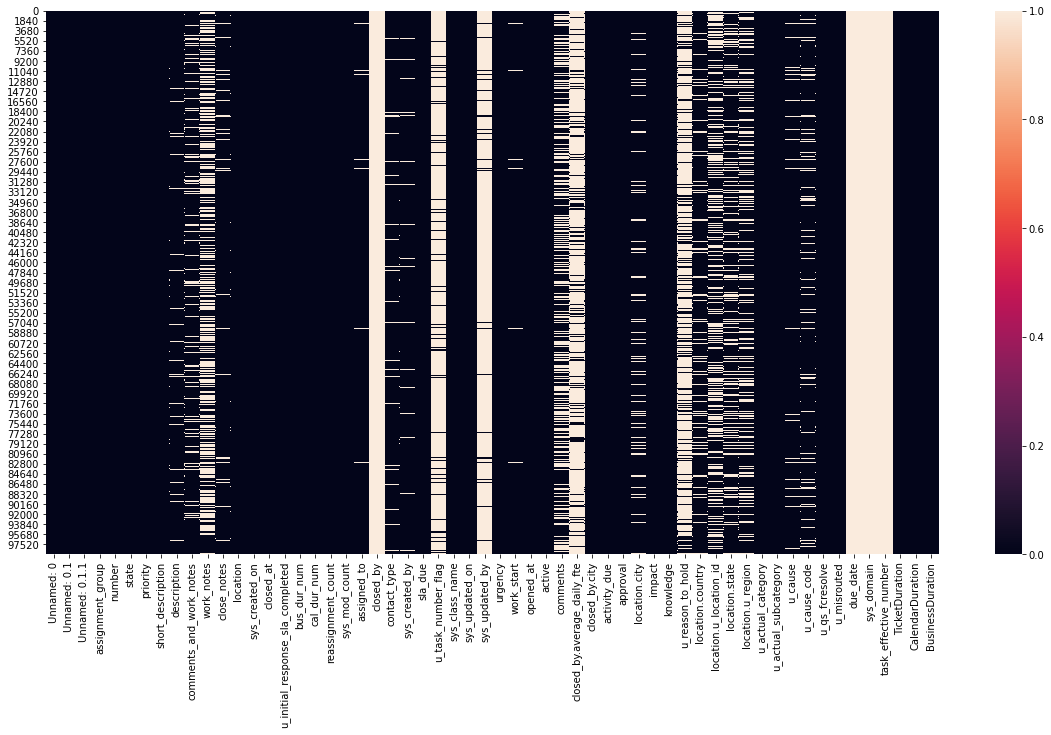

In [ ]:
plt.rcParams['figure.figsize'] = (20.0, 10.0)
sns.heatmap(a_data.isnull())

In [ ]:
a_data = a_data.dropna(axis=0, subset=['u_actual_subcategory'])


In [ ]:
a_data.isnull().sum()

Unnamed: 0                              0
Unnamed: 0.1                            0
Unnamed: 0.1.1                          0
assignment_group                        0
number                                  0
state                                   0
priority                                0
short_description                      23
description                          2640
comments_and_work_notes             12311
work_notes                          50878
close_notes                          3754
location                                0
sys_created_on                          0
closed_at                               0
u_initial_response_sla_completed        0
bus_dur_num                             0
cal_dur_num                             0
reassignment_count                      0
sys_mod_count                           0
assigned_to                          1207
closed_by                           99327
contact_type                         3828
sys_created_by                    

In [ ]:
a_newdf = a_data.select_dtypes([np.number])
a_newdf.columns.values

array(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'bus_dur_num',
       'cal_dur_num', 'reassignment_count', 'sys_mod_count', 'closed_by',
       'sys_created_by', 'u_task_number_flag', 'sys_updated_by',
       'urgency', 'closed_by.average_daily_fte', 'due_date', 'sys_domain',
       'task_effective_number'], dtype=object)

In [ ]:
a_data['u_actual_subcategory'].value_counts()

software breakfix                    10452
active directory - password reset     6639
vpn 2fa - anyconnect how to           4538
vpn 2fa - registration                4151
computer break / fix                  4120
                                     ...  
sharepoint - password reset              1
eleave - how to                          1
lost or stolen                           1
efax-request                             1
epm - other request                      1
Name: u_actual_subcategory, Length: 191, dtype: int64

In [ ]:
a_data['u_actual_category'].value_counts()

access-issue/request                43792
software                            19945
application-issue/request           11894
computer hardware                    4850
email                                4497
general                              3964
network                              2282
workstation/ computer - software     2062
printer and fax                      2028
security                             1662
phone and mobile                      954
chat                                  457
software asset management             378
video conferencing / webex            328
backup and restore                    220
hardware asset management               8
Name: u_actual_category, dtype: int64

In [ ]:
len(a_data['u_cause'].value_counts())

54662

In [ ]:
(a_data['u_cause'].value_counts())

resolved                                                                                                                                                                                                                                                                                                     15198
issue resolved                                                                                                                                                                                                                                                                                                2069
resolved                                                                                                                                                                                                                                                                                                       787
ad password reset                                                              

In [ ]:
Y=pd.DataFrame(a_data['priority'])
X=a_data.drop(columns=["priority"])
print(type(Y))
print(type(X))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [ ]:
print(a_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99327 entries, 0 to 99326
Data columns (total 58 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Unnamed: 0                        99327 non-null  int64  
 1   Unnamed: 0.1                      99327 non-null  int64  
 2   Unnamed: 0.1.1                    99327 non-null  int64  
 3   assignment_group                  99327 non-null  object 
 4   number                            99327 non-null  object 
 5   state                             99327 non-null  object 
 6   priority                          99327 non-null  object 
 7   short_description                 99304 non-null  object 
 8   description                       96687 non-null  object 
 9   comments_and_work_notes           87016 non-null  object 
 10  work_notes                        48449 non-null  object 
 11  close_notes                       95573 non-null  object 
 12  loca

In [ ]:
X_train, X_test, y_train, y_test = train_test_split( X['short_description'], Y, test_size=0.4, random_state=0)

In [ ]:
print(X_train.shape)
print(y_train.shape)

(59596,)
(59596, 1)


In [ ]:
cv = CountVectorizer()
X_train_tf = cv.fit_transform(X_train.values.astype('U'))
X_train_tf.shape

(59596, 16948)

In [ ]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_tf)
X_train_tfidf.shape

(59596, 16948)

In [ ]:
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()
mnb.fit(X_train_tfidf, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [ ]:
x_test_tf = cv.transform(X_test.values.astype('U'))
X_test_tfidf = tfidf_transformer.transform(x_test_tf)
pred = mnb.predict(X_test_tfidf)

In [ ]:
print(round(f1_score(y_test, pred, average='macro'),2))
print(round(accuracy_score(y_test, pred),2))

0.29
0.88


In [ ]:
print('***Stemming***')
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english", ignore_stopwords=True)
class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])
stemmed_count_vect = StemmedCountVectorizer(stop_words='english')
X_train_counts = stemmed_count_vect.fit_transform(X_train.values.astype('U'))
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
X_train_tfidf= tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score, accuracy_score
mnb = MultinomialNB()
mnb.fit(X_train_tfidf, y_train)
X_test_tf = stemmed_count_vect.transform(X_test.values.astype('U'))
X_test_tfidf = tfidf_transformer.transform(X_test_tf)
pred = mnb.predict(X_test_tfidf)
print('MultinomialNB')
print(round(f1_score(y_test, pred, average='macro'),2))
print(round(accuracy_score(y_test, pred),2))

***Stemming***


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MultinomialNB
0.29
0.88


[Text(0, 0, 'software'),
 Text(0, 0, 'security'),
 Text(0, 0, 'workstation/ computer - software'),
 Text(0, 0, 'computer hardware'),
 Text(0, 0, 'access-issue/request'),
 Text(0, 0, 'email'),
 Text(0, 0, 'application-issue/request'),
 Text(0, 0, 'phone and mobile'),
 Text(0, 0, 'general'),
 Text(0, 0, 'network'),
 Text(0, 0, 'printer and fax'),
 Text(0, 0, 'backup and restore'),
 Text(0, 0, 'chat'),
 Text(0, 0, 'software asset management'),
 Text(0, 0, 'video conferencing / webex'),
 Text(0, 0, 'hardware asset management')]

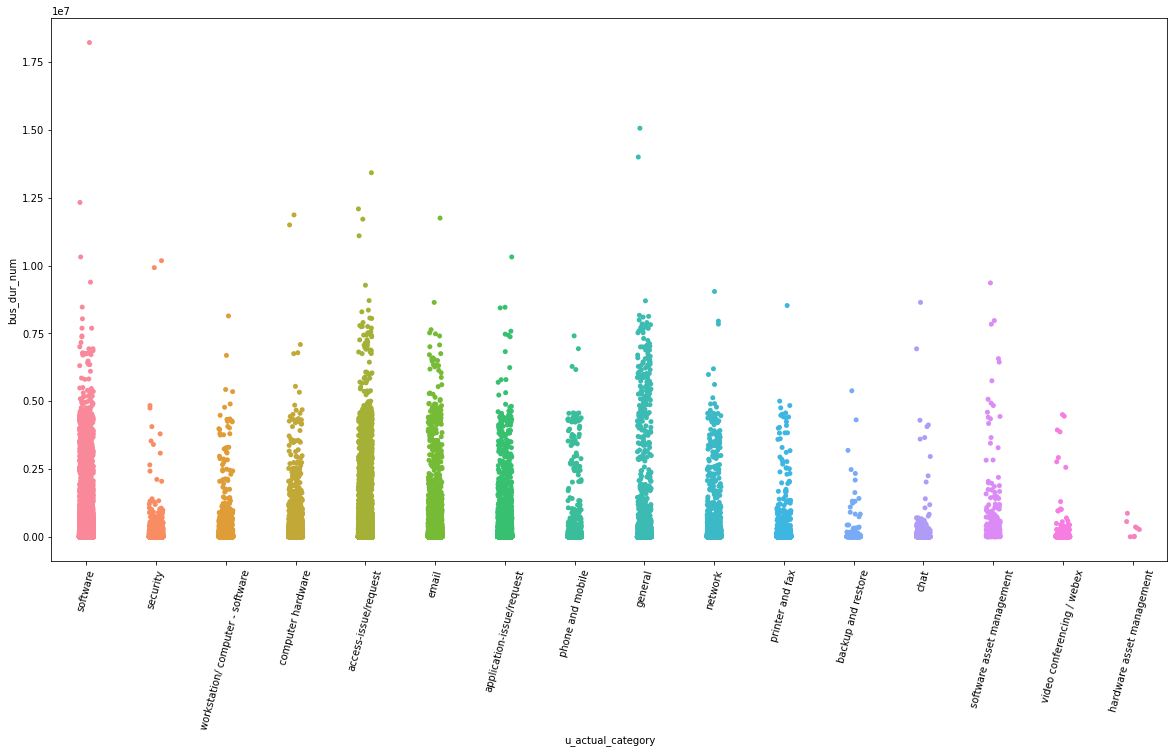

In [ ]:
plt.rcParams['figure.figsize'] = (20.0, 10.0)
p= sns.stripplot(data=a_data, x='u_actual_category', y='bus_dur_num')
p.set_xticklabels(p.get_xticklabels(), rotation=75)

[Text(0, 0, 'software'),
 Text(0, 0, 'security'),
 Text(0, 0, 'workstation/ computer - software'),
 Text(0, 0, 'computer hardware'),
 Text(0, 0, 'access-issue/request'),
 Text(0, 0, 'email'),
 Text(0, 0, 'application-issue/request'),
 Text(0, 0, 'phone and mobile'),
 Text(0, 0, 'general'),
 Text(0, 0, 'network'),
 Text(0, 0, 'printer and fax'),
 Text(0, 0, 'backup and restore'),
 Text(0, 0, 'chat'),
 Text(0, 0, 'software asset management'),
 Text(0, 0, 'video conferencing / webex'),
 Text(0, 0, 'hardware asset management')]

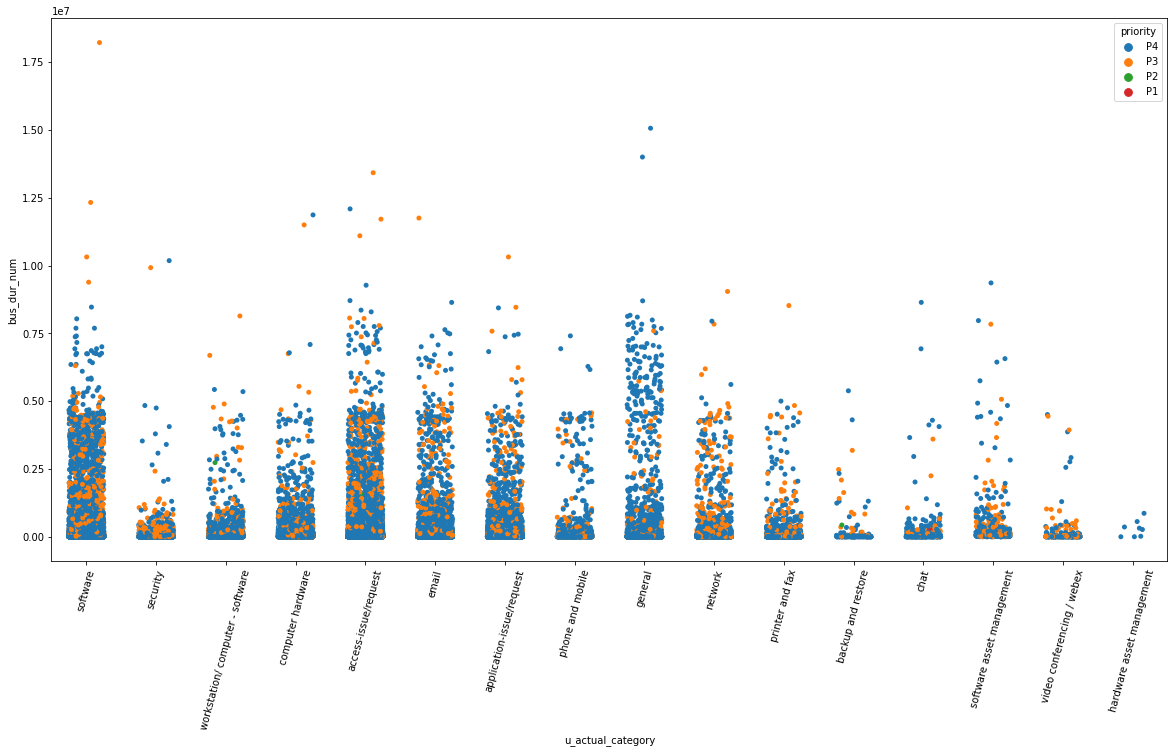

In [ ]:
p= sns.stripplot(data=a_data, x='u_actual_category', y='bus_dur_num', hue='priority', jitter=.25)
p.set_xticklabels(p.get_xticklabels(), rotation=75)

[Text(0, 0, 'software'),
 Text(0, 0, 'security'),
 Text(0, 0, 'workstation/ computer - software'),
 Text(0, 0, 'computer hardware'),
 Text(0, 0, 'access-issue/request'),
 Text(0, 0, 'email'),
 Text(0, 0, 'application-issue/request'),
 Text(0, 0, 'phone and mobile'),
 Text(0, 0, 'general'),
 Text(0, 0, 'network'),
 Text(0, 0, 'printer and fax'),
 Text(0, 0, 'backup and restore'),
 Text(0, 0, 'chat'),
 Text(0, 0, 'software asset management'),
 Text(0, 0, 'video conferencing / webex'),
 Text(0, 0, 'hardware asset management')]

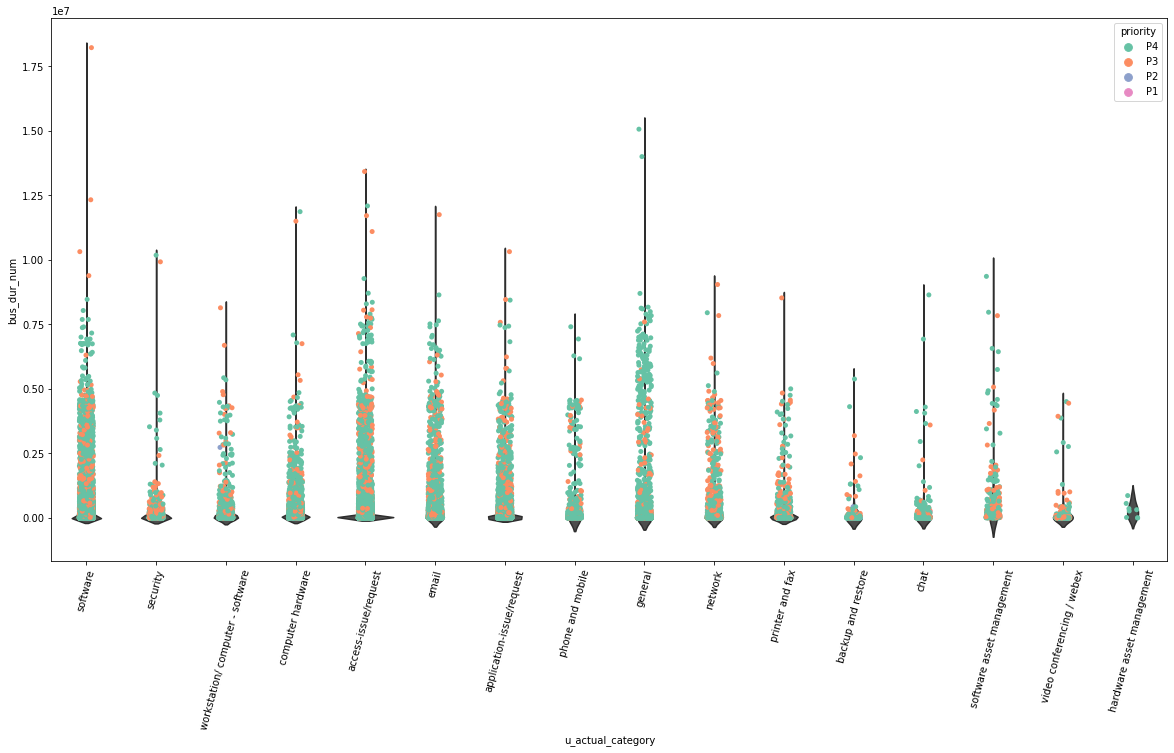

In [ ]:
ax = sns.violinplot(x='u_actual_category', y='bus_dur_num', data=a_data,inner=None, color=".3")
ax = sns.stripplot(x="u_actual_category", y="bus_dur_num",hue="priority", palette="Set2", data=a_data)
ax.set_xticklabels(p.get_xticklabels(), rotation=75)

[Text(0, 0, 'software'),
 Text(0, 0, 'security'),
 Text(0, 0, 'workstation/ computer - software'),
 Text(0, 0, 'computer hardware'),
 Text(0, 0, 'access-issue/request'),
 Text(0, 0, 'email'),
 Text(0, 0, 'application-issue/request'),
 Text(0, 0, 'phone and mobile'),
 Text(0, 0, 'general'),
 Text(0, 0, 'network'),
 Text(0, 0, 'printer and fax'),
 Text(0, 0, 'backup and restore'),
 Text(0, 0, 'chat'),
 Text(0, 0, 'software asset management'),
 Text(0, 0, 'video conferencing / webex'),
 Text(0, 0, 'hardware asset management')]

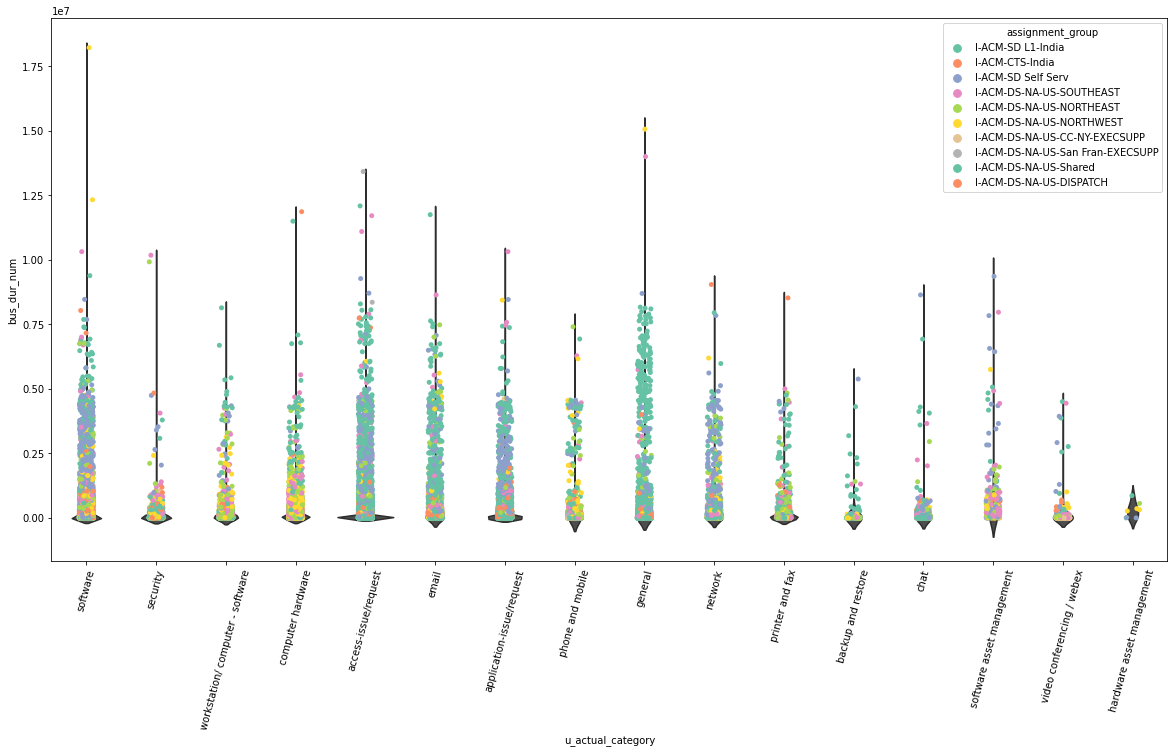

In [ ]:
ax = sns.violinplot(x='u_actual_category', y='bus_dur_num', data=a_data,inner=None, color=".3")
ax = sns.stripplot(x="u_actual_category", y="bus_dur_num",hue="assignment_group", palette="Set2", data=a_data)
ax.set_xticklabels(p.get_xticklabels(), rotation=75)

all yall!

Can do a lot more from here. apply filters to assignment group, explore how they do for durations by category, subcategory, priority, by technician, location, hop/reassignments. etc etc Then time series as well.

go forth and play EDA

# COMPANY J - EDA

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
#COMPANY A
#read in data

j_data = pd.read_csv('/content/gdrive/Shared drives/IST 718 Project/j_cleaned.csv')
j_data.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3,5,7,9,10,12,14,17,18,19,24,28,29,30,32,34,35,37,38,39,41,42,44,52,53,54,55,56,57,58,59,64,66,67,68,69,71,72,73,74,75,76,77,85) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,number,opened_at,incident_state,sys_updated_by,category,short_description,caller_id.location,assignment_group,u_time_last_workgroup_first_se,u_resolution_rejected_report,u_resolution_rejected,u_rejected_from_assignedto,u_reject_count,u_last_transfer_time,u_last_incident_state,u_last_assignment_group,u_initial_support_group,u_initial_priority,u_incident_rejected,urgency,sys_mod_count,sys_updated_on,time_worked,u_time_resolved,sys_class_name,u_task_state,state,severity,priority,u_pending_reminder_sent,u_pending_user_last_workgroup_,u_operational_task,u_notify_caller_update,notify,u_new_requirement,made_sla,u_last_service_call_update,u_last_priority,u_last_assignment_time,...,knowledge,sys_domain,sla_due,sys_created_by,sys_created_on,contact_type,u_contact_windows_team,u_contact_unix_team,u_contact_unified_messaging_te,u_contact_network_team,u_contact_foundation_team,u_contact_dba_team,u_contact_client_technology_gr,u_close_code,bus_dur_num,activity_due,active,assigned_to,subcategory,reassignment_count,expected_start,parent,due_date,closed_by,closed_at,work_end,request_item,request,TicketDuration,ExpectedTaskDuration,TaskDuration,CloseWorkDiff,TotalSlaDuration,ULastWorkgroupDuration,TimeFirstTransfer,PendingUserDuration,Pending3rdPartyDuration,CalendarDuration,BusinessDuration,last_service_call_update_datetime
0,0,INC3148753,2020-06-09 20:46:00,Closed,system,Desktop or laptop,\tI have opened laptop refresh for more than 1 month and I have not received any updates.This is the ticket number REQ599157,"Sunnyvale, CA",ONSITE-AMERICAS,2020-06-10 18:45:00,Accepted Resolution,0.0,pthakur,0.0,2020-06-10 15:45:00,6.0,onsite-americas,itco,P3,False,2,6,2020-06-22 03:02:00,0,2020-06-11 17:26:00,Incident,Closed,Closed Complete,3 - Low,P3,False,81659.0,False,Yes,Do not notify,False,True,"Jun 22, 2020 00:02:12 system: Incident automatically closed after 10 days in the Resolved state.",P3,2020-06-10 15:45:00,...,False,global,2020-06-24 05:03:00,neelamvijay,2020-06-09 20:46:00,Self-service,False,False,False,False,False,False,False,Resolved,713708,6/15/2020 18:45,False,ttruong,other,1,NaN,NaN,NaN,NaN,2020-06-22 03:02:00,NaN,NaN,NaN,1 days 20:40:00,NaN,NaN,NaN,2:59:54,2:59:54,18:58:54,22:40:59,0:00:00,"12 days, 6:15:17","8 days, 6:15:08",2020-06-22 00:02:12
1,1,INC2960955,2020-02-04 07:46:00,Closed,system,Easy connect,I can't seem to connect via Pulse anymore with my MAC. This was working just fine yesterday. It is giving me invalid certificate. Are there some instructions I can follow?,"Westford, MA",ONSITE-AMERICAS,2020-02-04 09:55:00,Accepted Resolution,0.0,talmquist,0.0,2020-02-04 07:47:00,6.0,onsite-americas,onsite-americas,P3,False,2,4,2020-02-15 03:03:00,0,2020-02-04 14:18:00,Incident,Closed,Closed Complete,3 - Low,P3,False,0.0,False,Yes,Do not notify,False,True,"Feb 15, 2020 00:03:26 system: Incident automatically closed after 10 days in the Resolved state.",P3,2020-02-04 07:47:00,...,False,global,2020-02-19 13:28:00,talmquist,2020-02-04 07:47:00,Incident Form,False,False,False,False,False,False,False,Resolved,735188,UNKNOWN,False,ccoffee,report an issue,0,NaN,NaN,NaN,NaN,2020-02-15 03:03:00,NaN,NaN,NaN,0 days 06:32:00,NaN,NaN,NaN,6:30:39,2:07:36,0:00:00,0:00:00,0:00:00,"10 days, 19:16:42","8 days, 12:13:08",2020-02-15 00:03:26
2,2,INC3131802,2020-05-27 11:06:00,Closed,system,Desktop or laptop,""" i"" key not working : virtual keyboard works fine","Houston, TX",ONSITE-AMERICAS,2020-05-27 12:43:00,Accepted Resolution,0.0,pthakur,0.0,2020-05-27 12:27:00,4.0,onsite-americas,onsite-americas,P3,False,2,6,2020-06-07 03:02:00,2,2020-06-07 03:02:00,Incident,Closed,Closed Complete,3 - Low,P3,True,915534.0,False,Yes,Do not notify,False,True,"Jun 07, 2020 00:02:12 system: Incident automatically closed after 10 days in the Pending (User) state.",P3,2020-05-27 12:27:00,...,False,global,2020-06-10 18:23:00,pthakur,2020-05-27 12:27:00,Incident Form,False,False,False,False,False,False,False,Cancelled,636783,6/6/2020 12:43,False,tdefranco,deskto

In [ ]:
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer,f1_score, accuracy_score, precision_score
from sklearn.model_selection import GridSearchCV
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

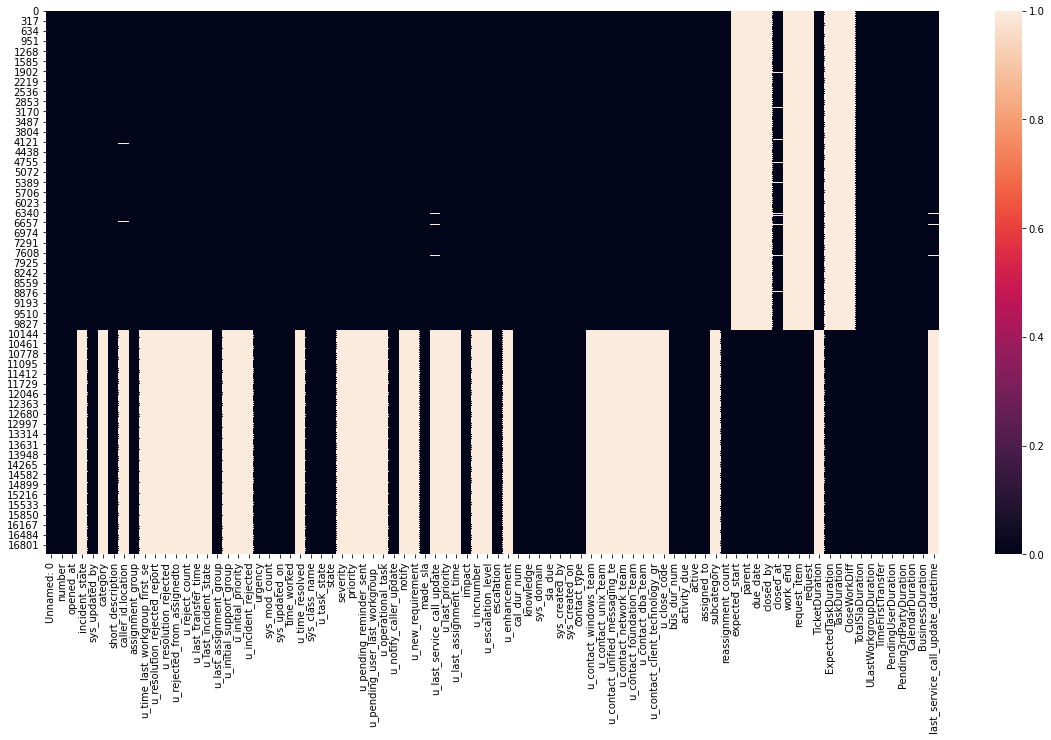

In [ ]:
plt.rcParams['figure.figsize'] = (20.0, 10.0)
sns.heatmap(j_data.isnull())

In [ ]:
j_data = j_data.dropna(axis=0, subset=['subcategory'])

In [ ]:
j_data.isnull().sum()

Unnamed: 0                            0
number                                0
opened_at                             0
incident_state                        0
sys_updated_by                        0
                                     ..
PendingUserDuration                   0
Pending3rdPartyDuration               0
CalendarDuration                      0
BusinessDuration                      0
last_service_call_update_datetime    49
Length: 86, dtype: int64

In [ ]:
j_newdf = a_data.select_dtypes([np.number])
j_newdf.columns.values

array(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'bus_dur_num',
       'cal_dur_num', 'reassignment_count', 'sys_mod_count', 'closed_by',
       'sys_created_by', 'u_task_number_flag', 'sys_updated_by',
       'urgency', 'closed_by.average_daily_fte', 'due_date', 'sys_domain',
       'task_effective_number'], dtype=object)

In [ ]:
j_data['subcategory'].value_counts()

report an issue                         1932
desktop / laptop hardware issue         1660
desktop / laptop application issue       928
change or reset password                 827
problem with remote access/vpn/token     653
                                        ... 
purchasing                                 1
service                                    1
dhcp                                       1
report a telephone issue                   1
telephone â request a new phone          1
Name: subcategory, Length: 77, dtype: int64

In [ ]:
j_data['category'].value_counts()

Desktop or laptop                        3476
Access and passwords                     2166
Application support                      2039
Infrastructure services                   577
Printers and peripherals                  474
Mobility devices and services             454
Easy connect                              310
Software                                  257
Email / Calendar                          109
Telephone & Conference (Audio, Video)      78
Collaboration and content tools            64
Microsoft Skype services                   27
ININ (Contact Center service)               7
Infrastructure Monitoring                   5
Customer Success Business Management        2
Engineering                                 2
Finance                                     1
Name: category, dtype: int64

In [ ]:
Y=pd.DataFrame(j_data['priority'])
X=j_data.drop(columns=["priority"])
print(type(Y))
print(type(X))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [ ]:
X_train, X_test, y_train, y_test = train_test_split( X['short_description'], Y, test_size=0.4, random_state=0)

In [ ]:
print(X_train.shape)
print(y_train.shape)

(6028,)
(6028, 1)


In [ ]:
cv = CountVectorizer()
X_train_tf = cv.fit_transform(X_train.values.astype('U'))
X_train_tf.shape

(6028, 3625)

In [ ]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_tf)
X_train_tfidf.shape

(6028, 3625)

In [ ]:
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()
mnb.fit(X_train_tfidf, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [ ]:
x_test_tf = cv.transform(X_test.values.astype('U'))
X_test_tfidf = tfidf_transformer.transform(x_test_tf)
pred = mnb.predict(X_test_tfidf)

In [ ]:
print(round(f1_score(y_test, pred, average='macro'),2))
print(round(accuracy_score(y_test, pred),2))

0.52
0.81


In [ ]:
print('***Stemming***')
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english", ignore_stopwords=True)
class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])
stemmed_count_vect = StemmedCountVectorizer(stop_words='english')
X_train_counts = stemmed_count_vect.fit_transform(X_train.values.astype('U'))
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
X_train_tfidf= tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score, accuracy_score
mnb = MultinomialNB()
mnb.fit(X_train_tfidf, y_train)
X_test_tf = stemmed_count_vect.transform(X_test.values.astype('U'))
X_test_tfidf = tfidf_transformer.transform(X_test_tf)
pred = mnb.predict(X_test_tfidf)
print('MultinomialNB')
print(round(f1_score(y_test, pred, average='macro'),2))
print(round(accuracy_score(y_test, pred),2))

***Stemming***


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MultinomialNB
0.5
0.8


[Text(0, 0, 'Desktop or laptop'),
 Text(0, 0, 'Easy connect'),
 Text(0, 0, 'Application support'),
 Text(0, 0, 'Access and passwords'),
 Text(0, 0, 'Email / Calendar'),
 Text(0, 0, 'Infrastructure services'),
 Text(0, 0, 'Mobility devices and services'),
 Text(0, 0, 'Telephone & Conference (Audio, Video)'),
 Text(0, 0, 'Software'),
 Text(0, 0, 'Printers and peripherals'),
 Text(0, 0, 'Collaboration and content tools'),
 Text(0, 0, 'Customer Success Business Management'),
 Text(0, 0, 'Microsoft Skype services'),
 Text(0, 0, 'Infrastructure Monitoring'),
 Text(0, 0, 'ININ (Contact Center service)'),
 Text(0, 0, 'Engineering'),
 Text(0, 0, 'Finance')]

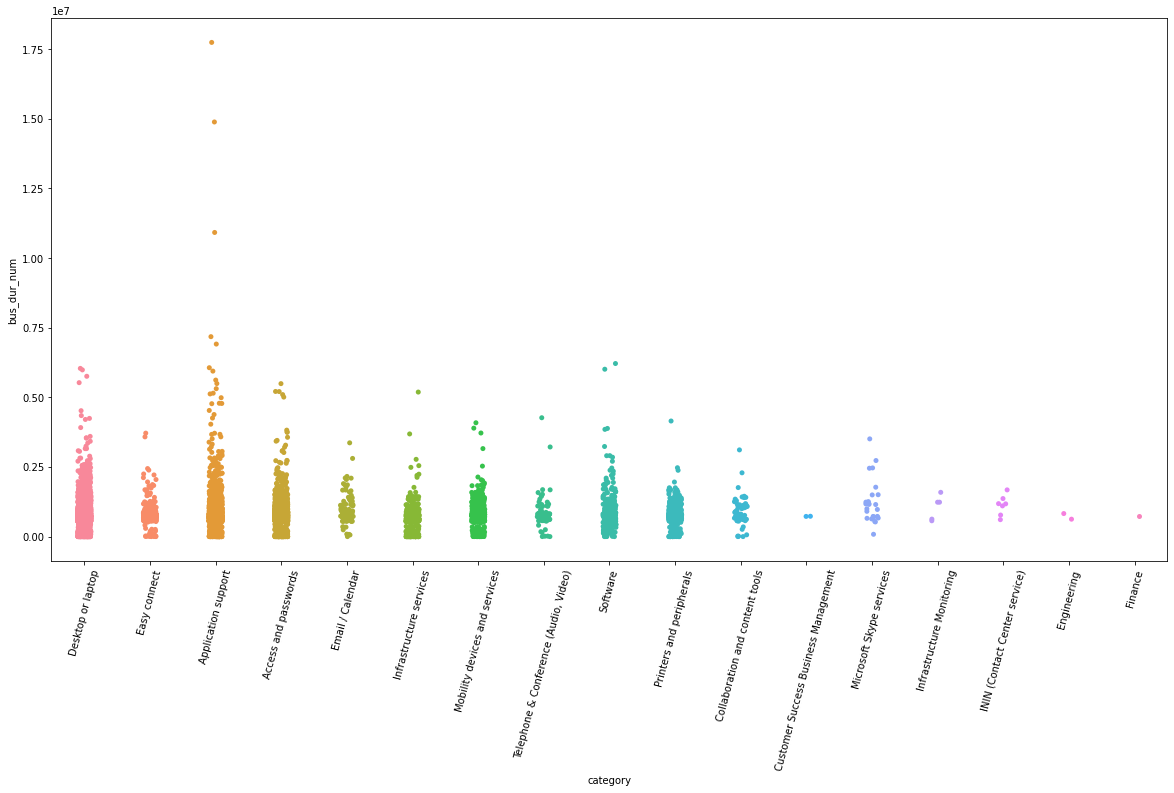

In [ ]:
plt.rcParams['figure.figsize'] = (20.0, 10.0)
p= sns.stripplot(data=j_data, x='category', y='bus_dur_num')
p.set_xticklabels(p.get_xticklabels(), rotation=75)

[Text(0, 0, 'Desktop or laptop'),
 Text(0, 0, 'Easy connect'),
 Text(0, 0, 'Application support'),
 Text(0, 0, 'Access and passwords'),
 Text(0, 0, 'Email / Calendar'),
 Text(0, 0, 'Infrastructure services'),
 Text(0, 0, 'Mobility devices and services'),
 Text(0, 0, 'Telephone & Conference (Audio, Video)'),
 Text(0, 0, 'Software'),
 Text(0, 0, 'Printers and peripherals'),
 Text(0, 0, 'Collaboration and content tools'),
 Text(0, 0, 'Customer Success Business Management'),
 Text(0, 0, 'Microsoft Skype services'),
 Text(0, 0, 'Infrastructure Monitoring'),
 Text(0, 0, 'ININ (Contact Center service)'),
 Text(0, 0, 'Engineering'),
 Text(0, 0, 'Finance')]

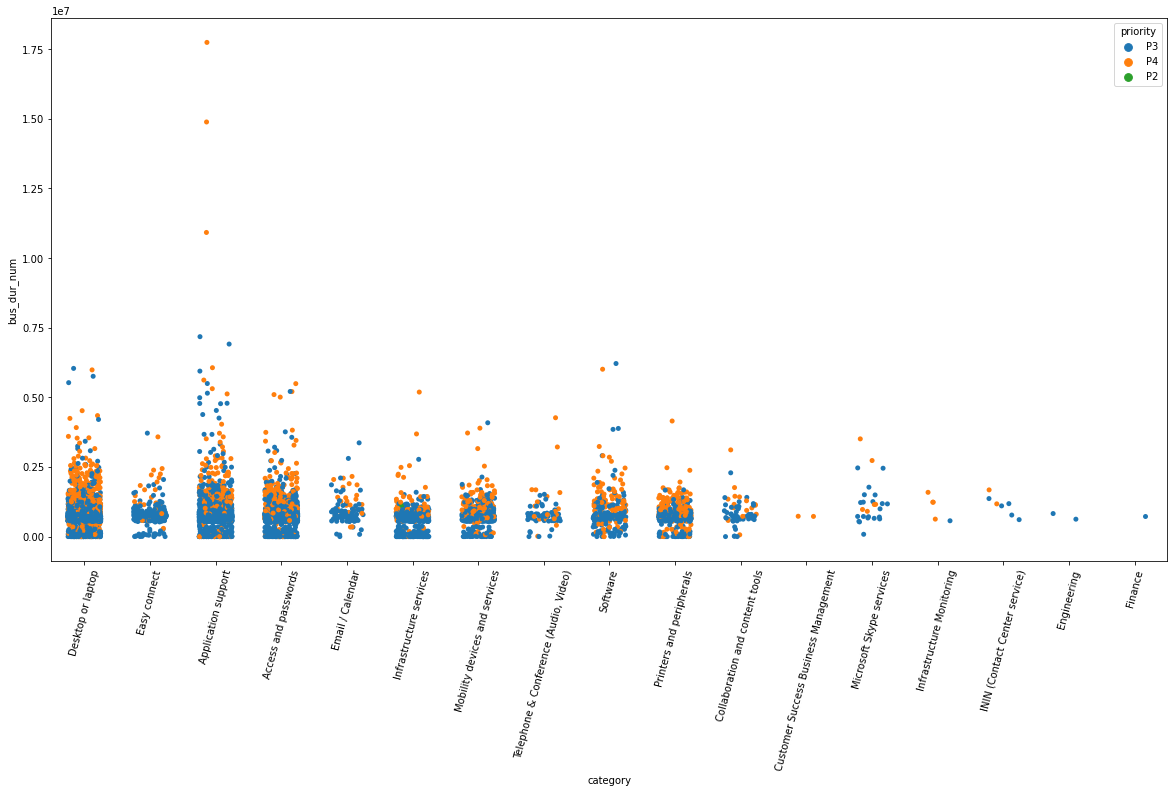

In [ ]:
p= sns.stripplot(data=j_data, x='category', y='bus_dur_num', hue='priority', jitter=.25)
p.set_xticklabels(p.get_xticklabels(), rotation=75)

[Text(0, 0, 'Desktop or laptop'),
 Text(0, 0, 'Easy connect'),
 Text(0, 0, 'Application support'),
 Text(0, 0, 'Access and passwords'),
 Text(0, 0, 'Email / Calendar'),
 Text(0, 0, 'Infrastructure services'),
 Text(0, 0, 'Mobility devices and services'),
 Text(0, 0, 'Telephone & Conference (Audio, Video)'),
 Text(0, 0, 'Software'),
 Text(0, 0, 'Printers and peripherals'),
 Text(0, 0, 'Collaboration and content tools'),
 Text(0, 0, 'Customer Success Business Management'),
 Text(0, 0, 'Microsoft Skype services'),
 Text(0, 0, 'Infrastructure Monitoring'),
 Text(0, 0, 'ININ (Contact Center service)'),
 Text(0, 0, 'Engineering'),
 Text(0, 0, 'Finance')]

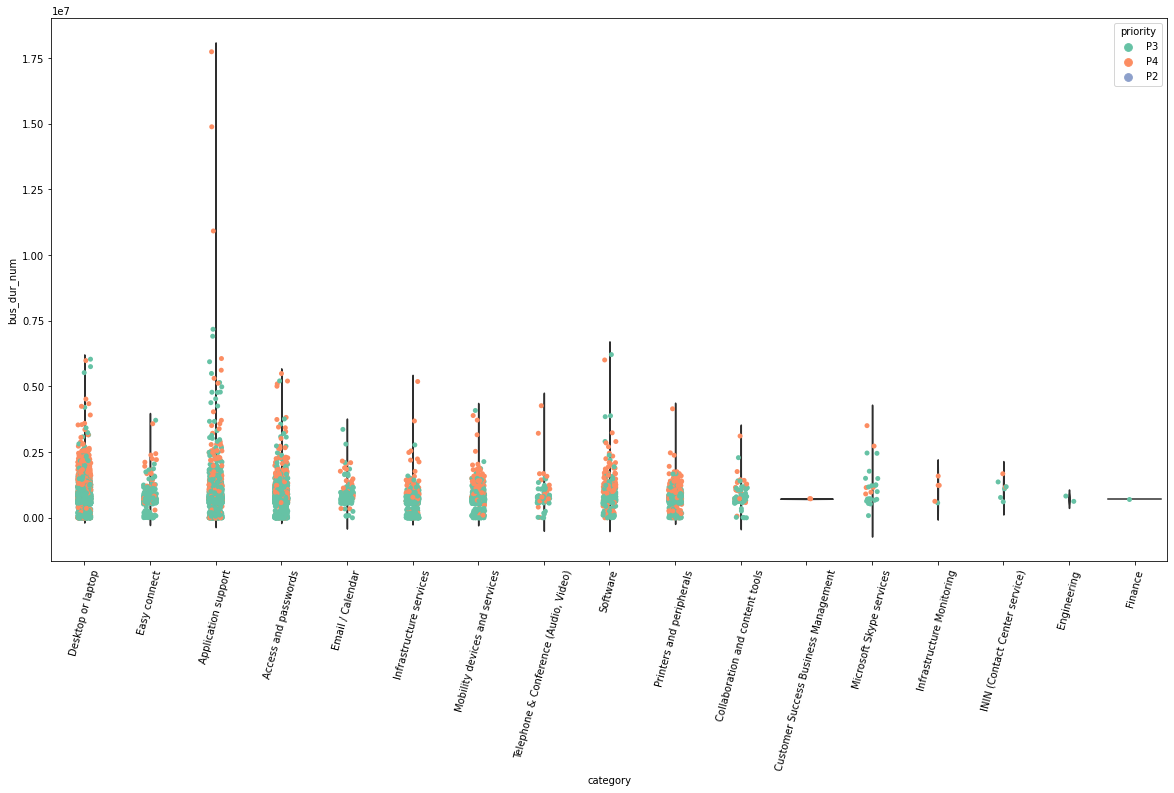

In [ ]:
ax = sns.violinplot(x='category', y='bus_dur_num', data=j_data,inner=None, color=".3")
ax = sns.stripplot(x="category", y="bus_dur_num",hue="priority", palette="Set2", data=j_data)
ax.set_xticklabels(p.get_xticklabels(), rotation=75)

[Text(0, 0, 'Desktop or laptop'),
 Text(0, 0, 'Easy connect'),
 Text(0, 0, 'Application support'),
 Text(0, 0, 'Access and passwords'),
 Text(0, 0, 'Email / Calendar'),
 Text(0, 0, 'Infrastructure services'),
 Text(0, 0, 'Mobility devices and services'),
 Text(0, 0, 'Telephone & Conference (Audio, Video)'),
 Text(0, 0, 'Software'),
 Text(0, 0, 'Printers and peripherals'),
 Text(0, 0, 'Collaboration and content tools'),
 Text(0, 0, 'Customer Success Business Management'),
 Text(0, 0, 'Microsoft Skype services'),
 Text(0, 0, 'Infrastructure Monitoring'),
 Text(0, 0, 'ININ (Contact Center service)'),
 Text(0, 0, 'Engineering'),
 Text(0, 0, 'Finance')]

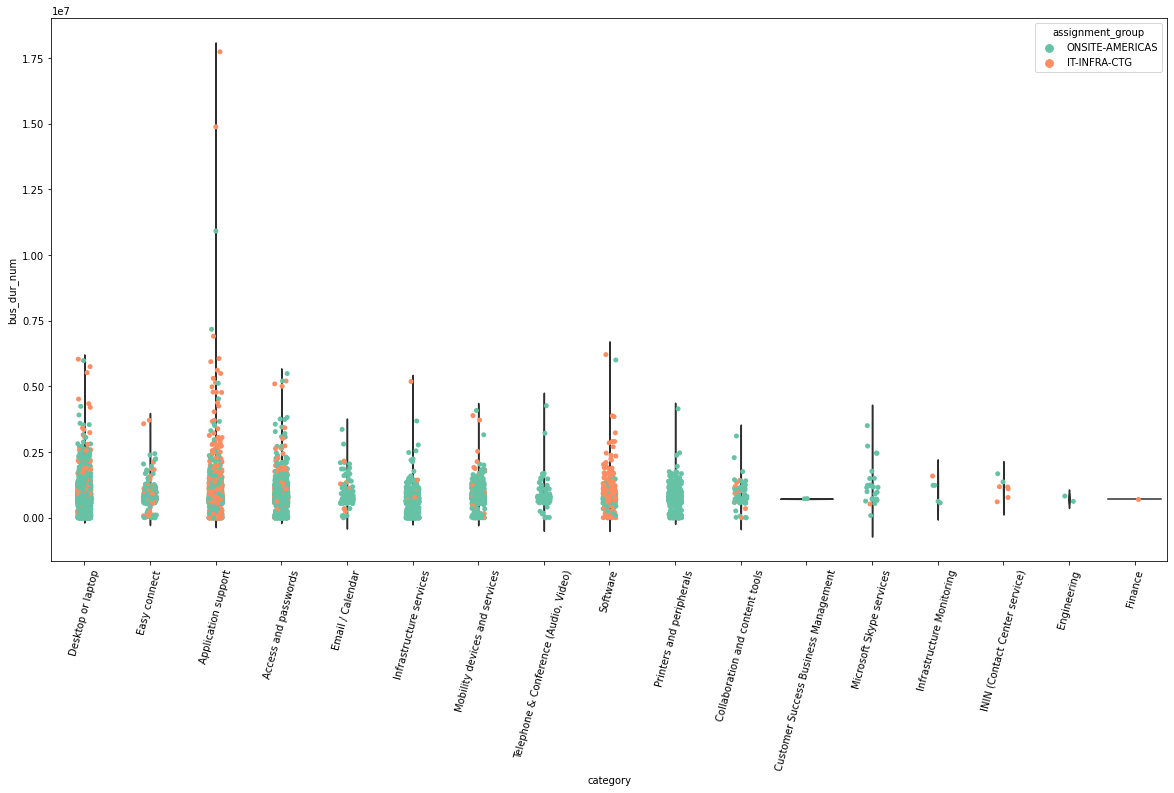

In [ ]:
ax = sns.violinplot(x='category', y='bus_dur_num', data=j_data,inner=None, color=".3")
ax = sns.stripplot(x="category", y="bus_dur_num",hue="assignment_group", palette="Set2", data=j_data)
ax.set_xticklabels(p.get_xticklabels(), rotation=75)